# Person Re-ID

## Importing

In [1]:
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import time
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import scipy.io

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import List, Tuple

## Runtime settings

In [3]:
import warnings
import wandb

!pip install -q wandb
!wandb login

os.environ["WANDB_API_KEY"] = "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"
#wandb.login(key=os.environ["WANDB_API_KEY"])

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available.")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings.")

All good, a GPU is available.


## Reproducibility & deterministic mode

In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 42
fix_random(seed=seed)

## Inspecting the dataset

This package contains the following items.
1. Folder "frames". It contains 11,816 video frames captured by 6 cameras. For the naming rule of each frame, for example, in "c1s1_000151.jpg", "c1" refers to camera 1; "s1" refers to segment 1 in camera 1 (generated automatically during data collection); "000151" refers to the 151th frame in this segment. In addition, the train/test split is FIXED and provided by the files "frame_test.mat" and "frame_train.mat". 10-fold cross validation is NOT required.

2. Folder "annotations". It contains 11,816 MAT files in correspondence to each frame in folder "frames". All annotated boxes are pedestrians. Each MAT file records the bounding box position within the frame and its ID. The coordinates of each box are formatted in [x, y, w, h]. The ID of each box takes the value of [1, 932] as well as -2. "-2" means that we do not know for sure the ID of the person, and not used in the testing of person re-id, but is used in train/test of pedestrian detection (potentially used in the training of person re-identification).

3. Folder "query_box". It contains the query boxes of the PRW dataset. All togther there are 2057 queries. For naming rule, for example, in "479_c1s3_016471.jpg", "479" refers to the ID of the query, and "c1s3_016471" refers to the video frame where the query is cropped. Note that 1) the query IDs are not included in the training set, 2) the query images are not normalized (we typically use 128*64 for BoW extraction, and 224*224 for CNN feature extraction), 3) all queries are hand-drawn boxes, 4) we select one query image for each testing ID under each camera, so the maximum number of queries per ID is 6. In addition, we provide the bounding box information of each query in "query_info.txt", so one can generate the queries from the video frames through function "generate_query.m".

In addition, we provide the train/test split of the PRW dataset. One do not have to perform 10-fold cross validation. In detail, "frame_test.mat" and "frame_train.mat" specify the train/test frames, and "ID_test.mat" and "ID_train.mat" specify the train/test IDs. Note that a small portion of IDs used in training may appear in the testing frames, but will not appear in the testing IDs. 

What basic tasks can you do with PRW?
1. Pedestrian detection. Models can be trained on the training set specified in "frame_train" and tested on "frame_test". In the paper, we report both Average Precision and Miss Rate for pedestrian detection.

2. Person Re-identification. When you use your own detector or those provided by us, you will obtain your own gallery with varying sizes according to the threshold of the detectors. Then, with the given query images, standard person re-identification can be performed. We use mAP and CMC curve (and rank-1 accuracy) to evaluate overall re-identification performance. Note that, when your detector has poor performance, re-id accuracy will be low as a result. 

In [6]:
print("Num. frames:", len(os.listdir("/kaggle/input/prw-person-re-identification-in-the-wild/frames")))
print("Num. queries:", len(os.listdir("/kaggle/input/prw-person-re-identification-in-the-wild/query_box")))

Num. frames: 11816
Num. queries: 2057


In [13]:
"""
all_imgs_path = "/kaggle/input/prw-person-re-identification-in-the-wild/frames"
list_imgs = os.listdir(all_imgs_path)
list_sizes = []

for img_path in list_imgs:
    img = Image.open(os.path.join(all_imgs_path, img_path))
    list_sizes.append(img.size)
"""

'\nall_imgs_path = "/kaggle/input/prw-person-re-identification-in-the-wild/frames"\nlist_imgs = os.listdir(all_imgs_path)\nlist_sizes = []\n\nfor img_path in list_imgs:\n    img = Image.open(os.path.join(all_imgs_path, img_path))\n    list_sizes.append(img.size)\n'

In [14]:
"""
all_queries_path = "/kaggle/input/prw-person-re-identification-in-the-wild/query_box"
list_queries = os.listdir(all_queries_path)
list_sizes_q = []

for q_path in list_queries:
    q = Image.open(os.path.join(all_queries_path, q_path))
    list_sizes_q.append(q.size)
"""

'\nall_queries_path = "/kaggle/input/prw-person-re-identification-in-the-wild/query_box"\nlist_queries = os.listdir(all_queries_path)\nlist_sizes_q = []\n\nfor q_path in list_queries:\n    q = Image.open(os.path.join(all_queries_path, q_path))\n    list_sizes_q.append(q.size)\n'

In [15]:
#print(f"Frame sizes: {set(list_sizes)}")
#print(f"Query sizes: {list_sizes_q[:10]}")

> Frame sizes are just of two different types; query sizes are instead of vary different types

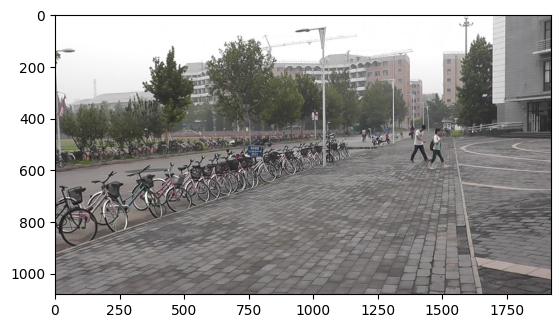

image size: (1920, 1080)


In [23]:
# SHOW FRAMES
img_path = "/kaggle/input/prw-person-re-identification-in-the-wild/frames/c1s1_002876.jpg"
img = Image.open(img_path)
plt.imshow(img)
plt.show()
print(f"image size: {img.size}")

In [24]:
# SHOW ANNOTATIONS
mat = scipy.io.loadmat('/kaggle/input/prw-person-re-identification-in-the-wild/annotations/c1s1_002876.jpg.mat')
print(mat["box_new"]) # [ID, x, y, w, h]

[[  15.         1372.2062635   421.53671706   72.31101512  158.61771058]
 [  25.         1442.18466523  433.19978402   79.30885529  165.61555076]]


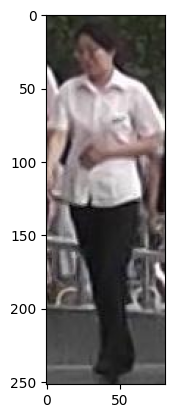

query size: (81, 252)


In [25]:
# SHOW QUERIES
query_path = "/kaggle/input/prw-person-re-identification-in-the-wild/query_box/486_c3s1_157433.jpg"
query = Image.open(query_path)
plt.imshow(query)
plt.show()
print(f"query size: {query.size}")

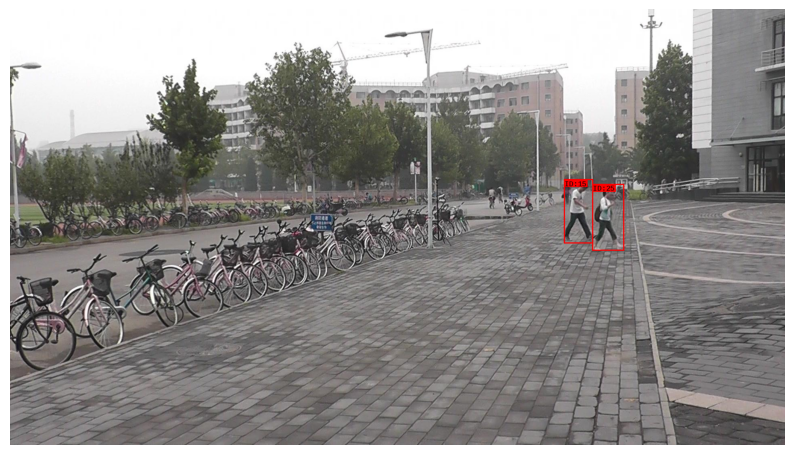

In [6]:
# DRAW BOXES
import numpy as np
import scipy.io
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_prw_box(
    image: Image.Image,
    box_new: np.ndarray,
    show_id: bool = True,
    filter_ids: bool = False,      # se True rimuove ID <= 0 (es. -2)
    color=(255, 0, 0),
    width: int = 3,
) -> Image.Image:
    """
    Draw PRW annotations from mat["box_new"] where each row is [ID, x, y, w, h].
    Coordinates are pixel coords (not normalized).
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)

    # font: su kaggle spesso questa path funziona; se no fallback
    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 18
        )
    except Exception:
        font = ImageFont.load_default()

    if box_new is None:
        return img

    box_new = np.asarray(box_new)
    if box_new.size == 0:
        return img

    # TODO - optimize
    # g.t. or re-id case
    if show_id: 
        box_new = box_new.reshape(-1, 5) # Ensure shape [N,5]
    
        for row in box_new:
            pid, x, y, w, h = row.tolist()
    
            if filter_ids and pid <= 0:
                continue
    
            # xywh -> xyxy
            x1, y1 = float(x), float(y)
            x2, y2 = float(x + w), float(y + h)
    
            # draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
    
            text = f"ID:{int(pid)}"
            # text bg
            tw, th = font.getbbox(text)[-2:]
            pad = 2
            draw.rectangle([x1, y1, x1 + tw + 2*pad, y1 + th + 2*pad], fill=color)
            draw.text((x1 + pad, y1 + pad), text, fill="black", font=font)
            
    else: # detection case 
        box_new = box_new.reshape(-1, 4) # Ensure shape [N,4]
    
        for row in box_new:
            x, y, w, h = row.tolist()
    
            if filter_ids and pid <= 0:
                continue
    
            # xywh -> xyxy
            x1, y1 = float(x), float(y)
            x2, y2 = float(x + w), float(y + h)
    
            # draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
    
            # text bg
            pad = 2 
            draw.rectangle([x1, y1, x1 + 2*pad, y1 + 2*pad], fill=color)

    return img


# --- Usage ---
img_path = "/kaggle/input/prw-person-re-identification-in-the-wild/frames/c1s1_002876.jpg"
mat_path = "/kaggle/input/prw-person-re-identification-in-the-wild/annotations/c1s1_002876.jpg.mat"

img = Image.open(img_path).convert("RGB")
mat = scipy.io.loadmat(mat_path)
box_new = mat["box_new"]  # rows: [ID, x, y, w, h]

img_bb = draw_prw_box(img, box_new, show_id=True, filter_ids=False)

plt.figure(figsize=(10, 6))
plt.imshow(img_bb)
plt.axis("off")
plt.show()

In [28]:
# PRINT TRAIN/TEST FRAMES AND IDs
frame_train = scipy.io.loadmat('/kaggle/input/prw-person-re-identification-in-the-wild/frame_train.mat')
id_train = scipy.io.loadmat('/kaggle/input/prw-person-re-identification-in-the-wild/ID_train.mat')
print("TRAIN")
print("Frames:", frame_train["img_index_train"].shape) 
print("ID:", id_train["ID_train"].shape)

frame_test = scipy.io.loadmat("/kaggle/input/prw-person-re-identification-in-the-wild/frame_test.mat")
id_test = scipy.io.loadmat('/kaggle/input/prw-person-re-identification-in-the-wild/ID_test.mat')
print("\nTEST")
print("Frames:", frame_test["img_index_test"].shape) 
print("IDs:", id_test["ID_test2"].shape)

TRAIN
Frames: (5704, 1)
ID: (1, 483)

TEST
Frames: (6112, 1)
IDs: (1, 450)


In [23]:
id_test["ID_test2"][0]

array([479, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495,
       496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508,
       509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
       535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560,
       561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573,
       574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586,
       587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625,
       626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638,
       639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651,
       652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 66

## Data loading and train/val/test split

In [7]:
import scipy.io
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, List, Set
from torch.utils.data import Dataset
from torchvision.transforms import functional as FT

class PRW_dataset(Dataset):
    @staticmethod
    def _load_mat_list(mat_path: Path, key: str):
        d = scipy.io.loadmat(mat_path)
        if key not in d:
            raise KeyError(f"Key '{key}' not found in {mat_path}. Keys: {list(d.keys())}")
        arr = d[key]
        return [x[0].item() for x in arr]  # e.g. 'c1s1_000151'

    @classmethod
    def find_train_test_data(cls, frames_path: Path, train_frames_path: Path, test_frames_path: Path):
        frames = [p.stem for p in sorted(frames_path.glob("*.jpg"))]  # 'c1s1_000151'
        frames_set = set(frames)

        train_names = cls._load_mat_list(train_frames_path, "img_index_train")
        test_names  = cls._load_mat_list(test_frames_path,  "img_index_test")

        train_set = set(train_names)
        test_set  = set(test_names)

        list_train_frames = [f for f in frames if f in train_set]
        list_test_frames  = [f for f in frames if f in test_set]

        if len(list_train_frames) != len(train_names):
            missing = [n for n in train_names if n not in frames_set]
            raise AssertionError(f"Train mismatch: matched={len(list_train_frames)} vs mat={len(train_names)}. Missing (first 10): {missing[:10]}")
        if len(list_test_frames) != len(test_names):
            missing = [n for n in test_names if n not in frames_set]
            raise AssertionError(f"Test mismatch: matched={len(list_test_frames)} vs mat={len(test_names)}. Missing (first 10): {missing[:10]}")

        return list_train_frames, list_test_frames

    def __init__(
        self,
        frames_path: Path,
        path_annotations: Path,
        train_frames_path: Path,
        test_frames_path: Path,
        split: str = "train",
        img_transform=None,
        filter_invalid_ids: bool = False,   # if True: keep only ids > 0
        allowed_pids: Optional[Set[int]] = None,  # keep only these IDs (positive ids)
        drop_empty: bool = False,           # if True: drop images that have zero boxes after filtering
    ):
        self.img_transform = img_transform
        self.filter_invalid_ids = filter_invalid_ids
        self.allowed_pids = allowed_pids
        self.drop_empty = drop_empty

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError("split must be 'train' or 'test'")

        train_frames, test_frames = self.find_train_test_data(frames_path, train_frames_path, test_frames_path)
        allowed_frames = set(train_frames if split == "train" else test_frames)

        self.images = [p for p in sorted(frames_path.glob("*.jpg")) if p.stem in allowed_frames]

        # annotations are named like: c1s1_002876.jpg.mat
        annots = {p.stem: p for p in path_annotations.rglob("*.mat")}  # key: 'c1s1_002876.jpg'

        # building tuples (img, bbox)
        pairs = []
        for img_path in self.images:
            ann_key = img_path.name  # e.g. 'c1s1_002876.jpg'
            ann_path = annots.get(ann_key)
            if ann_path is None:
                raise RuntimeError(f"Missing annotation for frame {img_path.name}")
            pairs.append((img_path, ann_path))

        # pre-loading .mat files for bboxes
        self.box_cache = {}
        for img_path, ann_path in pairs:
            mat = scipy.io.loadmat(ann_path)
            arr = mat.get("box_new", mat.get("anno_file", mat.get("box", None)))

            if arr is None:
                boxes = np.zeros((0, 4), np.float32)
                ids   = np.zeros((0,), np.int64)
            else:
                arr = np.asarray(arr).reshape(-1, 5)
                ids = arr[:, 0].astype(np.int64)
                x = arr[:, 1].astype(np.float32)
                y = arr[:, 2].astype(np.float32)
                w = arr[:, 3].astype(np.float32)
                h = arr[:, 4].astype(np.float32)
                boxes = np.stack([x, y, x + w, y + h], axis=1).astype(np.float32)

            self.box_cache[str(ann_path)] = (boxes, ids)

        # Now build self.pairs, optionally filtering boxes by allowed IDs and dropping empty images
        self.pairs = []
        for img_path, ann_path in pairs:
            boxes_np, ids_np = self.box_cache[str(ann_path)]

            # filter invalid ids (e.g. -2 distractors, 0 background)
            if self.filter_invalid_ids:
                keep = ids_np > 0
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            # filter by allowed_pids (ID-disjoint train/val)
            if self.allowed_pids is not None:
                keep = np.isin(ids_np, np.array(list(self.allowed_pids), dtype=np.int64))
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            # update cache (filtered view)
            self.box_cache[str(ann_path)] = (boxes_np, ids_np)

            if self.drop_empty and boxes_np.shape[0] == 0:
                continue

            self.pairs.append((img_path, ann_path))

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, Any]]:
        img_path, ann_path = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        boxes_np, ids_np = self.box_cache[str(ann_path)]

        target = {
            "boxes": torch.as_tensor(boxes_np, dtype=torch.float32),
            "labels": torch.ones((boxes_np.shape[0],), dtype=torch.int64),
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "person_id": torch.as_tensor(ids_np, dtype=torch.int64),
        }

        if self.img_transform is not None:
            img = self.img_transform(img)
        if not torch.is_tensor(img):
            img = FT.to_tensor(img)

        return img, target

    def __len__(self) -> int:
        return len(self.pairs)

    def unique_positive_pids(self) -> Set[int]:
        """Collect unique IDs > 0 present in this dataset view (after any filtering)."""
        s = set()
        for _, ann_path in self.pairs:
            _, ids_np = self.box_cache[str(ann_path)]
            for pid in ids_np.tolist():
                if pid > 0:
                    s.add(int(pid))
        return s


def make_id_disjoint_train_val(
    trainval_ds: PRW_dataset,
    val_ratio: float = 0.15,
    seed: int = 42,
    ensure_disjoint_from_test: Optional[PRW_dataset] = None,
):
    """
    Split TRAIN IDs into train/val (ID-disjoint).
    Optionally remove IDs that appear in test split too (strict disjoint across train/val/test).
    """
    rng = np.random.default_rng(seed)

    train_ids = sorted(list(trainval_ds.unique_positive_pids()))

    if ensure_disjoint_from_test is not None:
        test_ids = ensure_disjoint_from_test.unique_positive_pids()
        # remove any overlap with test (strict setting)
        train_ids = [pid for pid in train_ids if pid not in test_ids]

    train_ids = np.array(train_ids, dtype=np.int64)
    rng.shuffle(train_ids)

    n_val = int(round(len(train_ids) * val_ratio))
    val_ids = set(map(int, train_ids[:n_val].tolist()))
    trn_ids = set(map(int, train_ids[n_val:].tolist()))

    # sanity: disjoint
    assert val_ids.isdisjoint(trn_ids), "Train/Val ID sets overlap! Bug in split."
    if ensure_disjoint_from_test is not None:
        test_ids = ensure_disjoint_from_test.unique_positive_pids()
        assert val_ids.isdisjoint(test_ids), "Val overlaps with test IDs!"
        assert trn_ids.isdisjoint(test_ids), "Train overlaps with test IDs!"

    # build dataset views
    train_ds = PRW_dataset(
        frames_path=trainval_ds.images[0].parent,  # hack-safe? better pass original path you used
        path_annotations=Path(str(trainval_ds.pairs[0][1])).parents[0],  # not ideal; see note below
        train_frames_path=None,  # NOTE: don't use this constructor path hack in production
        test_frames_path=None,
    )
    raise NotImplementedError("See the note below for clean construction.")


def build_train_val_views(
    frames_path: Path,
    path_annotations: Path,
    train_frames_mat: Path,
    test_frames_mat: Path,
    img_transform=None,
    filter_invalid_ids: bool = True,
    val_ratio: float = 0.15,
    seed: int = 42,
    strict_disjoint_from_test: bool = True,
):
    # base datasets
    trainval = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=None,
        drop_empty=False,
    )

    test = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="test",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=None,
        drop_empty=False,
    )

    train_ids = sorted(list(trainval.unique_positive_pids()))
    test_ids = test.unique_positive_pids()

    if strict_disjoint_from_test:
        train_ids = [pid for pid in train_ids if pid not in test_ids]

    rng = np.random.default_rng(seed)
    train_ids = np.array(train_ids, dtype=np.int64)
    rng.shuffle(train_ids)

    n_val = int(round(len(train_ids) * val_ratio))
    val_ids = set(map(int, train_ids[:n_val].tolist()))
    trn_ids = set(map(int, train_ids[n_val:].tolist()))

    assert val_ids.isdisjoint(trn_ids)

    if strict_disjoint_from_test:
        assert val_ids.isdisjoint(test_ids)
        assert trn_ids.isdisjoint(test_ids)

    # views: keep only boxes whose person_id is in the allowed set, drop images with no boxes
    train_view = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=trn_ids,
        drop_empty=True,
    )

    val_view = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=val_ids,
        drop_empty=True,
    )

    return train_view, val_view, test, trn_ids, val_ids

In [8]:
# Loading data
path_imgs = Path("/kaggle/input/prw-person-re-identification-in-the-wild/frames")
path_annot = Path("/kaggle/input/prw-person-re-identification-in-the-wild/annotations")
train_frames_mat = Path("/kaggle/input/prw-person-re-identification-in-the-wild/frame_train.mat")
test_frames_mat = Path("/kaggle/input/prw-person-re-identification-in-the-wild/frame_test.mat")

In [47]:
# 1) FULL train for detection (100% frame_train.mat, no ID filtering)
det_train_ds = PRW_dataset(
    frames_path=path_imgs,
    path_annotations=path_annot,
    train_frames_path=train_frames_mat,
    test_frames_path=test_frames_mat,
    split="train",
    img_transform=None,
    filter_invalid_ids=False,   # detection: keep -2
    allowed_pids=None,          
    drop_empty=False,
)

# 2) ReID train/val + test (ID-disjoint)
train_view, val_view, test_ds, train_ids, val_ids = build_train_val_views(
    frames_path=path_imgs,
    path_annotations=path_annot,
    train_frames_mat=train_frames_mat,
    test_frames_mat=test_frames_mat,
    img_transform=None,
    filter_invalid_ids=True,    # ignore -2 for re-id
    val_ratio=0.15,
    seed=42,
    strict_disjoint_from_test=True,
)

print("DET train images:", len(det_train_ds))
print("ReID train images:", len(train_view), "ReID val images:", len(val_view))
print("Test images:", len(test_ds))
print("ReID Train IDs:", len(train_ids), "ReID Val IDs:", len(val_ids))

DET train images: 5704
ReID train images: 4863 ReID val images: 1551
Test images: 6112
ReID Train IDs: 331 ReID Val IDs: 58


In [48]:
def collate_fn(batch):
    # https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941/4
    return tuple(zip(*batch)) #unpacks the batch and groups the individual elements together based on their position.
    #this is useful for datasets where each item contains multiple outputs (e.g., image and targets) of varying sizes.

num_workers = 4
batch_size = 2

data_loader_train = DataLoader(
    det_train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

## Proposed strategy: Two-step person search
We will treat detection and re-id as two distinct tasks.

## Detecting with Faster-RCNN

In [10]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.amp import GradScaler, autocast

### Detection of bounding boxes

In [26]:
# init model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)

# load weights
ckpt_path = "/kaggle/input/fasterrcnn-resnet50-fpn/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)

num_classes = 2 # bg + person
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.transform.min_size = (600,)  # instead of default 800
model.transform.max_size = 1000    # instead of default 1333
model.to(device)

# init hyperparams
n_epochs = 5
lr = 0.005

# init optimizer
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=lr, momentum=0.9, weight_decay=0.0005
)

# Logging
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="unibo-ai",
    # Set the wandb project where this run will be logged.
    project="person re-id",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": lr,
        "architecture": "FasterRCNN",
        "dataset": "PRW",
        "epochs": n_epochs,
    },
    name=f"fasterrcnn_r50fpn_fs_{int(time.time())}",
    reinit=True
)

# train loop
scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())
global_step = 0
model.train()
for epoch in range(n_epochs):
    running = 0.0

    for images, targets in data_loader_train:
        images  = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            losses = sum(loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_val = losses.detach().item()
        running += loss_val

        # log per-step
        log = {"train/loss_total": loss_val, "epoch": epoch, "step": global_step}
        for k, v in loss_dict.items():
            log[f"train/{k}"] = v.detach().item()
        log["train/lr"] = optimizer.param_groups[0]["lr"]

        wandb.log(log, step=global_step)
        global_step += 1

    wandb.log({"train/epoch_loss_avg": running/len(data_loader_train), "epoch": epoch}, step=global_step)
    print(f"Epoch {epoch} avg loss: {running/len(data_loader_train):.4f}")

ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scaler": scaler.state_dict(),
}
torch.save(ckpt, "ckpt.pth")

artifact = wandb.Artifact("fasterrcnn_ckpt", type="model")
artifact.add_file("ckpt.pth")
wandb.log_artifact(artifact)

wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 0 avg loss: 0.2205
Epoch 1 avg loss: 0.1847
Epoch 2 avg loss: 0.1665
Epoch 3 avg loss: 0.1541
Epoch 4 avg loss: 0.1449


<Artifact fasterrcnn_ckpt>

### Loading weights

In [36]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
weights_path = "/kaggle/input/detection-weights/det_fasterrcnn.pth"

# 1) build model (no weights)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None, weights_backbone=None
)

# 2) set SAME head as in checkpoint (2 classes)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3) load
ckpt = torch.load(weights_path, map_location="cpu")
model.load_state_dict(ckpt["model"])
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Eval & visualize predicted bboxes

In [37]:
from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw

def draw_bboxes(img_tensor, boxes, scores=None, thr=0.5, topk=20, width=3):
    '''
    Viz. function to plot bboxes around predictions.
    '''
    img = to_pil_image(img_tensor.detach().cpu())
    draw = ImageDraw.Draw(img)

    boxes = boxes.detach().cpu()
    if scores is not None:
        scores = scores.detach().cpu()
        keep = scores >= thr
        boxes = boxes[keep]
        scores = scores[keep]
        if topk is not None and len(scores) > topk:
            idx = scores.argsort(descending=True)[:topk]
            boxes = boxes[idx]
            scores = scores[idx]

    for i, (x1,y1,x2,y2) in enumerate(boxes.tolist()):
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=width)

    return img

#bboxes predicted: 5
#bboxes w/ score > 0.5: 3


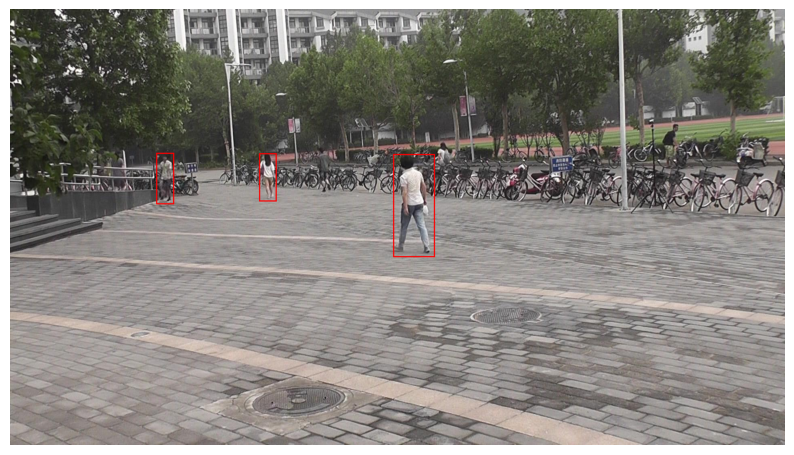

In [56]:
# Take a random img from the test set and evaluate it
# INFERENCE MODE
model = model.to(device).eval()

# rnd idx from test set
idx = np.random.randint(len(test_ds))
img = test_ds[idx][0].to(device)

# pred. the bboxes and their obj. score
with torch.no_grad():
    pred = model([img])[0]
boxes  = pred["boxes"]  # anchor corrections
scores = pred["scores"] # objectness score

thresh = 0.5 # keepy only above thresh
keep = scores > thresh 
print(f"#bboxes predicted: {len(boxes)}")
print(f"#bboxes w/ score > {thresh}: {keep.sum().item()}")

# draw bboxes
img_drawn = draw_bboxes(
    img_tensor=img,              
    boxes=boxes[keep],            # Nx4 (xyxy)
    scores=scores[keep],          # top bboxes
    thr=0.0,                      # another thresh 
    topk=None
)
# plot
plt.figure(figsize=(10,6))
plt.imshow(img_drawn)
plt.axis("off")
plt.show()

### Metrics

In [38]:
@torch.no_grad() # just inference, no gradient flowing
def build_dets_by_index(model, dataset, device, score_thresh=0.2, max_det=200):
    '''
    Function to compute predictions for the given set (e.g. test set)
    '''
    model.eval()
    out = [] # list of predictions for each img
    for i in range(len(dataset)):
        img, _ = dataset[i]
        img = img.to(device)
        pred = model([img])[0]
        boxes, scores = pred["boxes"], pred["scores"]
        keep = scores >= score_thresh # keep only above thresh
        boxes, scores = boxes[keep], scores[keep]
        if max_det is not None and boxes.shape[0] > max_det: # num. detections
            idx = scores.argsort(descending=True)[:max_det] # keep only the first max_det detections
            boxes, scores = boxes[idx], scores[idx] # selecting them
        det = torch.cat([boxes, scores[:,None]], 1).cpu().numpy().astype(np.float32) # concat.
        out.append(det) # append predicted bboxes to each image
    return out

# compute test predictions
#test_detections = build_dets_by_index(model,  test_ds,      device, score_thresh=0.2)
#train_detections = build_dets_by_index(model, det_train_ds, device, score_thresh=0.2)

In [47]:
# save test_detections
with open("test_preds.pkl", "wb") as fp:
    pickle.dump(test_detections, fp)

with open("train_preds.pkl", "wb") as fp:
    pickle.dump(train_detections, fp)

In [12]:
# load predictions
with open("/kaggle/input/detection-weights/test_preds.pkl", "rb") as fp:
    test_detections = pickle.load(fp)

# load predictions
with open("/kaggle/input/detection-weights/train_preds.pkl", "rb") as fp:
    train_detections = pickle.load(fp)

In [13]:
# sanity check
num_detections = [test_detections[i].shape[0] for i in range(len(test_detections))]
print(f"Total test detections: {len(test_detections)}")  # should be len(test_ds)
print("Per-img")
print("- min num_det:", min(num_detections))
print("- mean num_det:", int(sum(num_detections) / len(num_detections)))
print("- max num_det:", max(num_detections))

# sanity check
num_detections = [train_detections[i].shape[0] for i in range(len(train_detections))]
print(f"\nTotal val detections: {len(train_detections)}")  # should be len(test_ds)
print("Per-img")
print("- min num_det:", min(num_detections))
print("- mean num_det:", int(sum(num_detections) / len(num_detections)))
print("- max num_det:", max(num_detections))

Total test detections: 6112
Per-img
- min num_det: 1
- mean num_det: 5
- max num_det: 23

Total val detections: 5704
Per-img
- min num_det: 1
- mean num_det: 3
- max num_det: 14


In [39]:
def compute_ap_voc(recall, precision):
    """
    VOC2010+ style AP:
    - add sentinel endpoints
    - build precision envelope
    - integrate area under PR curve
    """
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # precision envelope
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    # integrate where recall changes
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return float(ap)

def _compute_iou_xyxy(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    inter = max(0.0, x2 - x1) * max(0.0, y2 - y1)
    area_a = max(0.0, a[2] - a[0]) * max(0.0, a[3] - a[1])
    area_b = max(0.0, b[2] - b[0]) * max(0.0, b[3] - b[1])
    union = area_a + area_b - inter
    return 0.0 if union <= 0 else inter / union

def eval_detection_prw_canonical_ap(
    dataset,
    dets,                      # list len N, each (M,5) [x1,y1,x2,y2,score]
    det_thresh=0.0,
    iou_thresholds=(0.5,),
    include_distractors=True,
):
    assert len(dataset) == len(dets)

    # --- cache GT per image ---
    gt_boxes_per_img = []
    n_gt_total = 0
    for i in range(len(dataset)):
        _, tgt = dataset[i]
        gt = tgt["boxes"].detach().cpu().numpy().astype(np.float32).reshape(-1, 4)

        if not include_distractors and "person_id" in tgt:
            pid = tgt["person_id"].detach().cpu().numpy()
            gt = gt[pid > 0]

        gt_boxes_per_img.append(gt)
        n_gt_total += len(gt)

    results = {"n_gt": int(n_gt_total), "per_iou": {}}

    # --- collect detections globally ---
    # each entry: (score, img_idx, box[4])
    all_dets = []
    for img_idx in range(len(dataset)):
        det = np.asarray(dets[img_idx], dtype=np.float32).reshape(-1, 5)
        if det.size == 0:
            continue
        keep = det[:, 4] >= det_thresh
        det = det[keep]
        for d in det:
            all_dets.append((float(d[4]), img_idx, d[:4].astype(np.float32)))

    # sort once globally (canonical)
    all_dets.sort(key=lambda x: x[0], reverse=True)

    for iou_t in iou_thresholds:
        if n_gt_total == 0:
            results["per_iou"][float(iou_t)] = {
                "AP": 0.0, "precision": 0.0, "recall": 0.0,
                "tp": 0, "fp": 0
            }
            continue

        # matched flags per GT, per image
        matched = [np.zeros(len(gt_boxes_per_img[i]), dtype=bool) for i in range(len(dataset))]

        tp = np.zeros(len(all_dets), dtype=np.int32)
        fp = np.zeros(len(all_dets), dtype=np.int32)

        for k, (score, img_idx, box_d) in enumerate(all_dets):
            gt = gt_boxes_per_img[img_idx]
            if len(gt) == 0:
                fp[k] = 1
                continue

            # find best unmatched GT in this image
            best_iou = 0.0
            best_j = -1
            for j in range(len(gt)):
                if matched[img_idx][j]:
                    continue
                iou = _compute_iou_xyxy(box_d, gt[j])
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= iou_t and best_j >= 0:
                tp[k] = 1
                matched[img_idx][best_j] = True
            else:
                fp[k] = 1

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        recall = tp_cum / float(n_gt_total)
        precision = tp_cum / np.maximum(1.0, (tp_cum + fp_cum))

        ap = compute_ap_voc(recall, precision)

        results["per_iou"][float(iou_t)] = {
            "AP": float(ap),
            "precision": float(precision[-1]) if len(precision) else 0.0,
            "recall": float(recall[-1]) if len(recall) else 0.0,
            "tp": int(tp_cum[-1]) if len(tp_cum) else 0,
            "fp": int(fp_cum[-1]) if len(fp_cum) else 0,
            "n_det": int(len(all_dets)),
        }

    aps = [results["per_iou"][t]["AP"] for t in results["per_iou"]]
    results["mAP"] = float(np.mean(aps)) if len(aps) else 0.0
    return results

In [40]:
# run metrics
det_metrics = eval_detection_prw_canonical_ap(
    dataset=test_ds,
    dets=test_detections,
    det_thresh=0.05,
    iou_thresholds=(0.5, 0.75),
    include_distractors=True
)
print(det_metrics)

{'n_gt': 19116, 'per_iou': {0.5: {'AP': 0.8611808478487347, 'precision': 0.586312146003776, 'recall': 0.9747332077840553, 'tp': 18633, 'fp': 13147, 'n_det': 31780}, 0.75: {'AP': 0.7038271776584106, 'precision': 0.502863436123348, 'recall': 0.8360012554927809, 'tp': 15981, 'fp': 15799, 'n_det': 31780}}, 'mAP': 0.7825040127535727}


> The detection produces very good results: in particular, for this kind of task, we are interested in **recall**, since we want as many detections as possible, and the model responds well with a *0.96*.

## Re-IDentification

In [14]:
from typing import Optional, Callable, Dict, List, Tuple
from torch.cuda.amp import GradScaler
from torch.amp import autocast
from typing import Callable

import torchvision.transforms as T
import torchvision.transforms.functional as FT
import math
import time
import re
import torch
import torch.nn.functional as F
import random, numpy as np
import torchvision.models as models

In [15]:
def parse_cam_id_from_stem(stem: str) -> int:
    """
    PRW frame names look like: c1s3_016471 (stem)
    We parse 'c1' -> cam_id=1
    """
    m = re.match(r"c(\d+)", stem)
    if not m:
        raise ValueError(f"Cannot parse cam_id from stem: {stem}")
    return int(m.group(1))


def clip_box_xyxy(box: np.ndarray, w: int, h: int) -> np.ndarray:
    x1, y1, x2, y2 = box
    x1 = float(np.clip(x1, 0, w - 1))
    y1 = float(np.clip(y1, 0, h - 1))
    x2 = float(np.clip(x2, 0, w - 1))
    y2 = float(np.clip(y2, 0, h - 1))
    x1, x2 = min(x1, x2), max(x1, x2)
    y1, y2 = min(y1, y2), max(y1, y2)
    return np.array([x1, y1, x2, y2], dtype=np.float32)


def expand_and_jitter_box_xyxy(
    box: np.ndarray,
    img_w: int,
    img_h: int,
    expand_ratio: float = 0.2,
    jitter_ratio: float = 0.05,
    do_jitter: bool = True,
) -> np.ndarray:
    x1, y1, x2, y2 = box.astype(np.float32)
    bw, bh = (x2 - x1), (y2 - y1)
    cx, cy = x1 + 0.5 * bw, y1 + 0.5 * bh

    # expand
    bw2 = bw * (1.0 + expand_ratio)
    bh2 = bh * (1.0 + expand_ratio)

    if do_jitter:
        cx += (random.uniform(-1, 1) * jitter_ratio) * bw
        cy += (random.uniform(-1, 1) * jitter_ratio) * bh
        scale = 1.0 + random.uniform(-jitter_ratio, jitter_ratio)
        bw2 *= scale
        bh2 *= scale

    nx1 = cx - 0.5 * bw2
    ny1 = cy - 0.5 * bh2
    nx2 = cx + 0.5 * bw2
    ny2 = cy + 0.5 * bh2
    return clip_box_xyxy(np.array([nx1, ny1, nx2, ny2], dtype=np.float32), img_w, img_h)


def load_id_list(mat_path: Path, key: str) -> List[int]:
    d = scipy.io.loadmat(mat_path)
    if key not in d:
        raise KeyError(f"Key '{key}' not found in {mat_path}. Keys: {list(d.keys())}")
    arr = np.asarray(d[key]).reshape(-1)
    return [int(x) for x in arr]


class PRWReIDDatasetCE(Dataset):
    """
    Crops GT boxes from the PRW_dataset and returns:
      crop_tensor, label (0..C-1), pid, camid

    CE needs contiguous labels.
    """

    def __init__(
        self,
        prw_det_ds,                                # the PRW_dataset(split="train" or "test")
        crop_transform: Optional[Callable] = None,
        id_train_mat: Optional[Path] = None,       # e.g. ID_train.mat (recommended for training)
        id_test_mat: Optional[Path] = None,        # e.g. ID_test.mat (recommended for test eval)
        split: str = "train",                      # "train" or "test" just for ID filtering
        filter_invalid_ids: bool = True,           # ignore pid <= 0
        min_box_size: int = 10,
        expand_ratio: float = 0.2,
        jitter_ratio: float = 0.05,
        jitter: bool = True,
    ):
        self.base = prw_det_ds
        self.crop_transform = crop_transform
        self.filter_invalid_ids = filter_invalid_ids
        self.min_box_size = min_box_size
        self.expand_ratio = expand_ratio
        self.jitter_ratio = jitter_ratio
        self.jitter = jitter

        split = split.lower()
        assert split in {"train", "test"}
        self.split = split

        # Optional: restrict to train/test IDs based on provided mats
        allowed_ids = None
        if split == "train" and id_train_mat is not None:
            # common key name in PRW releases is "ID_train"
            allowed_ids = set(load_id_list(id_train_mat, "ID_train"))
        if split == "test" and id_test_mat is not None:
            allowed_ids = set(load_id_list(id_test_mat, "ID_test2"))

        self.samples: List[Dict] = []
        for base_idx, (img_path, ann_path) in enumerate(self.base.pairs):
            boxes_np, ids_np = self.base.box_cache[str(ann_path)]
            if boxes_np is None or len(boxes_np) == 0:
                continue

            if self.filter_invalid_ids:
                keep = ids_np > 0
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            if allowed_ids is not None:
                keep = np.array([pid in allowed_ids for pid in ids_np], dtype=bool)
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            stem = Path(img_path).stem
            camid = parse_cam_id_from_stem(stem)

            for b, pid in zip(boxes_np, ids_np):
                x1, y1, x2, y2 = b.tolist()
                if (x2 - x1) < self.min_box_size or (y2 - y1) < self.min_box_size:
                    continue
                self.samples.append(
                    {
                        "img_path": str(img_path),
                        "bbox": b.astype(np.float32),
                        "pid": int(pid),
                        "camid": int(camid),
                    }
                )

        # CE needs contiguous labels
        self.pids = sorted({s["pid"] for s in self.samples})
        self.pid2label = {pid: i for i, pid in enumerate(self.pids)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i: int):
        s = self.samples[i]
        img = Image.open(s["img_path"]).convert("RGB")
        W, H = img.size

        box = expand_and_jitter_box_xyxy(
            s["bbox"], W, H,
            expand_ratio=self.expand_ratio,
            jitter_ratio=self.jitter_ratio,
            do_jitter=self.jitter,
        )

        x1, y1, x2, y2 = box
        crop = img.crop((x1, y1, x2, y2))

        if self.crop_transform is not None:
            crop = self.crop_transform(crop)
        else:
            crop = FT.to_tensor(crop)

        pid = s["pid"]
        label = self.pid2label[pid]
        camid = s["camid"]

        return crop, torch.tensor(label, dtype=torch.long), torch.tensor(pid), torch.tensor(camid)

In [16]:
# Performing augmentation just on training bboxes
train_reid_tf = T.Compose([
    T.Resize((256, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_reid_tf = T.Compose([
    T.Resize((256, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [49]:
# Train on GT bboxes
train_reid_ds = PRWReIDDatasetCE(
    train_view,
    crop_transform=train_reid_tf,
    split="train",
    filter_invalid_ids=True,
    id_train_mat=None, 
)

val_reid_ds = PRWReIDDatasetCE(
    val_view,
    crop_transform=test_reid_tf,
    split="train",
    filter_invalid_ids=True,
    id_train_mat=None,
)

In [50]:
# Loading data
train_reid_loader = DataLoader(
    train_reid_ds,
    batch_size=64,
    shuffle=True,
    num_workers=4,            
    pin_memory=True,
    persistent_workers=True,  # it makes sense only if num_workers>0
    prefetch_factor=2         # default is 2
)

val_reid_loader = DataLoader(
    val_reid_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,            
    pin_memory=True,
    persistent_workers=True,  # it makes sense only if num_workers>0
    prefetch_factor=2         # default is 2
)

### Evaluation functions

In [17]:
from scipy.io import loadmat
from sklearn.metrics import average_precision_score
from dataclasses import dataclass

import os.path as osp

#### Original evaluation function

In [18]:
# This is a minimally modified version of the eval function from the SeqNet repository (https://github.com/serend1p1ty/SeqNet/blob/master/eval_func.py)
# Changes:
# - Removed code related to CBGM (Context Bipartite Graph Matching)
# - Adjusted top-k accuracy calculation to only consider top-1 accuracy
# - Clarified function docstring and added recall rate scaling explanation

def _compute_iou(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    union = (a[2] - a[0]) * (a[3] - a[1]) + (b[2] - b[0]) * (b[3] - b[1]) - inter
    return inter * 1.0 / union

def eval_search_prw(
    gallery_dataset,
    query_dataset,
    gallery_dets,
    gallery_feats,
    query_box_feats,
    det_thresh,
    ignore_cam_id=True,
):
    """
    Evaluate person search performance on PRW dataset.

    Args:
        gallery_dataset (Dataset): dataset containing gallery images.
        query_dataset (Dataset): dataset containing query images.
        gallery_dets (list of ndarray): n_det x [x1, x2, y1, y2, score] per image. 
        gallery_feats (list of ndarray): n_det x D features per image.
        query_box_feats (list of ndarray): D dimensional features per query image.
        det_thresh (float): filter out gallery detections whose scores below this.
        ignore_cam_id (bool): whether to ignore camera ID during evaluation. If set to False,
                            gallery images from the same camera as the query will be excluded. Default: True.
    """
    assert len(gallery_dataset) == len(gallery_dets)
    assert len(gallery_dataset) == len(gallery_feats)
    assert len(query_dataset) == len(query_box_feats)

    annos = gallery_dataset.annotations
    name_to_det_feat = {}
    for anno, det, feat in zip(annos, gallery_dets, gallery_feats):
        name = anno["img_name"]
        scores = det[:, 4].ravel()
        inds = np.where(scores >= det_thresh)[0]
        if len(inds) > 0:
            name_to_det_feat[name] = (det[inds], feat[inds])

    aps = []
    accs = []
    topk = [1] # we are only interested in top-1 accuracy
    ret = {"image_root": gallery_dataset.img_prefix, "results": []}
    for i in range(len(query_dataset)):
        y_true, y_score = [], []
        imgs, rois = [], []
        count_gt, count_tp = 0, 0

        feat_p = query_box_feats[i].ravel()

        query_imname = query_dataset.annotations[i]["img_name"]
        query_roi = query_dataset.annotations[i]["boxes"]
        query_pid = query_dataset.annotations[i]["pids"]
        query_cam = query_dataset.annotations[i]["cam_id"]

        # Find all occurence of this query
        gallery_imgs = []
        for x in annos:
            if query_pid in x["pids"] and x["img_name"] != query_imname:
                gallery_imgs.append(x)
        query_gts = {}
        for item in gallery_imgs:
            query_gts[item["img_name"]] = item["boxes"][item["pids"] == query_pid]

        # Construct gallery set for this query
        if ignore_cam_id:
            gallery_imgs = []
            for x in annos:
                if x["img_name"] != query_imname:
                    gallery_imgs.append(x)
        else:
            gallery_imgs = []
            for x in annos:
                if x["img_name"] != query_imname and x["cam_id"] != query_cam:
                    gallery_imgs.append(x)

        name2sim = {}
        sims = []
        # 1. Go through all gallery samples
        for item in gallery_imgs:
            gallery_imname = item["img_name"]
            # some contain the query (gt not empty), some not
            count_gt += gallery_imname in query_gts
            # compute distance between query and gallery dets
            if gallery_imname not in name_to_det_feat:
                continue
            det, feat_g = name_to_det_feat[gallery_imname]
            # get L2-normalized feature matrix NxD
            #assert feat_g.size == np.prod(feat_g.shape[:2])
            #feat_g = feat_g.reshape(feat_g.shape[:2])
            feat_g = np.asarray(feat_g).reshape(len(det), -1)   # (Nd, D)
            feat_p = np.asarray(feat_p).reshape(-1)            # (D,)
            # compute cosine similarities
            sim = feat_g.dot(feat_p).ravel()

            if gallery_imname in name2sim:
                continue
            name2sim[gallery_imname] = sim
            sims.extend(list(sim))

        for gallery_imname, sim in name2sim.items():
            det, feat_g = name_to_det_feat[gallery_imname]
            # assign label for each det
            label = np.zeros(len(sim), dtype=np.int32)
            if gallery_imname in query_gts:
                gt = query_gts[gallery_imname].ravel()
                w, h = gt[2] - gt[0], gt[3] - gt[1]
                iou_thresh = min(0.5, (w * h * 1.0) / ((w + 10) * (h + 10)))
                inds = np.argsort(sim)[::-1]
                sim = sim[inds]
                det = det[inds]
                # only set the first matched det as true positive
                for j, roi in enumerate(det[:, :4]):
                    if _compute_iou(roi, gt) >= iou_thresh:
                        label[j] = 1
                        count_tp += 1
                        break
            y_true.extend(list(label))
            y_score.extend(list(sim))
            imgs.extend([gallery_imname] * len(sim))
            rois.extend(list(det))

        # 2. Compute AP for this query (need to scale by recall rate)
        y_score = np.asarray(y_score)
        y_true = np.asarray(y_true)
        assert count_tp <= count_gt
        # Important: at the pedestrian detection stage, the model might have missed the person (failed to detect a box with IoU > 0.5).
        # To penalize the model for these False Negatives at the detection stage, scale the AP by recall (the ratio of found matches to total ground truth matches). 
        # E.g. if the detector missed the person entirely 50% of the time, the final AP score is cut in half.
        recall_rate = 0.0 if count_gt == 0 else (count_tp * 1.0 / count_gt)
        ap = 0 if count_tp == 0 else average_precision_score(y_true, y_score) * recall_rate
        #ap = 0 if count_tp == 0 else average_precision_score(y_true, y_score) # easier case

        
        aps.append(ap)
        inds = np.argsort(y_score)[::-1]
        y_score = y_score[inds]
        y_true = y_true[inds]
        accs.append([min(1, sum(y_true[:k])) for k in topk])
        # 4. Save result for JSON dump
        new_entry = {
            "query_img": str(query_imname),
            "query_roi": list(map(float, list(query_roi.squeeze()))),
            "query_gt": query_gts,
            "gallery": [],
        }
        # only save top-10 predictions
        for k in range(10):
            new_entry["gallery"].append(
                {
                    "img": str(imgs[inds[k]]),
                    "roi": list(map(float, list(rois[inds[k]]))),
                    "score": float(y_score[k]),
                    "correct": int(y_true[k]),
                }
            )
        ret["results"].append(new_entry)

    print("search ranking:")
    mAP = np.mean(aps)
    print("  mAP = {:.2%}".format(mAP))
    accs = np.mean(accs, axis=0)
    for i, k in enumerate(topk):
        print("  top-{:2d} = {:.2%}".format(k, accs[i]))

    # write_json(ret, "vis/results.json")

    ret["mAP"] = np.mean(aps)
    ret["accs"] = accs
    return ret

#### Utilities

In [19]:
def load_prw_query_info_pid_xywh_imglast(query_info_path):
    queries = []
    with open(query_info_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            pid_s, x_s, y_s, w_s, h_s, stem = line.split()
            pid = int(pid_s)
            x, y, w, h = map(float, (x_s, y_s, w_s, h_s))
            x1, y1, x2, y2 = x, y, x + w, y + h
            queries.append({
                "pid": pid,
                "stem": stem,  # c1s3_016471
                "img_name": stem + ".jpg",
                "box_xyxy": np.array([x1, y1, x2, y2], dtype=np.float32),
                "cam_id": parse_cam_id_from_stem(stem),
            })
    return queries

@dataclass
class SimpleQueryDataset:
    annotations: list
    img_prefix: str = ""
    def __len__(self): return len(self.annotations)

def build_query_dataset_from_query_info(query_info_path):
    queries = load_prw_query_info_pid_xywh_imglast(query_info_path)
    ann = []
    for q in queries:
        ann.append({
            "img_name": q["img_name"],
            "boxes": q["box_xyxy"][None, :],
            "pids": np.array([q["pid"]], dtype=np.int32),
            "cam_id": int(q["cam_id"]),
        })
    return SimpleQueryDataset(annotations=ann, img_prefix="")

In [20]:
def forward_embed(model, batch):
    'Call this to ignore logits but consider the embedding.'
    out = model(batch)
    if isinstance(out, (tuple, list)) and len(out) == 2:
        logits, emb = out
        return emb              # <-- 512
    return out                  # fallback: model returns embedding directly

@torch.no_grad()
def compute_query_box_feats_from_querybox(
    reid_model,
    query_info_path,
    query_box_dir,
    transform,
    device,
):
    reid_model.eval()
    queries = load_prw_query_info_pid_xywh_imglast(query_info_path)

    feats = []
    for q in queries:
        pid = q["pid"]
        stem = q["stem"]
        path = osp.join(query_box_dir, f"{pid}_{stem}.jpg")
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)

        emb = forward_embed(reid_model, x)             # <-- 512
        emb = F.normalize(emb, p=2, dim=1)             # useful as sanity check
        feats.append(emb.squeeze(0).detach().cpu().numpy().astype(np.float32))

    return feats

In [21]:
@torch.no_grad()
def build_gallery_feats_from_dets_prw_dataset(
    reid_model,
    prw_dataset,
    detections,
    transform,
    device,
):
    reid_model.eval()
    gallery_feats = []
    assert len(prw_dataset) == len(detections)

    for idx in range(len(prw_dataset)):
        img_path, _ = prw_dataset.pairs[idx]
        img = Image.open(img_path).convert("RGB")

        det = detections[idx]
        if det.shape[0] == 0:
            gallery_feats.append(np.zeros((0, 1), dtype=np.float32))
            continue

        feats_img = []
        for box in det:
            x1, y1, x2, y2 = box[:4]
            x1, y1, x2, y2 = map(int, map(round, (x1, y1, x2, y2)))
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = max(x1 + 1, x2), max(y1 + 1, y2)

            crop = img.crop((x1, y1, x2, y2))
            x = transform(crop).unsqueeze(0).to(device)

            emb = forward_embed(reid_model, x)         # <-- 512
            emb = F.normalize(emb, p=2, dim=1)         # useful for sanity check
            feats_img.append(emb.squeeze(0).detach().cpu().numpy())

        gallery_feats.append(np.vstack(feats_img).astype(np.float32))

    # fix empty dim
    D = None
    for f in gallery_feats:
        if f.shape[0] > 0:
            D = f.shape[1]
            break
    if D is None:
        raise ValueError("All gallery feats are empty (no detections?).")
    for i, f in enumerate(gallery_feats):
        if f.shape[0] == 0 and f.shape[1] != D:
            gallery_feats[i] = np.zeros((0, D), dtype=np.float32)

    return gallery_feats

In [22]:
@dataclass
class PRWGalleryForEval:
    annotations: list
    img_prefix: str

    def __len__(self):
        return len(self.annotations)

def build_gallery_eval_view(prw_dataset):
    """
    Create a lightweight object with .annotations and .img_prefix
    compatible with your eval_search_prw.
    """
    annos = []
    # img_prefix: parent dir of frames
    # pairs[idx][0] is .../frames/c1s3_016471.jpg
    # so prefix is .../frames
    img_prefix = str(prw_dataset.pairs[0][0].parent)

    for idx, (img_path, ann_path) in enumerate(prw_dataset.pairs):
        stem = img_path.stem              # c1s3_016471
        img_name = img_path.name          # c1s3_016471.jpg

        boxes_np, ids_np = prw_dataset.box_cache[str(ann_path)]  # GT xyxy + ids

        # IMPORTANT: filter_invalid_ids should match your evaluation assumptions
        # In PRW person search, -2 are distractors; for GT "occurrence" of query person,
        # you typically want ids>0 only.
        keep = ids_np > 0
        boxes = boxes_np[keep]
        pids = ids_np[keep]

        cam_id = parse_cam_id_from_stem(stem)

        annos.append({
            "img_name": img_name,  # must match exactly what eval expects
            "boxes": boxes.astype(np.float32),
            "pids": pids.astype(np.int32),
            "cam_id": cam_id,
        })

    return PRWGalleryForEval(annotations=annos, img_prefix=img_prefix)

In [23]:
@torch.no_grad()
def evaluate_checkpoint_prw(
    ckpt_path,
    model,
    query_ds,
    gallery_eval,
    test_ds,
    test_detections,
    test_reid_tf,
    device,
):
    def _fmt_pct(x):
        x = float(x)
        return f"{x:.2f}%" if x > 1.0 else f"{100*x:.2f}%"

    def _extract_map_top1(ret):
        # --- mAP ---
        map_val = ret.get("mAP", ret.get("map", ret.get("MAP", None)))

        # --- top-1 (rank-1) ---
        top1_val = None
        accs = ret.get("accs", None)

        if isinstance(accs, (list, tuple)):
            if len(accs) > 0:
                top1_val = accs[0]
        elif hasattr(accs, "shape"):  # numpy array / torch tensor
            try:
                # numpy
                if getattr(accs, "size", 0) > 0:
                    top1_val = accs[0]
            except Exception:
                # torch tensor fallback
                if accs.numel() > 0:
                    top1_val = accs.flatten()[0].item()
        elif isinstance(accs, dict):
            for k in ["top1", "top-1", "rank1", "r1", "acc1"]:
                if k in accs:
                    top1_val = accs[k]
                    break

        return map_val, top1_val

    print(f"\n[Eval] Loading checkpoint: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device)

    state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt

    model.load_state_dict(state_dict, strict=True)
    model.to(device)
    model.eval()

    query_feats = compute_query_box_feats_from_querybox(
        reid_model=model,
        query_info_path="/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt",
        query_box_dir="/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
        transform=test_reid_tf,
        device=device,
    )

    gallery_feats = build_gallery_feats_from_dets_prw_dataset(
        reid_model=model,
        prw_dataset=test_ds,
        detections=test_detections,
        transform=test_reid_tf,
        device=device,
    )

    ret = eval_search_prw(
        gallery_dataset=gallery_eval,
        query_dataset=query_ds,
        gallery_dets=test_detections,
        gallery_feats=gallery_feats,
        query_box_feats=query_feats,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    map_val, top1_val = _extract_map_top1(ret)

    if map_val is not None and top1_val is not None:
        print(f"[Eval] {ckpt_path} → mAP={_fmt_pct(map_val)} | top-1={_fmt_pct(top1_val)}")
    else:
        print(f"[Eval] {ckpt_path} → cannot find mAP/top-1 in ret. keys={list(ret.keys())}")

    return ret

In [51]:
# 1) Build gallery view for eval (GT annos etc.)
gallery_eval = build_gallery_eval_view(test_ds)

# 2) Build query dataset from query_info (metadata only)
query_ds = build_query_dataset_from_query_info(
    "/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt"
)

### Training utils

In [52]:
# Defining hyperparams
emb_dim = 512
n_epochs = 20
num_classes = len(train_reid_ds.pids)

# optimizer params
lr = 3e-4
weight_decay = 1e-4

# setup device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# setup training
use_amp = (device == "cuda")          
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

In [55]:
# sanity check
len(train_reid_ds.pids) # num. train samples for re-id (331 IDs for 85% view (originally 483))

331

#### Validation utils

In [53]:
# forward_embed must exist in your codebase (you already use it in gallery feats)
# from your_module import forward_embed

# =========================
# 1) SeqNet-like dataset wrapper (what eval_search_prw expects)
# =========================
@dataclass
class SeqNetLikeDataset:
    img_prefix: str                 # root folder for images (string)
    annotations: List[Dict[str, Any]]  # list of dicts: img_name, boxes, pids, cam_id
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        return self.annotations[idx]

# =========================
# 2) Utility: parse cam_id from PRW filename
#    PRW: "c1s1_000151.jpg" -> cam_id = 1
# =========================
def cam_id_from_prw_name(img_name: str) -> int:
    stem = img_name[:-4] if img_name.endswith(".jpg") else img_name
    if stem.startswith("c") and "s" in stem:
        try:
            return int(stem[1:stem.index("s")])
        except Exception:
            return -1
    return -1

# =========================
# 3) Build GALLERY eval dataset from your PRW_dataset
#    IMPORTANT: preserves the SAME order as gallery_ds.pairs, so it matches detections[idx]
# =========================
def build_gallery_eval_from_prw(gallery_ds, img_prefix: str) -> SeqNetLikeDataset:
    ann = []
    for idx in range(len(gallery_ds)):
        img_path, ann_path = gallery_ds.pairs[idx]
        boxes, pids = gallery_ds.box_cache[str(ann_path)]

        ann.append({
            "img_name": img_path.name,                         # must match what eval_search_prw uses
            "boxes": np.asarray(boxes, dtype=np.float32),       # (N,4) xyxy
            "pids":  np.asarray(pids,  dtype=np.int64),         # (N,)
            "cam_id": cam_id_from_prw_name(img_path.name),
        })
    return SeqNetLikeDataset(img_prefix=str(img_prefix), annotations=ann)


# =========================
# 4) Build QUERY eval dataset for VALIDATION (custom queries):
#    One query per PID, chosen as the largest GT box (more stable).
#    This uses val_view (GT-filtered view with allowed_pids=val_ids, drop_empty=True).
# =========================
def build_query_eval_from_val_view_one_per_pid(val_view, img_prefix: str) -> SeqNetLikeDataset:
    # pid -> (area, img_name, box_1x4, cam_id)
    best = {}

    for idx in range(len(val_view)):
        img_path, ann_path = val_view.pairs[idx]
        boxes, pids = val_view.box_cache[str(ann_path)]
        cam = cam_id_from_prw_name(img_path.name)

        for box, pid in zip(boxes, pids):
            pid = int(pid)
            if pid <= 0:
                continue
            x1, y1, x2, y2 = map(float, box)
            area = max(0.0, x2 - x1) * max(0.0, y2 - y1)

            if (pid not in best) or (area > best[pid][0]):
                best[pid] = (area, img_path.name, np.asarray([box], dtype=np.float32), cam)

    # Build query annotations in deterministic PID order
    query_ann = []
    for pid in sorted(best.keys()):
        _, img_name, box_1x4, cam = best[pid]
        query_ann.append({
            "img_name": img_name,
            "boxes": box_1x4,          # (1,4) xyxy
            "pids": int(pid),          # IMPORTANT: scalar int (your eval does "if query_pid in x['pids']")
            "cam_id": cam,
        })

    return SeqNetLikeDataset(img_prefix=str(img_prefix), annotations=query_ann)


# =========================
# 5) Compute QUERY features from query_eval (PIL crop + transform, same style as gallery feats)
#    Returns: list of (D,) arrays, aligned with query_eval.annotations order.
# =========================
@torch.no_grad()
def build_query_feats_from_query_eval(
    reid_model,
    query_eval: SeqNetLikeDataset,
    transform,
    device: str,
) -> List[np.ndarray]:
    reid_model.eval()
    feats = []

    for q in query_eval.annotations:
        img_path = f"{query_eval.img_prefix}/{q['img_name']}"
        img = Image.open(img_path).convert("RGB")

        box = np.asarray(q["boxes"], dtype=np.float32).reshape(-1, 4)[0]
        x1, y1, x2, y2 = box.tolist()
        x1, y1, x2, y2 = map(int, map(round, (x1, y1, x2, y2)))
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = max(x1 + 1, x2), max(y1 + 1, y2)

        crop = img.crop((x1, y1, x2, y2))
        x = transform(crop).unsqueeze(0).to(device)

        emb = forward_embed(reid_model, x)     # must return (1,D)
        emb = F.normalize(emb, p=2, dim=1)     # consistent with gallery
        feats.append(emb.squeeze(0).detach().cpu().numpy().astype(np.float32))

    return feats


# =========================
# 6) Optional safety check: ensure alignment between gallery_eval and detections
# =========================
def assert_gallery_alignment(gallery_eval: SeqNetLikeDataset, gallery_ds, detections):
    assert len(gallery_ds) == len(detections) == len(gallery_eval.annotations)
    for i in range(min(10, len(gallery_ds))):
        img_path, _ = gallery_ds.pairs[i]
        assert gallery_eval.annotations[i]["img_name"] == img_path.name, \
            f"Mismatch at {i}: eval={gallery_eval.annotations[i]['img_name']} vs ds={img_path.name}"


# =========================
# 7) Minimal "correct" evaluation entrypoint for VALIDATION
#    (use this for model selection)
# =========================
@torch.no_grad()
def eval_prw_validation_person_search(
    ckpt_path: str,
    model,
    val_view,          # GT-filtered view, allowed_pids=val_ids, drop_empty=True
    val_ds,            # gallery images dataset
    val_detections,    # list len = len(val_ds), each: Nd x [x1,y1,x2,y2,score,...]
    transform,         # PIL -> tensor
    device: str,
    det_thresh: float = 0.3,
    ignore_cam_id: bool = True,
):
    # ---- load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    print(f"\n[Eval] Loading checkpoint: {ckpt_path}")

    # ---- build eval datasets
    gallery_eval = build_gallery_eval_from_prw(val_ds, img_prefix=str(val_ds.pairs[0][0].parent))
    query_eval   = build_query_eval_from_val_view_one_per_pid(val_view, img_prefix=gallery_eval.img_prefix)

    # ----  alignment sanity check
    assert_gallery_alignment(gallery_eval, val_ds, val_detections)

    # ---- features
    query_feats   = build_query_feats_from_query_eval(model, query_eval, transform, device)
    gallery_feats = build_gallery_feats_from_dets_prw_dataset(model, val_ds, val_detections, transform, device)

    # ---- eval
    ret = eval_search_prw(
        gallery_dataset=gallery_eval,
        query_dataset=query_eval,
        gallery_dets=val_detections,
        gallery_feats=gallery_feats,
        query_box_feats=query_feats,
        det_thresh=det_thresh,
        ignore_cam_id=ignore_cam_id,
    )
    return ret

## Exploratory runs (considering test as val)

### Baseline: Softmax C.E. with Cosine similarity

We will use Cosine similarity to compare embeddings!
They will be L2-normalized and we will use a C.E. loss

In [25]:
class CosineClassifier(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, s: float = 30.0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_classes, in_dim))
        nn.init.normal_(self.weight, std=0.01)
        self.s = s

    def forward(self, x_normed: torch.Tensor, labels=None) -> torch.Tensor:
        # x_normed: already L2-normalized features (B, D)
        w = F.normalize(self.weight, dim=1)           # (C, D)
        logits = x_normed @ w.t()                     # cosine similarity
        return self.s * logits                        # scale for CE stability

In [26]:
class ReIDNet(nn.Module):
    def __init__(self, emb_dim: int, num_classes: int, s: float = 30.0):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # conv until layer4
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, emb_dim)
        self.cls = CosineClassifier(emb_dim, num_classes, s=s)

    def forward(self, x, labels=None):
        f = self.backbone(x)                   # (B,2048,H',W')
        f = self.pool(f).flatten(1)            # (B,2048)
        z = self.fc(f)                         # (B,emb_dim)
        z = F.normalize(z, dim=1)              # normalized embeddings
        logits = self.cls(z, labels=labels)    # scaled cosine logits
        return logits, z

In [24]:
# -------------------- MODEL --------------------
model_reid = ReIDNet(emb_dim=emb_dim, num_classes=num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()

# -------------------- OPTIMIZER (AdamW) --------------------
optimizer = torch.optim.AdamW(model_reid.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- SCHEDULER: warmup + cosine (per-iter) --------------------
steps_per_epoch = len(train_reid_loader)
total_steps = n_epochs * steps_per_epoch
warmup_steps = int(0.1 * total_steps)     # 10% warmup
min_lr_ratio = 0.01                       # lr finale = lr * 0.01

def lr_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)  # linear warmup 0->1
    t = (step - warmup_steps) / max(1, total_steps - warmup_steps)  # 0..1
    cosine = 0.5 * (1.0 + math.cos(math.pi * t))                    # 1..0
    return min_lr_ratio + (1.0 - min_lr_ratio) * cosine             # 1..min_lr_ratio

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "optimizer": "AdamW",
        "architecture": "ReIDNet",
        "dataset": "PRW",
        "epochs": n_epochs,
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
                  if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": "CE",
        "amp": use_amp,
        "scheduler": "warmup+cosine (LambdaLR, per-iter)",
        "warmup_ratio": 0.1,
        "min_lr_ratio": min_lr_ratio,
    },
    name=f"reid_r50_ce_20e_adamw_warmcos_amp_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
for epoch in range(n_epochs):
    model_reid.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops  = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        # forward + loss in autocast
        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model_reid(crops)
            loss = criterion(logits, labels)

        # backward + optimizer step with GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer) 
        scaler.update()

        # scheduler per-iter AFTER optimizer step
        scheduler.step()

        # -------------------- METRICS --------------------
        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()

        running_loss += loss_val
        running_acc1 += acc1

        # -------------------- WANDB LOG (per-step) --------------------
        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": optimizer.param_groups[0]["lr"],
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    # -------------------- EPOCH LOG --------------------
    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {
            "train/epoch_loss_avg": epoch_loss,
            "train/epoch_acc1_avg": epoch_acc1,
            "epoch": epoch,
        },
        step=global_step
    )
    print(f"[Epoch {epoch}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

# -------------------- SAVE CHECKPOINT --------------------
ckpt = {
    "model": model_reid.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "scaler": scaler.state_dict() if use_amp else None,
    "num_classes": num_classes,
    "emb_dim": emb_dim,
    "pid2label": train_reid_ds.pid2label,
    "config": {
        "lr": lr,
        "weight_decay": weight_decay,
        "n_epochs": n_epochs,
        "warmup_ratio": 0.1,
        "min_lr_ratio": min_lr_ratio,
        "use_amp": use_amp,
    }
}

torch.save(ckpt, "reid_20e_ckpt.pth")

artifact = wandb.Artifact("reid_20e_ckpt", type="model")
artifact.add_file("reid_20e_ckpt.pth")
wandb.log_artifact(artifact)


/tmp/ipykernel_55/4266526679.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


[Epoch 0] loss=5.1215 acc1=0.1592
[Epoch 1] loss=1.1890 acc1=0.7288
[Epoch 2] loss=0.2905 acc1=0.9298
[Epoch 3] loss=0.1124 acc1=0.9738
[Epoch 4] loss=0.0599 acc1=0.9889
[Epoch 5] loss=0.0375 acc1=0.9934
[Epoch 6] loss=0.0255 acc1=0.9958
[Epoch 7] loss=0.0147 acc1=0.9977
[Epoch 8] loss=0.0178 acc1=0.9972
[Epoch 9] loss=0.0105 acc1=0.9985
[Epoch 10] loss=0.0093 acc1=0.9989
[Epoch 11] loss=0.0061 acc1=0.9991
[Epoch 12] loss=0.0040 acc1=0.9997
[Epoch 13] loss=0.0028 acc1=0.9997
[Epoch 14] loss=0.0033 acc1=0.9996
[Epoch 15] loss=0.0017 acc1=1.0000
[Epoch 16] loss=0.0025 acc1=0.9997
[Epoch 17] loss=0.0019 acc1=0.9998
[Epoch 18] loss=0.0017 acc1=0.9999
[Epoch 19] loss=0.0015 acc1=0.9999


<Artifact reid_20e_ckpt>

#### Loading re-id model weights


In [29]:
# load weights
weights_reid_path = "/kaggle/input/reid-weights-5-epochs/reid_ckpt.pth"
ckpt_reid = torch.load(weights_reid_path, map_location="cpu")

# instantiate model
model_reid = ReIDNet(
    emb_dim=ckpt_reid["emb_dim"],
    num_classes=ckpt_reid["num_classes"]
)

# load weights into model
model_reid.load_state_dict(ckpt_reid["model"], strict=True)
model_reid.to(device)
model_reid.eval()   # inference mode 

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s] 


ReIDNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

#### Evaluation with metrics

In [107]:
# Evaluation: 5 epochs model
ret = eval_search_prw(
    gallery_dataset=gallery_eval,
    query_dataset=query_ds,
    gallery_dets=test_detections,
    gallery_feats=test_gallery_feats,
    query_box_feats=query_feats,
    det_thresh=0.3,
    ignore_cam_id=True, # simplyfing the problem: using same camera
)

search ranking:
  mAP = 41.39%
  top- 1 = 83.81%


In [30]:
# Compute query features from query_box (NO crop-from-frame)
query_feats = compute_query_box_feats_from_querybox(
    reid_model=model_reid,
    query_info_path="/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt",
    query_box_dir="/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
    transform=test_reid_tf,
    device=device,
)

# Compute gallery features aligned with detector outputs
test_gallery_feats = build_gallery_feats_from_dets_prw_dataset(
    reid_model=model_reid,
    prw_dataset=test_ds,
    detections=test_detections,
    transform=test_reid_tf,
    device=device,
)

print("query dim:", query_feats[0].shape)              # (512,)
print("gallery dim:", test_gallery_feats[0].shape)          # (N,512)
print({f.shape[1] for f in test_gallery_feats if f.shape[0] > 0})

query dim: (512,)
gallery dim: (4, 512)
{512}


> The obtained results are pretty good, compared to the ones in literature.

In [110]:
# ignore same camera imgs: 5 epochs model
ret = eval_search_prw(
    gallery_dataset=gallery_eval,
    query_dataset=query_ds,
    gallery_dets=test_detections,
    gallery_feats=test_gallery_feats,
    query_box_feats=query_feats,
    det_thresh=0.3,
    ignore_cam_id=False,
)

search ranking:
  mAP = 37.87%
  top- 1 = 65.34%


> The results with ignore_cam_id = False are worse because we are actually ignoring (excluding) gallery images from the same camera of the query. This means that we are removing **easy matches**, because images from the same camera have:
> * same illumination conditions;
> * same viewpoint and perspective;
> * same scale;
> * same background context;
> If ignore_cam_id was set equal to True, the resulting embeddings would have been called **shortcut features**.

In [31]:
# Evaluation: 20 epochs model
ret_20e = eval_search_prw(
        gallery_dataset=gallery_eval,
        query_dataset=query_ds,
        gallery_dets=test_detections,
        gallery_feats=test_gallery_feats,
        query_box_feats=query_feats,
        det_thresh=0.3,
        ignore_cam_id=True, # simplyfing the problem: using same camera
)

search ranking:
  mAP = 42.25%
  top- 1 = 83.86%


> We gained ~0.86% for mAP and the ~0.05% on the top-1 metric!
> It is a marginal improvement but still valuable and noteworthy.

### First attempt to improve performance
Up to now, we have achieved satisfying results with our baseline. The next natural question is: what can we improve to push performance further?

The most straightforward modification is to change the **loss** function. So far, we trained the Re-ID network by L2-normalizing the embeddings and optimizing a softmax cross-entropy loss, which encourages class separability but does not explicitly enforce compactness of embeddings belonging to the same identity.

To address this limitation, we introduce an angular **margin**, which explicitly enforces intra-class compactness and inter-class separation in the embedding space. This leads to margin-based losses such as **ArcFace**.

Before adopting ArcFace directly, we first experiment with its simpler variant, **CosFace**, which approximates ArcFace by subtracting a margin 𝑚 from the target class cosine similarity.

The key difference between the two lies in how the margin is applied:

* CosFace introduces an additive margin in the **cosine** similarity **space**;

* ArcFace enforces a margin **directly** in the **angular space**, resulting in a constant angular separation on the hypersphere.

#### CosFace

In [27]:
class CosFaceClassifier(nn.Module):
    def __init__(self, in_dim, num_classes, s=30.0, m=0.35):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_classes, in_dim))
        nn.init.normal_(self.weight, std=0.01)
        self.s = float(s)
        self.m = float(m)

    def forward(self, x_normed, labels=None):
        # x_normed: (B, D), already normalized
        w = F.normalize(self.weight, dim=1)     # (C, D)
        cosine = x_normed @ w.t()                 # (B, C)

        if labels is None:
            # inference
            return self.s * cosine

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        cosine_m = cosine - one_hot * self.m
        return self.s * cosine_m

class ReIDNetCosFace(nn.Module):
    def __init__(self, emb_dim, num_classes, s=30.0, m=0.35):
        super().__init__()
        backbone = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V2
        )
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, emb_dim)
        self.cls = CosFaceClassifier(emb_dim, num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        f = self.backbone(x)
        f = self.pool(f).flatten(1)
        z = self.fc(f)
        z = F.normalize(z, dim=1)

        logits = self.cls(z, labels=labels)
        return logits, z

#### no scheduler (diagnostic run)

In [43]:
# -------------------- LOSS --------------------
criterion = nn.CrossEntropyLoss()

# -------------------- MODEL --------------------
model_reid_cf = ReIDNetCosFace(emb_dim=emb_dim, num_classes=num_classes).to(device)

# -------------------- OPTIMIZER --------------------
optimizer = torch.optim.AdamW(model_reid_cf.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetCosFace",
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
        if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": "CosFace + CE",
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "scheduler": "NONE (constant LR)",
        "amp": use_amp,
        "save_every_epochs": 5,
    },
    name=f"reid_r50_cosface_20e_adamw_constlr_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_cf.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model_reid_cf(crops, labels=labels)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
            lr_now = optimizer.param_groups[0]["lr"]

        running_loss += loss_val
        running_acc1 += acc1

        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": lr_now,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
        step=global_step
    )
    print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

    # -------------------- SAVE CHECKPOINT EVERY N EPOCHS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_cosface_no_epoch{epoch+1:02d}.pth"
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_cf.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "num_classes": num_classes,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "lr": lr,
                "weight_decay": weight_decay,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "scheduler": "NONE",
            },
        }
        torch.save(ckpt, ckpt_path)

        artifact = wandb.Artifact(f"reid_cosface_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

/tmp/ipykernel_55/158538094.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


[Epoch 00] loss=10.5928 acc1=0.1339
[Epoch 01] loss=3.8810 acc1=0.4793
[Epoch 02] loss=1.9305 acc1=0.6962
[Epoch 03] loss=1.1689 acc1=0.7944
[Epoch 04] loss=0.7949 acc1=0.8533
[CKPT] Saved reid_cosface_no_epoch05.pth
[Epoch 05] loss=0.6024 acc1=0.8830
[Epoch 06] loss=0.4330 acc1=0.9144
[Epoch 07] loss=0.4047 acc1=0.9183
[Epoch 08] loss=0.3198 acc1=0.9388
[Epoch 09] loss=0.3338 acc1=0.9305
[CKPT] Saved reid_cosface_no_epoch10.pth
[Epoch 10] loss=0.3339 acc1=0.9342
[Epoch 11] loss=0.2548 acc1=0.9467
[Epoch 12] loss=0.2368 acc1=0.9524
[Epoch 13] loss=0.2390 acc1=0.9555
[Epoch 14] loss=0.2338 acc1=0.9528
[CKPT] Saved reid_cosface_no_epoch15.pth
[Epoch 15] loss=0.2484 acc1=0.9513
[Epoch 16] loss=0.2748 acc1=0.9475
[Epoch 17] loss=0.2451 acc1=0.9529
[Epoch 18] loss=0.2167 acc1=0.9581
[Epoch 19] loss=0.1983 acc1=0.9604
[CKPT] Saved reid_cosface_no_epoch20.pth
[FINAL] Saved reid_20e_cosface_final_no.pth


#### with lr scheduler

In [38]:
# -------------------- LOSS (label smoothing) --------------------
label_smoothing = 0.1
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# -------------------- MODEL --------------------
model_reid_cf = ReIDNetCosFace(emb_dim=emb_dim, num_classes=num_classes).to(device)

# -------------------- OPTIMIZER (higher weight decay) --------------------
optimizer = torch.optim.AdamW(model_reid_cf.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- LR SCHEDULER: warmup (per-iter) + step drop (per-epoch) --------------------
steps_per_epoch = len(train_reid_loader)

warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

def warmup_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

milestones = [16]
gamma = 0.1
step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetCosFace",
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
        if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": f"CosFace + CE (label_smoothing={label_smoothing})",
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "scheduler": "warmup(1 epoch, per-iter) + MultiStepLR(milestone=16, gamma=0.1)",
        "warmup_epochs": warmup_epochs,
        "milestones": milestones,
        "gamma": gamma,
        "amp": use_amp,
        "save_every_epochs": 5,
    },
    name=f"reid_r50_cosface_20e_adamw_warmup_step_ls{label_smoothing}_wd{weight_decay}_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_cf.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model_reid_cf(crops, labels=labels)
            loss = criterion(logits, labels)

        # --- optimizer step (AMP-safe) ---
        scaler.scale(loss).backward()
        scaler.step(optimizer)      # <-- optimizer.step()
        scaler.update()

        # --- scheduler step: AFTER optimizer.step() ---
        warmup_scheduler.step()     # <-- always ok (lambda returns 1.0 after warmup)

        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
            lr_now = optimizer.param_groups[0]["lr"]

        running_loss += loss_val
        running_acc1 += acc1

        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": lr_now,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    # --- end epoch ---
    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
        step=global_step
    )
    print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

    # step scheduler per-epoch (apply ONLY after warmup epoch is fully done)
    if (epoch + 1) > warmup_epochs:
        step_scheduler.step()

    # --- checkpoint ---
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_cosface_lswd_epoch{epoch+1:02d}.pth"
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_cf.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "num_classes": num_classes,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
        }
        torch.save(ckpt, ckpt_path)

        artifact = wandb.Artifact(f"reid_cosface_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")


/tmp/ipykernel_55/983525373.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


[Epoch 00] loss=13.3464 acc1=0.0435
[Epoch 01] loss=6.2479 acc1=0.3279
[Epoch 02] loss=3.4681 acc1=0.6118
[Epoch 03] loss=2.5046 acc1=0.7420
[Epoch 04] loss=2.0118 acc1=0.8200
[CKPT] Saved reid_cosface_lswd_epoch05.pth
[Epoch 05] loss=1.7208 acc1=0.8706
[Epoch 06] loss=1.5868 acc1=0.9000
[Epoch 07] loss=1.5217 acc1=0.9099
[Epoch 08] loss=1.5353 acc1=0.9068
[Epoch 09] loss=1.4520 acc1=0.9241
[CKPT] Saved reid_cosface_lswd_epoch10.pth
[Epoch 10] loss=1.3593 acc1=0.9421
[Epoch 11] loss=1.3709 acc1=0.9403
[Epoch 12] loss=1.4277 acc1=0.9291
[Epoch 13] loss=1.3936 acc1=0.9333
[Epoch 14] loss=1.3486 acc1=0.9456
[CKPT] Saved reid_cosface_lswd_epoch15.pth
[Epoch 15] loss=1.3377 acc1=0.9473
[Epoch 16] loss=1.2968 acc1=0.9548
[Epoch 17] loss=1.3559 acc1=0.9435
[Epoch 18] loss=1.3093 acc1=0.9497
[Epoch 19] loss=1.2974 acc1=0.9521
[CKPT] Saved reid_cosface_lswd_epoch20.pth


#### Evaluation

In [39]:
# Compute query features from query_box (NO crop-from-frame)
query_feats = compute_query_box_feats_from_querybox(
    reid_model=model_reid_cf,
    query_info_path="/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt",
    query_box_dir="/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
    transform=test_reid_tf,
    device=device,
)

# Compute gallery features aligned with detector outputs
test_gallery_feats = build_gallery_feats_from_dets_prw_dataset(
    reid_model=model_reid_cf,
    prw_dataset=test_ds,
    detections=test_detections,
    transform=test_reid_tf,
    device=device,
)

print("query dim:", query_feats[0].shape)              # (512,)
print("gallery dim:", test_gallery_feats[0].shape)          # (N,512)
print({f.shape[1] for f in test_gallery_feats if f.shape[0] > 0})

KeyboardInterrupt: 

In [36]:
# Evaluation: 5 epochs
ret_cf = eval_search_prw(
    gallery_dataset=gallery_eval,
    query_dataset=query_ds,
    gallery_dets=test_detections,
    gallery_feats=test_gallery_feats,
    query_box_feats=query_feats,
    det_thresh=0.3,
    ignore_cam_id=True, # simplyfing the problem: using same camera
)

search ranking:
  mAP = 42.54%
  top- 1 = 83.08%


> **[5 epochs / no lr scheduler setting]** Although CosFace slows down convergence by introducing an explicit angular margin during training, it improves mAP (≈ +1.1%) because it enforces tighter intra-class compactness and larger inter-class separation in the embedding space.

In [40]:
ckpt_epochs = [20, 5, 10, 15]
ckpt_paths  = [f"reid_cosface_lswd_epoch{e:02d}.pth" for e in ckpt_epochs]

# Evaluate model
results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_cf,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_cosface_lswd_epoch20.pth
search ranking:
  mAP = 31.56%
  top- 1 = 75.98%
[Eval] reid_cosface_lswd_epoch20.pth → mAP=31.56% | top-1=75.98%

[Eval] Loading checkpoint: reid_cosface_lswd_epoch05.pth
search ranking:
  mAP = 41.76%
  top- 1 = 83.28%
[Eval] reid_cosface_lswd_epoch05.pth → mAP=41.76% | top-1=83.28%

[Eval] Loading checkpoint: reid_cosface_lswd_epoch10.pth
search ranking:
  mAP = 37.26%
  top- 1 = 79.92%
[Eval] reid_cosface_lswd_epoch10.pth → mAP=37.26% | top-1=79.92%

[Eval] Loading checkpoint: reid_cosface_lswd_epoch15.pth
search ranking:
  mAP = 35.07%
  top- 1 = 78.66%
[Eval] reid_cosface_lswd_epoch15.pth → mAP=35.07% | top-1=78.66%


### ArcFace

In [28]:
class ReIDNetArcFace(nn.Module):
    def __init__(self, emb_dim, num_classes, s=30.0, m=0.35):
        super().__init__()
        backbone = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V2
        )
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, emb_dim)

        self.cls = ArcFaceClassifier(
            in_dim=emb_dim,
            num_classes=num_classes,
            s=s,
            m=m
        )

    def forward(self, x, labels=None):
        f = self.backbone(x)
        f = self.pool(f).flatten(1)
        z = self.fc(f)
        z = F.normalize(z, dim=1)  # IMPORTANT

        logits = self.cls(z, labels=labels)
        return logits, z


In [29]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_dim, num_classes, s=30.0, m=0.35):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_classes, in_dim))
        nn.init.normal_(self.weight, std=0.01)

        self.s = s
        self.m = m

        # cos(m) and sin(m) are constants
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x_normed, labels=None):
        # x_normed: (B, D), already L2-normalized
        w = F.normalize(self.weight, dim=1)        # (C, D)
        cosine = torch.matmul(x_normed, w.t())     # (B, C)

        if labels is None:
            # inference
            return self.s * cosine

        # ---- ArcFace margin ----
        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        # optional safeguard (standard ArcFace trick)
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = one_hot * phi + (1.0 - one_hot) * cosine
        return self.s * logits


In [25]:
# -------------------- LOSS --------------------
# Keep this aligned with CosFace experiments
label_smoothing = 0.0  # set to 0.1 only if you want to test it explicitly
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# -------------------- MODEL --------------------
model_reid_af = ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.35).to(device)

# -------------------- OPTIMIZER --------------------
optimizer = torch.optim.AdamW(model_reid_af.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- LR SCHEDULER: warmup (per-iter) + step drop (per-epoch) --------------------
steps_per_epoch = len(train_reid_loader)

warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

def warmup_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

milestones = [16]  # drop at start of epoch 17 (when stepping at end of epoch)
gamma = 0.1
step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetArcFace",
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
        if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": f"ArcFace + CE (label_smoothing={label_smoothing})",
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "scheduler": "warmup(1 epoch, per-iter) + MultiStepLR(milestone=16, gamma=0.1)",
        "warmup_epochs": warmup_epochs,
        "milestones": milestones,
        "gamma": gamma,
        "amp": use_amp,
        "save_every_epochs": 5,
        "arcface_s": 30.0,
        "arcface_m": 0.35,
    },
    name=f"reid_r50_arcface_20e_adamw_warmup_step_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_af.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            # ArcFace needs labels to apply the angular margin (like CosFace)
            logits, emb = model_reid_af(crops, labels=labels)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # per-iter warmup only
        if global_step < warmup_steps:
            warmup_scheduler.step()

        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
            lr_now = optimizer.param_groups[0]["lr"]

        running_loss += loss_val
        running_acc1 += acc1

        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": lr_now,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
        step=global_step
    )
    print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

    # per-epoch step decay after warmup epoch(s)
    if (epoch + 1) > warmup_epochs:
        step_scheduler.step()

    # -------------------- SAVE CHECKPOINTS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_arcface_epoch{epoch+1:02d}.pth"
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_af.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "num_classes": num_classes,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "lr": lr,
                "weight_decay": weight_decay,
                "label_smoothing": label_smoothing,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "warmup_epochs": warmup_epochs,
                "milestones": milestones,
                "gamma": gamma,
                "arcface_s": 30.0,
                "arcface_m": 0.35,
            },
        }
        torch.save(ckpt, ckpt_path)
        artifact = wandb.Artifact(f"reid_arcface_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 
/tmp/ipykernel_55/33651200.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Epoch 00] loss=13.7115 acc1=0.0506
[Epoch 01] loss=5.1394 acc1=0.3917
[Epoch 02] loss=2.0924 acc1=0.6747
[Epoch 03] loss=1.1289 acc1=0.8041
[Epoch 04] loss=0.7265 acc1=0.8612
[CKPT] Saved reid_arcface_epoch05.pth
[Epoch 05] loss=0.5186 acc1=0.8973
[Epoch 06] loss=0.3595 acc1=0.9264
[Epoch 07] loss=0.3500 acc1=0.9288
[Epoch 08] loss=0.3073 acc1=0.9353
[Epoch 09] loss=0.2851 acc1=0.9392
[CKPT] Saved reid_arcface_epoch10.pth
[Epoch 10] loss=0.2803 acc1=0.9409
[Epoch 11] loss=0.2621 acc1=0.9451
[Epoch 12] loss=0.2280 acc1=0.9536
[Epoch 13] loss=0.2283 acc1=0.9514
[Epoch 14] loss=0.2088 acc1=0.9589
[CKPT] Saved reid_arcface_epoch15.pth
[Epoch 15] loss=0.1938 acc1=0.9586
[Epoch 16] loss=0.1713 acc1=0.9634
[Epoch 17] loss=0.0703 acc1=0.9856
[Epoch 18] loss=0.0285 acc1=0.9943
[Epoch 19] loss=0.0196 acc1=0.9964
[CKPT] Saved reid_arcface_epoch20.pth
[FINAL] Saved reid_arcface_final.pth


In [27]:
ckpt_epochs = [5, 10, 15, 20]
ckpt_paths  = [f"reid_arcface_epoch{e:02d}.pth" for e in ckpt_epochs]

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_arcface_epoch05.pth
search ranking:
  mAP = 43.03%
  top- 1 = 82.79%
[Eval] reid_arcface_epoch05.pth → mAP=43.03% | top-1=82.79%

[Eval] Loading checkpoint: reid_arcface_epoch10.pth
search ranking:
  mAP = 40.98%
  top- 1 = 80.51%
[Eval] reid_arcface_epoch10.pth → mAP=40.98% | top-1=80.51%

[Eval] Loading checkpoint: reid_arcface_epoch15.pth
search ranking:
  mAP = 41.21%
  top- 1 = 81.09%
[Eval] reid_arcface_epoch15.pth → mAP=41.21% | top-1=81.09%

[Eval] Loading checkpoint: reid_arcface_epoch20.pth
search ranking:
  mAP = 41.73%
  top- 1 = 81.09%
[Eval] reid_arcface_epoch20.pth → mAP=41.73% | top-1=81.09%


#### Changing margin to m = 0.25

In [28]:
# -------------------- LOSS --------------------
label_smoothing = 0.0
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# -------------------- MODEL --------------------
num_classes = len(train_reid_ds.pids)
emb_dim = 512
arc_s = 30.0
arc_m = 0.25

model_reid_af = ReIDNetArcFace(
    emb_dim=emb_dim,
    num_classes=num_classes,
    s=arc_s,
    m=arc_m
).to(device)

# -------------------- OPTIMIZER --------------------
optimizer = torch.optim.AdamW(model_reid_af.parameters(), lr=lr, weight_decay=weight_decay)
# -------------------- LR SCHEDULER: warmup (per-iter) + step drop (per-epoch) --------------------
steps_per_epoch = len(train_reid_loader)

warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

def warmup_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

milestones = [16]
gamma = 0.1
step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetArcFace",
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
        if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": f"ArcFace + CE (label_smoothing={label_smoothing})",
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "scheduler": "warmup(1 epoch, per-iter) + MultiStepLR(milestone=16, gamma=0.1)",
        "warmup_epochs": warmup_epochs,
        "milestones": milestones,
        "gamma": gamma,
        "amp": use_amp,
        "save_every_epochs": 5,
        "arcface_s": arc_s,
        "arcface_m": arc_m,
    },
    name=f"reid_r50_arcface_20e_m25_adamw_warmup_step_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_af.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model_reid_af(crops, labels=labels)
            loss = criterion(logits, labels)

        # ---- AMP step ----
        prev_scale = scaler.get_scale()
        scaler.scale(loss).backward()

        scaler.step(optimizer)   # may be skipped on overflow
        scaler.update()

        # FIX: step warmup scheduler ONLY if optimizer actually stepped (avoid warning + keep schedule aligned)
        new_scale = scaler.get_scale()
        optimizer_was_stepped = (new_scale >= prev_scale)

        if optimizer_was_stepped and (global_step < warmup_steps):
            warmup_scheduler.step()

        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
            lr_now = optimizer.param_groups[0]["lr"]

        running_loss += loss_val
        running_acc1 += acc1

        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": lr_now,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
        step=global_step
    )
    print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

    # per-epoch step decay after warmup epoch(s)
    if (epoch + 1) > warmup_epochs:
        step_scheduler.step()

    # -------------------- SAVE CHECKPOINTS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_arcface_m25_epoch{epoch+1:02d}.pth"  # FIX: cleaner name
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_af.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "num_classes": num_classes,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "lr": lr,
                "weight_decay": weight_decay,
                "label_smoothing": label_smoothing,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "warmup_epochs": warmup_epochs,
                "milestones": milestones,
                "gamma": gamma,
                "arcface_s": arc_s,
                "arcface_m": arc_m,
            },
        }
        torch.save(ckpt, ckpt_path)

        artifact = wandb.Artifact(f"reid_arcface_m25_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s] 
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[Epoch 00] loss=10.9921 acc1=0.0643
[Epoch 01] loss=3.4852 acc1=0.4768
[Epoch 02] loss=1.2967 acc1=0.7522
[Epoch 03] loss=0.6656 acc1=0.8563
[Epoch 04] loss=0.3760 acc1=0.9137
[CKPT] Saved reid_arcface_m25_epoch05.pth
[Epoch 05] loss=0.2685 acc1=0.9361
[Epoch 06] loss=0.2290 acc1=0.9467
[Epoch 07] loss=0.2146 acc1=0.9502
[Epoch 08] loss=0.1706 acc1=0.9601
[Epoch 09] loss=0.1245 acc1=0.9705
[CKPT] Saved reid_arcface_m25_epoch10.pth
[Epoch 10] loss=0.1755 acc1=0.9587
[Epoch 11] loss=0.1622 acc1=0.9594
[Epoch 12] loss=0.1828 acc1=0.9575
[Epoch 13] loss=0.1533 acc1=0.9644
[Epoch 14] loss=0.1322 acc1=0.9677
[CKPT] Saved reid_arcface_m25_epoch15.pth
[Epoch 15] loss=0.1662 acc1=0.9622
[Epoch 16] loss=0.1305 acc1=0.9677
[Epoch 17] loss=0.0501 acc1=0.9862
[Epoch 18] loss=0.0187 acc1=0.9958
[Epoch 19] loss=0.0158 acc1=0.9962
[CKPT] Saved reid_arcface_m25_epoch20.pth
[FINAL] Saved reid_arcface_m25_final.pth


In [ ]:
ckpt_epochs = [5, 10, 15, 20]
ckpt_paths  = [f"reid_arcface_m25_epoch{e:02d}.pth" for e in ckpt_epochs]

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_arcface_m25_epoch05.pth
search ranking:
  mAP = 43.74%
  top- 1 = 83.62%
[Eval] reid_arcface_m25_epoch05.pth → mAP=43.74% | top-1=83.62%

[Eval] Loading checkpoint: reid_arcface_m25_epoch10.pth
search ranking:
  mAP = 43.31%
  top- 1 = 81.87%
[Eval] reid_arcface_m25_epoch10.pth → mAP=43.31% | top-1=81.87%

[Eval] Loading checkpoint: reid_arcface_m25_epoch15.pth
search ranking:
  mAP = 42.48%
  top- 1 = 82.64%
[Eval] reid_arcface_m25_epoch15.pth → mAP=42.48% | top-1=82.64%

[Eval] Loading checkpoint: reid_arcface_m25_epoch20.pth


In [34]:
ckpt_epochs = [20]
ckpt_paths  = [f"reid_arcface_m25_epoch{e:02d}.pth" for e in ckpt_epochs]

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_arcface_m25_epoch20.pth
search ranking:
  mAP = 43.66%
  top- 1 = 82.74%
[Eval] reid_arcface_m25_epoch20.pth → mAP=43.66% | top-1=82.74%


### Batch-Hard methods
The following methods include **negative samples** within each mini-batch, through negative mining or other techniques.

In [30]:
from torch.utils.data import Sampler

#### Angular Triplet Loss
It extends the standard Triplet Loss in the **angular** domain, removing the undesirable margin m that do not lie in the angular domain.
Recall: Triplet Loss does a pairwise optimization between Anchor-Positive-Negative samples, including in a batch only **one negative** sample. On the other hand, negative mining can lead to problems, since it can be inefficient!

In [31]:
# =========================
# P×K sampler for triplet/contrastive
# =========================

class RandomIdentitySampler(Sampler):
    """
    Samples P identities, and for each identity samples K instances.
    This makes triplet / InfoNCE actually work (positives in-batch).
    Works with your PRWReIDDatasetCE because it returns contiguous labels. :contentReference[oaicite:3]{index=3}
    """
    def __init__(self, dataset, num_identities: int, num_instances: int, seed: int = 42):
        self.dataset = dataset
        self.P = int(num_identities)
        self.K = int(num_instances)
        self.seed = int(seed)

        # build label -> indices
        self.index_dict = {}
        for idx in range(len(dataset)):
            # dataset[idx] returns (crop, label, pid, camid)
            _, label, _, _ = dataset[idx]
            lab = int(label)
            self.index_dict.setdefault(lab, []).append(idx)

        self.labels = list(self.index_dict.keys())
        self.num_samples_per_batch = self.P * self.K

        # estimate epoch length (rough but fine)
        self.length = len(self.labels) * self.K

    def __len__(self):
        return self.length

    def __iter__(self):
        g = np.random.RandomState(self.seed)

        # shuffle identities each epoch
        labels = self.labels.copy()
        g.shuffle(labels)

        batch = []
        for lab in labels:
            idxs = self.index_dict[lab]
            if len(idxs) == 0:
                continue

            # sample K instances (with replacement if not enough)
            if len(idxs) >= self.K:
                chosen = g.choice(idxs, size=self.K, replace=False)
            else:
                chosen = g.choice(idxs, size=self.K, replace=True)

            batch.extend(chosen.tolist())

            if len(batch) == self.num_samples_per_batch:
                yield from batch
                batch = []

# =========================
# ReID model that outputs ONLY embeddings (triplet-style)
# =========================
class ReIDNetEmbed(nn.Module):
    """
    Same backbone+pool+fc as your ReIDNet, but no classifier head.
    Returns L2-normalized embedding (B, D), ready for angular losses. :contentReference[oaicite:4]{index=4}
    """
    def __init__(self, emb_dim: int = 512):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, emb_dim)

    def forward(self, x):
        f = self.backbone(x)
        f = self.pool(f).flatten(1)
        z = self.fc(f)
        z = F.normalize(z, dim=1)  # IMPORTANT for angular triplet
        return z


# =========================
# Angular Triplet Loss (Batch-Hard)
# =========================
class AngularTripletLoss(nn.Module):
    """
    Batch-hard angular triplet:
      L_i = relu( theta_ap - theta_an + margin )
    where theta = arccos(cosine_similarity), in radians.

    Requirements:
      - embeddings are L2-normalized
      - batch should contain >=2 samples for some labels (use P×K sampler!)
    """
    def __init__(self, margin_rad: float = 0.35, eps: float = 1e-7):
        super().__init__()
        self.margin = float(margin_rad)
        self.eps = float(eps)

    def forward(self, emb: torch.Tensor, labels: torch.Tensor):
        """
        emb: (B,D) normalized
        labels: (B,) long
        """
        device = emb.device
        B = emb.size(0)
        if B < 2:
            return emb.new_tensor(0.0)

        labels = labels.view(-1)
        # cosine similarity matrix (B,B)
        cos = emb @ emb.t()
        cos = cos.clamp(-1.0 + self.eps, 1.0 - self.eps)

        # angle matrix (B,B)
        theta = torch.acos(cos)  # in [0, pi]

        # masks
        same = labels.unsqueeze(0) == labels.unsqueeze(1)      # positives (incl diag)
        diff = ~same                                           # negatives

        # exclude self from positives
        eye = torch.eye(B, dtype=torch.bool, device=device)
        pos_mask = same & ~eye
        neg_mask = diff

        # We want:
        #   hardest positive = MAX angle among positives
        #   hardest negative = MIN angle among negatives
        # For anchors with no positives in-batch, we skip them.

        # set invalid entries to -inf / +inf appropriately
        theta_pos = theta.masked_fill(~pos_mask, float("-inf"))
        theta_neg = theta.masked_fill(~neg_mask, float("inf"))

        hardest_pos, _ = theta_pos.max(dim=1)  # (B,)
        hardest_neg, _ = theta_neg.min(dim=1)  # (B,)

        valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
        if valid.sum().item() == 0:
            # no usable triplets in this batch
            return emb.new_tensor(0.0)

        diff = hardest_pos[valid] - hardest_neg[valid] + self.margin
        loss = F.softplus(diff)   # <-- instead of relu
        return loss.mean()


In [64]:
# ---- build triplet loader ----
# Choose P and K so that P*K == batch_size
P = 16 # num IDs
K = 4  # imgs x ID
batch_size = P * K

sampler = RandomIdentitySampler(train_reid_ds, num_identities=P, num_instances=K, seed=seed)

train_reid_loader_triplet = torch.utils.data.DataLoader(
    train_reid_ds,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
    prefetch_factor=2
)

In [44]:
# ==================
# Training loop 
# ==================

# ---- model ----
model_reid_trip = ReIDNetEmbed(emb_dim=emb_dim).to(device)

# -------------------- LOAD BACKBONE FROM ARCFACE --------------------
arc_ckpt_path = "reid_arcface_m25_epoch05.pth"

ckpt = torch.load(arc_ckpt_path, map_location="cpu")
arc_state = ckpt["model"]

model_state = model_reid_trip.state_dict()

# carica SOLO i pesi compatibili (backbone + fc)
filtered = {
    k: v for k, v in arc_state.items()
    if k in model_state and v.shape == model_state[k].shape
}

model_state.update(filtered)
model_reid_trip.load_state_dict(model_state)

print(f"[INIT] Loaded {len(filtered)}/{len(model_state)} params from ArcFace checkpoint")

# ---- loss ----
# 0.35 rad ~ 20 degrees
triplet_criterion = AngularTripletLoss(margin_rad=0.20)

# ---- optimizer ----
optimizer = torch.optim.AdamW(model_reid_trip.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- LR SCHEDULER: warmup (per-iter) + step drop (per-epoch) --------------------
steps_per_epoch = len(train_reid_loader_triplet)  
warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

def warmup_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

milestones = [16]
gamma = 0.1
step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# ---- wandb ----
n_epochs = 20
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetEmbed",
        "emb_dim": emb_dim,
        "epochs": n_epochs,
        "batch_size": batch_size,
        "sampler": f"RandomIdentitySampler(P={P},K={K})",
        "loss": "AngularTripletLoss(batch-hard)",
        "margin_rad": 0.35,
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "amp": use_amp,
    },
    name=f"reid_r50_angtriplet_P{P}K{K}_{int(time.time())}",
    reinit=True
)

@torch.no_grad()
def angular_batch_stats(emb: torch.Tensor, labels: torch.Tensor, eps: float = 1e-7):
    """
    emb: (B,D) normalized
    labels: (B,)
    Returns: pos_angle_mean, neg_angle_mean, valid_anchor_frac
    """
    B = emb.size(0)
    if B < 2:
        return 0.0, 0.0, 0.0

    cos = (emb @ emb.t()).clamp(-1.0 + eps, 1.0 - eps)
    theta = torch.acos(cos)

    same = labels.unsqueeze(0) == labels.unsqueeze(1)
    eye = torch.eye(B, dtype=torch.bool, device=emb.device)

    pos_mask = same & ~eye
    neg_mask = ~same

    theta_pos = theta.masked_select(pos_mask)
    theta_neg = theta.masked_select(neg_mask)

    # batch-hard valid anchors fraction
    theta_pos_mat = theta.masked_fill(~pos_mask, float("-inf"))
    theta_neg_mat = theta.masked_fill(~neg_mask, float("inf"))
    hardest_pos = theta_pos_mat.max(dim=1).values
    hardest_neg = theta_neg_mat.min(dim=1).values
    valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
    valid_frac = valid.float().mean().item()

    pos_mean = theta_pos.mean().item() if theta_pos.numel() else 0.0
    neg_mean = theta_neg.mean().item() if theta_neg.numel() else 0.0
    return pos_mean, neg_mean, valid_frac

# -------------------- TRAIN LOOP (Triplet) --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_trip.train()
    running_loss = 0.0

    epoch_had_optimizer_step = False  

    for crops, labels, pid, camid in train_reid_loader_triplet:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            emb = model_reid_trip(crops)
            loss = triplet_criterion(emb, labels)

        prev_scale = scaler.get_scale()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        new_scale = scaler.get_scale()

        optimizer_was_stepped = (new_scale >= prev_scale)

        if optimizer_was_stepped:
            epoch_had_optimizer_step = True  # <--- NEW

            # warmup per-iter ONLY when optimizer stepped
            if global_step < warmup_steps:
                warmup_scheduler.step()

        with torch.no_grad():
            loss_val = float(loss.item())
            emb_norm = emb.norm(dim=1).mean().item()
            lr_now = optimizer.param_groups[0]["lr"]
            pos_ang, neg_ang, valid_frac = angular_batch_stats(emb, labels)

        running_loss += loss_val

        wandb.log(
            {
                "train/loss": loss_val,
                "train/emb_norm_mean": emb_norm,
                "train/lr": lr_now,
                "train/pos_angle_mean": pos_ang,
                "train/neg_angle_mean": neg_ang,
                "train/valid_anchor_frac": valid_frac,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader_triplet))
    wandb.log({"train/epoch_loss_avg": epoch_loss, "epoch": epoch}, step=global_step)
    print(f"[Epoch {epoch:02d}] ang-triplet loss={epoch_loss:.4f}")

    # per-epoch step decay: ONLY if optimizer actually stepped during this epoch
    if epoch_had_optimizer_step and ((epoch + 1) > warmup_epochs):
        step_scheduler.step()

    # -------------------- SAVE CHECKPOINTS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_angtriplet_epoch{epoch+1:02d}.pth"
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_trip.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "lr": lr,
                "weight_decay": weight_decay,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "warmup_epochs": warmup_epochs,
                "milestones": milestones,
                "gamma": gamma,
                "loss": "AngularTripletLoss(batch-hard)",
                "margin_rad": getattr(triplet_criterion, "margin", None),
                "sampler": f"RandomIdentitySampler(P={P},K={K})",
            },
        }
        torch.save(ckpt, ckpt_path)

        artifact = wandb.Artifact(f"reid_angtriplet_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

[INIT] Loaded 320/320 params from ArcFace checkpoint


/tmp/ipykernel_55/3833608589.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


[Epoch 00] ang-triplet loss=0.0189
[Epoch 01] ang-triplet loss=0.0179
[Epoch 02] ang-triplet loss=0.0192
[Epoch 03] ang-triplet loss=0.0205
[Epoch 04] ang-triplet loss=0.0203
[CKPT] Saved reid_angtriplet_epoch05.pth
[Epoch 05] ang-triplet loss=0.0167
[Epoch 06] ang-triplet loss=0.0178
[Epoch 07] ang-triplet loss=0.0183
[Epoch 08] ang-triplet loss=0.0178
[Epoch 09] ang-triplet loss=0.0196
[CKPT] Saved reid_angtriplet_epoch10.pth
[Epoch 10] ang-triplet loss=0.0182
[Epoch 11] ang-triplet loss=0.0188
[Epoch 12] ang-triplet loss=0.0191
[Epoch 13] ang-triplet loss=0.0178
[Epoch 14] ang-triplet loss=0.0171
[CKPT] Saved reid_angtriplet_epoch15.pth
[Epoch 15] ang-triplet loss=0.0168
[Epoch 16] ang-triplet loss=0.0183
[Epoch 17] ang-triplet loss=0.0192
[Epoch 18] ang-triplet loss=0.0192
[Epoch 19] ang-triplet loss=0.0189
[CKPT] Saved reid_angtriplet_epoch20.pth
[FINAL] Saved reid_angtriplet_final.pth


In [45]:
ckpt_epochs = [5, 20, 10, 15]
ckpt_paths  = [f"reid_angtriplet_epoch{e:02d}.pth" for e in ckpt_epochs]

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_trip,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_angtriplet_epoch05.pth
search ranking:
  mAP = 43.35%
  top- 1 = 83.28%
[Eval] reid_angtriplet_epoch05.pth → mAP=43.35% | top-1=83.28%

[Eval] Loading checkpoint: reid_angtriplet_epoch20.pth
search ranking:
  mAP = 43.40%
  top- 1 = 83.33%
[Eval] reid_angtriplet_epoch20.pth → mAP=43.40% | top-1=83.33%

[Eval] Loading checkpoint: reid_angtriplet_epoch10.pth
search ranking:
  mAP = 43.31%
  top- 1 = 83.33%
[Eval] reid_angtriplet_epoch10.pth → mAP=43.31% | top-1=83.33%

[Eval] Loading checkpoint: reid_angtriplet_epoch15.pth
search ranking:
  mAP = 43.42%
  top- 1 = 83.33%
[Eval] reid_angtriplet_epoch15.pth → mAP=43.42% | top-1=83.33%


##### CosineAnnealing Scheduler

In [50]:
# ==================
# Training loop (Angular Triplet) + Warmup (manual per-iter) + CosineAnnealing (per-epoch)
# -------------------- MODEL --------------------
model_reid_trip = ReIDNetEmbed(emb_dim=emb_dim).to(device)

# -------------------- LOAD BACKBONE FROM ARCFACE --------------------
arc_ckpt_path = "reid_arcface_m25_epoch05.pth"
ckpt = torch.load(arc_ckpt_path, map_location="cpu")
arc_state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt

model_state = model_reid_trip.state_dict()
filtered = {k: v for k, v in arc_state.items() if k in model_state and v.shape == model_state[k].shape}
model_state.update(filtered)
model_reid_trip.load_state_dict(model_state)
print(f"[INIT] Loaded {len(filtered)}/{len(model_state)} params from ArcFace checkpoint: {arc_ckpt_path}")

# -------------------- LOSS --------------------
# NOTE: if you implemented softplus inside AngularTripletLoss, keep it.
triplet_criterion = AngularTripletLoss(margin_rad=0.20)

# -------------------- OPTIMIZER --------------------
base_lr = 3e-4
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model_reid_trip.parameters(), lr=base_lr, weight_decay=weight_decay)

# -------------------- AMP --------------------
scaler = GradScaler("cuda", enabled=use_amp)

# -------------------- DATALOADER (assumed already built) --------------------
# train_reid_loader_triplet must exist
steps_per_epoch = len(train_reid_loader_triplet)

# -------------------- LR SCHEDULE: manual warmup per-iter + cosine per-epoch --------------------
n_epochs = 20
warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

eta_min = 1e-6
cosine_T_max = max(1, n_epochs - warmup_epochs)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cosine_T_max, eta_min=eta_min
)

# Store the base LR for each param group (in case you have multiple groups later)
for pg in optimizer.param_groups:
    pg.setdefault("initial_lr", pg["lr"])
    pg["lr"] = eta_min  # start low; warmup will ramp up after optimizer steps


@torch.no_grad()
def angular_batch_stats(emb: torch.Tensor, labels: torch.Tensor, eps: float = 1e-7):
    B = emb.size(0)
    if B < 2:
        return 0.0, 0.0, 0.0
    cos = (emb @ emb.t()).clamp(-1.0 + eps, 1.0 - eps)
    theta = torch.acos(cos)

    same = labels.unsqueeze(0) == labels.unsqueeze(1)
    eye = torch.eye(B, dtype=torch.bool, device=emb.device)
    pos_mask = same & ~eye
    neg_mask = ~same

    theta_pos = theta.masked_select(pos_mask)
    theta_neg = theta.masked_select(neg_mask)

    theta_pos_mat = theta.masked_fill(~pos_mask, float("-inf"))
    theta_neg_mat = theta.masked_fill(~neg_mask, float("inf"))
    hardest_pos = theta_pos_mat.max(dim=1).values
    hardest_neg = theta_neg_mat.min(dim=1).values
    valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
    valid_frac = valid.float().mean().item()

    pos_mean = theta_pos.mean().item() if theta_pos.numel() else 0.0
    neg_mean = theta_neg.mean().item() if theta_neg.numel() else 0.0
    return pos_mean, neg_mean, valid_frac


# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetEmbed",
        "emb_dim": emb_dim,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader_triplet, "batch_size", None),
        "loss": "AngularTripletLoss(batch-hard)",
        "margin_rad": 0.20,
        "optimizer": "AdamW",
        "learning_rate": base_lr,
        "weight_decay": weight_decay,
        "scheduler": f"manual-warmup({warmup_epochs} epoch, per-iter) + CosineAnnealingLR(T_max={cosine_T_max}, eta_min={eta_min})",
        "warmup_epochs": warmup_epochs,
        "eta_min": eta_min,
        "amp": use_amp,
        "arcface_init_ckpt": arc_ckpt_path,
        "save_every_epochs": 5,
    },
    name=f"reid_r50_angtriplet_cosine_warmup_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_trip.train()
    running_loss = 0.0
    epoch_had_optimizer_step = False

    for crops, labels, pid, camid in train_reid_loader_triplet:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            emb = model_reid_trip(crops)
            loss = triplet_criterion(emb, labels)

        prev_scale = scaler.get_scale()
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # may be skipped on overflow
        scaler.update()
        new_scale = scaler.get_scale()

        optimizer_was_stepped = (new_scale >= prev_scale)
        if optimizer_was_stepped:
            epoch_had_optimizer_step = True

            # --------- MANUAL WARMUP (NO lr_scheduler.step -> no order warning) ---------
            if global_step < warmup_steps:
                warm = (global_step + 1) / max(1, warmup_steps)  # in (0,1]
                for pg in optimizer.param_groups:
                    target = pg.get("initial_lr", base_lr)
                    pg["lr"] = eta_min + warm * (target - eta_min)

        with torch.no_grad():
            loss_val = float(loss.item())
            emb_norm = emb.norm(dim=1).mean().item()
            lr_now = optimizer.param_groups[0]["lr"]
            pos_ang, neg_ang, valid_frac = angular_batch_stats(emb, labels)

        running_loss += loss_val

        wandb.log(
            {
                "train/loss": loss_val,
                "train/epoch": epoch,
                "train/step": global_step,
                "train/lr": lr_now,
                "train/emb_norm_mean": emb_norm,
                "train/pos_angle_mean": pos_ang,
                "train/neg_angle_mean": neg_ang,
                "train/valid_anchor_frac": valid_frac,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader_triplet))
    wandb.log({"train/epoch_loss_avg": epoch_loss, "epoch": epoch}, step=global_step)
    print(f"[Epoch {epoch:02d}] ang-triplet loss={epoch_loss:.4f}")

    # --------- COSINE STEP (per-epoch) ---------
    # Only after warmup epochs, and only if optimizer stepped at least once in epoch
    if epoch_had_optimizer_step and (epoch + 1) > warmup_epochs:
        cosine_scheduler.step()

    # -------------------- SAVE CHECKPOINTS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_angtriplet_cosine_epoch{epoch+1:02d}.pth"
        ckpt_out = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_trip.state_dict(),
            "optimizer": optimizer.state_dict(),
            "cosine_scheduler": cosine_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "base_lr": base_lr,
                "weight_decay": weight_decay,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "warmup_epochs": warmup_epochs,
                "warmup_steps": warmup_steps,
                "eta_min": eta_min,
                "cosine_T_max": cosine_T_max,
                "loss": "AngularTripletLoss(batch-hard)",
                "margin_rad": getattr(triplet_criterion, "margin", None),
                "arcface_init_ckpt": arc_ckpt_path,
            },
        }
        torch.save(ckpt_out, ckpt_path)

        artifact = wandb.Artifact(f"reid_angtriplet_cosine_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

[INIT] Loaded 320/320 params from ArcFace checkpoint: reid_arcface_m25_epoch05.pth


[Epoch 00] ang-triplet loss=0.0191
[Epoch 01] ang-triplet loss=0.0171
[Epoch 02] ang-triplet loss=0.0202
[Epoch 03] ang-triplet loss=0.0187
[Epoch 04] ang-triplet loss=0.0182
[CKPT] Saved reid_angtriplet_cosine_epoch05.pth
[Epoch 05] ang-triplet loss=0.0208
[Epoch 06] ang-triplet loss=0.0198
[Epoch 07] ang-triplet loss=0.0200
[Epoch 08] ang-triplet loss=0.0162
[Epoch 09] ang-triplet loss=0.0191
[CKPT] Saved reid_angtriplet_cosine_epoch10.pth
[Epoch 10] ang-triplet loss=0.0194
[Epoch 11] ang-triplet loss=0.0195
[Epoch 12] ang-triplet loss=0.0198
[Epoch 13] ang-triplet loss=0.0182
[Epoch 14] ang-triplet loss=0.0165
[CKPT] Saved reid_angtriplet_cosine_epoch15.pth
[Epoch 15] ang-triplet loss=0.0180
[Epoch 16] ang-triplet loss=0.0195
[Epoch 17] ang-triplet loss=0.0184
[Epoch 18] ang-triplet loss=0.0206
[Epoch 19] ang-triplet loss=0.0194
[CKPT] Saved reid_angtriplet_cosine_epoch20.pth
[FINAL] Saved reid_angtriplet_cosine_final.pth


In [52]:
ckpt_epochs = [5, 20, 10, 15]
ckpt_paths  = [f"reid_angtriplet_cosine_epoch{e:02d}.pth" for e in ckpt_epochs]

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_trip,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_angtriplet_cosine_epoch05.pth
search ranking:
  mAP = 43.37%
  top- 1 = 83.52%
[Eval] reid_angtriplet_cosine_epoch05.pth → mAP=43.37% | top-1=83.52%

[Eval] Loading checkpoint: reid_angtriplet_cosine_epoch20.pth
search ranking:
  mAP = 43.36%
  top- 1 = 83.18%
[Eval] reid_angtriplet_cosine_epoch20.pth → mAP=43.36% | top-1=83.18%

[Eval] Loading checkpoint: reid_angtriplet_cosine_epoch10.pth
search ranking:
  mAP = 43.38%
  top- 1 = 83.42%
[Eval] reid_angtriplet_cosine_epoch10.pth → mAP=43.38% | top-1=83.42%

[Eval] Loading checkpoint: reid_angtriplet_cosine_epoch15.pth
search ranking:
  mAP = 43.36%
  top- 1 = 83.33%
[Eval] reid_angtriplet_cosine_epoch15.pth → mAP=43.36% | top-1=83.33%


#### InfoNCE / nxTent
In the InfoNCE loss we forget about mining: we include **multiple negative** samples in a mini-batch, in order to optimize at once distance from multiple negatives. We do that considering the **logsumexp** instead of the max operator, actually considering all the negative template classes at once.

In [32]:
# ============================
# Supervised InfoNCE training
# - FAST P×K sampler (no __getitem__ calls)
# - AMP
# - warmup per-step
# - cosine per-epoch
# - checkpoints
# ============================

# ----------------------------
# 0) CONFIG
# ----------------------------
P = 16
K = 4
batch_size = P * K

num_workers = 2
pin_memory = True

base_lr = 3e-4
weight_decay = 1e-4

warmup_epochs = 1
eta_min = 1e-6

save_every = 5
out_dir = "."

use_wandb = True
wandb_entity = "unibo-ai"
wandb_project = "person re-id"

arc_init_ckpt_path = "/kaggle/input/arcface-5-epochs/reid_arcface_m25_epoch05.pth"  # set None to disable
temperature = 0.07

run_name = f"reid_supinfonce_{int(time.time())}"

# ----------------------------
# 1) FAST P×K SAMPLER (uses dataset.samples)
# ----------------------------
class RandomIdentitySamplerFast(Sampler):
    """
    Samples P identities, K instances each -> batch = P*K.
    Reads labels from dataset.samples + dataset.pid2label (NO image loading).
    Also changes sampling each epoch.
    """
    def __init__(self, dataset, num_identities: int, num_instances: int, seed: int = 42):
        self.dataset = dataset
        self.P = int(num_identities)
        self.K = int(num_instances)
        self.seed = int(seed)
        self.epoch = 0

        # Build label -> indices using dataset.samples (fast)
        # label = dataset.pid2label[ pid ]
        self.index_dict = {}
        for idx, s in enumerate(dataset.samples):
            pid = int(s["pid"])
            lab = int(dataset.pid2label[pid])
            self.index_dict.setdefault(lab, []).append(idx)

        self.labels = list(self.index_dict.keys())
        self.num_samples_per_batch = self.P * self.K

        # Rough epoch length (doesn't need to be exact)
        # Number of full batches you can make if each id contributes K samples:
        self.length = (len(self.labels) // self.P) * self.num_samples_per_batch

    def set_epoch(self, epoch: int):
        self.epoch = int(epoch)

    def __len__(self):
        return self.length

    def __iter__(self):
        g = np.random.RandomState(self.seed + self.epoch)

        # shuffle identities
        labels = self.labels.copy()
        g.shuffle(labels)

        batch = []
        # take identities in chunks of P
        for start in range(0, len(labels) - self.P + 1, self.P):
            chosen_ids = labels[start:start + self.P]

            for lab in chosen_ids:
                idxs = self.index_dict[lab]
                if len(idxs) >= self.K:
                    picked = g.choice(idxs, size=self.K, replace=False)
                else:
                    picked = g.choice(idxs, size=self.K, replace=True)
                batch.extend(picked.tolist())

            # yield exactly one batch (P*K)
            yield from batch
            batch = []

# ----------------------------
# 3) MODEL (embedding-only)
# ----------------------------
class ReIDNetEmbed(nn.Module):
    def __init__(self, emb_dim: int = 512):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, emb_dim)

    def forward(self, x):
        f = self.backbone(x)
        f = self.pool(f).flatten(1)
        z = self.fc(f)
        z = F.normalize(z, dim=1)  # already normalized
        return z

# ----------------------------
# 4) LOSS: Supervised InfoNCE
# ----------------------------
class SupInfoNCELoss(nn.Module):
    def __init__(self, temperature: float = 0.07, eps: float = 1e-8):
        super().__init__()
        self.tau = float(temperature)
        self.eps = float(eps)

    def forward(self, emb: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        B = emb.size(0)
        if B < 2:
            return emb.sum() * 0.0

        # emb is expected float32 here
        emb = F.normalize(emb, dim=1)
        labels = labels.view(-1).long()
        device = emb.device

        logits = (emb @ emb.t()) / self.tau  # float32
        eye = torch.eye(B, dtype=torch.bool, device=device)

        # safe big negative in fp32
        logits = logits.masked_fill(eye, -1e9)

        lab = labels.view(-1, 1)
        pos_mask = (lab == lab.t()) & (~eye)
        pos_count = pos_mask.sum(dim=1)

        valid = pos_count > 0
        if valid.sum() == 0:
            return emb.sum() * 0.0

        log_prob = F.log_softmax(logits, dim=1)
        pos_log_prob_sum = (log_prob * pos_mask.float()).sum(dim=1)
        loss_i = -pos_log_prob_sum / (pos_count.float() + self.eps)

        return loss_i[valid].mean()

In [ ]:
# ----------------------------
# 5) UTILS
# ----------------------------
def set_lr(optimizer, lr: float):
    for pg in optimizer.param_groups:
        pg["lr"] = lr

def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def save_ckpt(path, epoch, global_step, model, optimizer, scheduler, scaler, extra=None):
    ckpt = {
        "epoch": epoch,
        "global_step": global_step,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "scaler": scaler.state_dict() if scaler is not None else None,
        "extra": extra or {},
    }
    torch.save(ckpt, path)

# ----------------------------
# 6) BUILD LOADER
# ----------------------------
def build_loader(train_reid_ds):
    sampler = RandomIdentitySamplerFast(train_reid_ds, num_identities=P, num_instances=K, seed=seed)
    loader = torch.utils.data.DataLoader(
        train_reid_ds,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True,  # keep batches clean
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
    )
    return loader, sampler

# ----------------------------
# 7) TRAIN
# ----------------------------
def train_supinfonce(train_reid_ds, arc_init_ckpt_path=None, temperature=0.07):
    os.makedirs(out_dir, exist_ok=True)

    model = ReIDNetEmbed(emb_dim=emb_dim).to(device)

    # Optional init from ArcFace checkpoint (partial load OK)
    if arc_init_ckpt_path is not None:
        ckpt = torch.load(arc_init_ckpt_path, map_location="cpu")
        state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
        ms = model.state_dict()
        filtered = {k: v for k, v in state.items() if k in ms and v.shape == ms[k].shape}
        ms.update(filtered)
        model.load_state_dict(ms)
        print(f"[INIT] Loaded {len(filtered)}/{len(ms)} params from: {arc_init_ckpt_path}")

    print("build_laoder")
    train_loader, sampler = build_loader(train_reid_ds)
    steps_per_epoch = len(train_loader)
    warmup_steps = warmup_epochs * steps_per_epoch

    loss_fn = SupInfoNCELoss(temperature=temperature).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    set_lr(optimizer, eta_min)

    cosine_T_max = max(1, n_epochs - warmup_epochs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_T_max, eta_min=eta_min)

    scaler = GradScaler("cuda", enabled=use_amp)

    # wandb
    if use_wandb:
        import wandb
        run = wandb.init(
            entity=wandb_entity,
            project=wandb_project,
            name=run_name,
            config={
                "loss": "SupInfoNCE",
                "temperature": temperature,
                "P": P, "K": K,
                "batch_size": batch_size,
                "lr": base_lr,
                "weight_decay": weight_decay,
                "warmup_epochs": warmup_epochs,
                "eta_min": eta_min,
                "epochs": n_epochs,
                "amp": use_amp,
                "arc_init_ckpt": arc_init_ckpt_path,
            },
            reinit=True
        )
    else:
        run = None

    global_step = 0

    print("starting train loop..")
    for epoch in range(n_epochs):
        model.train()
        sampler.set_epoch(epoch)  # IMPORTANT

        epoch_loss_sum = 0.0
        t0 = time.time()

        for batch in train_loader:
            crops = batch[0].to(device, non_blocking=True)
            labels = batch[1].to(device, non_blocking=True).view(-1).long()

            # warmup per-step
            if global_step < warmup_steps:
                warm = (global_step + 1) / max(1, warmup_steps)
                lr_now = eta_min + warm * (base_lr - eta_min)
                set_lr(optimizer, lr_now)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", enabled=use_amp):
                emb = model(crops)               # (B,D)
            loss = loss_fn(emb.float(), labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_val = float(loss.item())
            epoch_loss_sum += loss_val

            if run is not None:
                run.log({"train/loss": loss_val, "train/lr": get_lr(optimizer), "epoch": epoch}, step=global_step)

            global_step += 1

        epoch_loss = epoch_loss_sum / max(1, len(train_loader))
        dt = time.time() - t0
        print(f"[Epoch {epoch+1:02d}/{n_epochs}] loss={epoch_loss:.4f} | lr={get_lr(optimizer):.2e} | {dt:.1f}s")

        if run is not None:
            run.log({"train/epoch_loss_avg": epoch_loss}, step=global_step)

        # cosine per-epoch AFTER warmup
        if (epoch + 1) > warmup_epochs:
            scheduler.step()

        # save
        if ((epoch + 1) % save_every) == 0:
            ckpt_path = os.path.join(out_dir, f"reid_supinfonce_epoch{epoch+1:02d}.pth")
            save_ckpt(
                ckpt_path,
                epoch=epoch + 1,
                global_step=global_step,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler if use_amp else None,
                extra={
                    "temperature": temperature,
                    "P": P, "K": K,
                    "pid2label": getattr(train_reid_ds, "pid2label", None),
                },
            )
            print(f"[CKPT] Saved {ckpt_path}")

    final_path = os.path.join(out_dir, "reid_supinfonce_final.pth")
    save_ckpt(
        final_path,
        epoch=n_epochs,
        global_step=global_step,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler if use_amp else None,
        extra={"temperature": temperature, "P": P, "K": K},
    )
    print(f"[FINAL] Saved {final_path}")

    if run is not None:
        run.finish()

    return final_path, model

# ----------------------------
# 8) CALL IT
# ----------------------------

final_ckpt = train_supinfonce(
    train_reid_ds=train_reid_ds,
    arc_init_ckpt_path=arc_init_ckpt_path,
    temperature=temperature
)

print("Done. Final checkpoint:", final_ckpt)

[INIT] Loaded 320/320 params from: /kaggle/input/arcface-5-epochs/reid_arcface_m25_epoch05.pth
build_laoder


starting train loop..
[Epoch 01/20] loss=1.5331 | lr=3.00e-04 | 18.1s
[Epoch 02/20] loss=1.3834 | lr=3.00e-04 | 17.4s
[Epoch 03/20] loss=1.3220 | lr=2.98e-04 | 17.2s
[Epoch 04/20] loss=1.2954 | lr=2.92e-04 | 16.8s
[Epoch 05/20] loss=1.3076 | lr=2.82e-04 | 16.8s
[CKPT] Saved ./reid_supinfonce_epoch05.pth
[Epoch 06/20] loss=1.2716 | lr=2.68e-04 | 17.0s
[Epoch 07/20] loss=1.2620 | lr=2.52e-04 | 16.9s
[Epoch 08/20] loss=1.2610 | lr=2.32e-04 | 16.5s
[Epoch 09/20] loss=1.2692 | lr=2.11e-04 | 16.5s
[Epoch 10/20] loss=1.2369 | lr=1.87e-04 | 16.9s
[CKPT] Saved ./reid_supinfonce_epoch10.pth
[Epoch 11/20] loss=1.2253 | lr=1.63e-04 | 16.9s
[Epoch 12/20] loss=1.2150 | lr=1.38e-04 | 16.6s
[Epoch 13/20] loss=1.2077 | lr=1.14e-04 | 16.9s
[Epoch 14/20] loss=1.1980 | lr=9.04e-05 | 16.7s
[Epoch 15/20] loss=1.1971 | lr=6.87e-05 | 16.8s
[CKPT] Saved ./reid_supinfonce_epoch15.pth
[Epoch 16/20] loss=1.1986 | lr=4.92e-05 | 16.8s
[Epoch 17/20] loss=1.1864 | lr=3.25e-05 | 16.7s
[Epoch 18/20] loss=1.1947 | lr=1.

Done. Final checkpoint: ./reid_supinfonce_final.pth


In [41]:
ckpt_epochs = [20, 5, 10, 15]
ckpt_paths  = [f"reid_supinfonce_epoch{e:02d}.pth" for e in ckpt_epochs]

#model_infonce = ReIDNetEmbed(emb_dim=emb_dim).to(device)

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_infonce,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: reid_supinfonce_epoch20.pth
search ranking:
  mAP = 47.05%
  top- 1 = 82.01%
[Eval] reid_supinfonce_epoch20.pth → mAP=47.05% | top-1=82.01%

[Eval] Loading checkpoint: reid_supinfonce_epoch05.pth
search ranking:
  mAP = 45.89%
  top- 1 = 81.19%
[Eval] reid_supinfonce_epoch05.pth → mAP=45.89% | top-1=81.19%

[Eval] Loading checkpoint: reid_supinfonce_epoch10.pth
search ranking:
  mAP = 45.52%
  top- 1 = 80.89%
[Eval] reid_supinfonce_epoch10.pth → mAP=45.52% | top-1=80.89%

[Eval] Loading checkpoint: reid_supinfonce_epoch15.pth
search ranking:
  mAP = 47.07%
  top- 1 = 81.67%
[Eval] reid_supinfonce_epoch15.pth → mAP=47.07% | top-1=81.67%


### Changing backbone: ConvNeXt
Changing backbone for feature extraction of the resulting retrieved bboxes embeddings. We will test it on the ArcFace model.

In [33]:
class ReIDNetArcFaceConvNeXt(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        num_classes: int,
        s: float = 30.0,
        m: float = 0.35,
        variant: str = "tiny",   # "tiny" | "small" | "base" | "large"
        pretrained: bool = True
    ):
        super().__init__()

        # ------------- pick ConvNeXt variant + weights -------------
        variant = variant.lower()
        if variant == "tiny":
            weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = models.convnext_tiny(weights=weights)
        elif variant == "small":
            weights = models.ConvNeXt_Small_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = models.convnext_small(weights=weights)
        elif variant == "base":
            weights = models.ConvNeXt_Base_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = models.convnext_base(weights=weights)
        elif variant == "large":
            weights = models.ConvNeXt_Large_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = models.convnext_large(weights=weights)
        else:
            raise ValueError(f"Unknown ConvNeXt variant: {variant}")

        # ConvNeXt in torchvision: backbone.features is the conv trunk
        self.backbone = backbone.features

        # ------------- head: GAP -> fc -> normalize -> ArcFace -------------
        self.pool = nn.AdaptiveAvgPool2d(1)

        # robust way to get feature dimension:
        # ConvNeXt classifier ends with Linear(in_features -> 1000)
        feat_dim = backbone.classifier[-1].in_features

        self.fc = nn.Linear(feat_dim, emb_dim)

        self.cls = ArcFaceClassifier(
            in_dim=emb_dim,
            num_classes=num_classes,
            s=s,
            m=m
        )

    def forward(self, x, labels=None):
        f = self.backbone(x)              # (N, C, H, W)
        f = self.pool(f).flatten(1)       # (N, C)
        z = self.fc(f)                    # (N, emb_dim)
        z = F.normalize(z, dim=1)

        logits = self.cls(z, labels=labels)
        return logits, z

In [49]:
# -------------------- LOSS --------------------
label_smoothing = 0.0
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# -------------------- MODEL --------------------
num_classes = len(train_reid_ds.pids)
emb_dim = 512
arc_s = 30.0
arc_m = 0.25

model_reid_af_cx = ReIDNetArcFaceConvNeXt( 
            emb_dim=emb_dim,
            num_classes=num_classes,
            s=arc_s,
            m=arc_m,
            variant="tiny"  # the smallest one
        ).to(device)

# -------------------- OPTIMIZER --------------------
optimizer = torch.optim.AdamW(model_reid_af_cx.parameters(), lr=lr, weight_decay=weight_decay)

# -------------------- LR SCHEDULER: warmup (per-iter) + step drop (per-epoch) --------------------
steps_per_epoch = len(train_reid_loader)

warmup_epochs = 1
warmup_steps = warmup_epochs * steps_per_epoch

def warmup_lambda(step: int) -> float:
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

milestones = [16]
gamma = 0.1
step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# -------------------- WANDB INIT --------------------
run = wandb.init(
    entity="unibo-ai",
    project="person re-id",
    config={
        "seed": seed,
        "dataset": "PRW",
        "architecture": "ReIDNetArcFaceConvNeXt",
        "emb_dim": emb_dim,
        "num_classes": num_classes,
        "epochs": n_epochs,
        "batch_size": getattr(train_reid_loader, "batch_size", None),
        "sampler": type(getattr(train_reid_loader, "batch_sampler", None)).__name__
        if getattr(train_reid_loader, "batch_sampler", None) is not None else "shuffle",
        "resize": "(256,128)",
        "loss": f"ArcFace + CE (label_smoothing={label_smoothing})",
        "optimizer": "AdamW",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "scheduler": "warmup(1 epoch, per-iter) + MultiStepLR(milestone=16, gamma=0.1)",
        "warmup_epochs": warmup_epochs,
        "milestones": milestones,
        "gamma": gamma,
        "amp": use_amp,
        "save_every_epochs": 5,
        "arcface_s": arc_s,
        "arcface_m": arc_m,
    },
    name=f"reid_CXt_arcface_20e_m25_adamw_warmup_step_{int(time.time())}",
    reinit=True
)

# -------------------- TRAIN LOOP --------------------
global_step = 0
save_every = 5

for epoch in range(n_epochs):
    model_reid_af_cx.train()
    running_loss = 0.0
    running_acc1 = 0.0

    for crops, labels, pid, camid in train_reid_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model_reid_af_cx(crops, labels=labels)
            loss = criterion(logits, labels)

        # ---- AMP step ----
        prev_scale = scaler.get_scale()
        scaler.scale(loss).backward()

        scaler.step(optimizer)   # may be skipped on overflow
        scaler.update()

        # FIX: step warmup scheduler ONLY if optimizer actually stepped (avoid warning + keep schedule aligned)
        new_scale = scaler.get_scale()
        optimizer_was_stepped = (new_scale >= prev_scale)

        if optimizer_was_stepped and (global_step < warmup_steps):
            warmup_scheduler.step()

        with torch.no_grad():
            loss_val = float(loss.item())
            pred = logits.argmax(dim=1)
            acc1 = (pred == labels).float().mean().item()
            emb_norm = emb.norm(dim=1).mean().item()
            max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
            lr_now = optimizer.param_groups[0]["lr"]

        running_loss += loss_val
        running_acc1 += acc1

        wandb.log(
            {
                "train/loss": loss_val,
                "train/acc1": acc1,
                "train/emb_norm_mean": emb_norm,
                "train/max_prob_mean": max_prob,
                "train/lr": lr_now,
                "epoch": epoch,
                "step": global_step,
            },
            step=global_step
        )
        global_step += 1

    epoch_loss = running_loss / max(1, len(train_reid_loader))
    epoch_acc1 = running_acc1 / max(1, len(train_reid_loader))

    wandb.log(
        {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
        step=global_step
    )
    print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

    # per-epoch step decay after warmup epoch(s)
    if (epoch + 1) > warmup_epochs:
        step_scheduler.step()

    # -------------------- SAVE CHECKPOINTS --------------------
    if ((epoch + 1) % save_every) == 0:
        ckpt_path = f"reid_arcface_m{arc_m:g}_epoch{epoch+1:02d}.pth"  # FIX: cleaner name
        ckpt = {
            "epoch": epoch + 1,
            "global_step": global_step,
            "model": model_reid_af_cx.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            "num_classes": num_classes,
            "emb_dim": emb_dim,
            "pid2label": train_reid_ds.pid2label,
            "config": {
                "seed": seed,
                "lr": lr,
                "weight_decay": weight_decay,
                "label_smoothing": label_smoothing,
                "n_epochs": n_epochs,
                "use_amp": use_amp,
                "save_every": save_every,
                "warmup_epochs": warmup_epochs,
                "milestones": milestones,
                "gamma": gamma,
                "arcface_s": arc_s,
                "arcface_m": arc_m,
            },
        }
        torch.save(ckpt, ckpt_path)

        artifact = wandb.Artifact(f"reid_arcface_m{arc_m:g}_epoch{epoch+1:02d}", type="model")
        artifact.add_file(ckpt_path)
        wandb.log_artifact(artifact)
        print(f"[CKPT] Saved {ckpt_path}")

[Epoch 00] loss=10.3123 acc1=0.0903
[Epoch 01] loss=2.9917 acc1=0.5313
[Epoch 02] loss=1.0810 acc1=0.7930
[Epoch 03] loss=0.5342 acc1=0.8864
[Epoch 04] loss=0.3555 acc1=0.9221
[CKPT] Saved reid_arcface_m0.25_epoch05.pth
[Epoch 05] loss=0.2489 acc1=0.9467
[Epoch 06] loss=0.2016 acc1=0.9561
[Epoch 07] loss=0.2011 acc1=0.9539
[Epoch 08] loss=0.1568 acc1=0.9682
[Epoch 09] loss=0.1728 acc1=0.9613
[CKPT] Saved reid_arcface_m0.25_epoch10.pth
[Epoch 10] loss=0.1798 acc1=0.9588
[Epoch 11] loss=0.1668 acc1=0.9642
[Epoch 12] loss=0.1414 acc1=0.9681
[Epoch 13] loss=0.1570 acc1=0.9648
[Epoch 14] loss=0.1510 acc1=0.9661
[CKPT] Saved reid_arcface_m0.25_epoch15.pth
[Epoch 15] loss=0.1359 acc1=0.9675
[Epoch 16] loss=0.1492 acc1=0.9646
[Epoch 17] loss=0.0573 acc1=0.9879
[Epoch 18] loss=0.0250 acc1=0.9951
[Epoch 19] loss=0.0192 acc1=0.9962
[CKPT] Saved reid_arcface_m0.25_epoch20.pth


In [39]:
# Load model
num_classes = len(train_reid_ds.pids)
emb_dim = 512
model_reid_af_cx = ReIDNetArcFaceConvNeXt( 
            emb_dim=emb_dim,
            num_classes=num_classes,
            s=arc_s,
            m=arc_m,
            variant="tiny"  # the smallest one
        ).to(device)

# Load ckpts
ckpt_epochs = [20, 10, 15, 5]
ckpt_paths  = [f"/kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch{e:02d}.pth" for e in ckpt_epochs]

# Eval
results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af_cx,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch20.pth
search ranking:
  mAP = 47.55%
  top- 1 = 84.74%
[Eval] /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch20.pth → mAP=47.55% | top-1=84.74%

[Eval] Loading checkpoint: /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch10.pth
search ranking:
  mAP = 48.51%
  top- 1 = 85.90%
[Eval] /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch10.pth → mAP=48.51% | top-1=85.90%

[Eval] Loading checkpoint: /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch15.pth
search ranking:
  mAP = 45.97%
  top- 1 = 84.05%
[Eval] /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch15.pth → mAP=45.97% | top-1=84.05%

[Eval] Loading checkpoint: /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch05.pth
search ranking:
  mAP = 49.69%
  top- 1 = 86.58%
[Eval] /kaggle/input/arcface-convnext-weights/reid_cx_arcface_m25_epoch05.pth → mAP=49.69%

#### Considerations
Our results highlights the importance of the loss choice and the domain in which it operates (CE vs CosFace vs ArcFace, angular domain); the feature extractor (ConvNeXt-Tiny vs ResNet50) and a further finetuning using contrastive losses (Triplet and InfoNCE losses)

## Retrain on candidate models (using train/val split)

In [34]:
def build_criterion_ce(params):
    return nn.CrossEntropyLoss(label_smoothing=params.get("label_smoothing", 0.0))

def build_model_margin(params):
    head = params.get("loss_name", "ce")
    m = params.get("m", 0.0)
    s = params.get("s", 64)

    if head == "cosface":
        return ReIDNetCosFace(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)
    elif head == "arcface":
        return ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)
    elif head == "arcface_cx":
        return ReIDNetArcFaceConvNeXt(emb_dim=emb_dim, num_classes=num_classes, s=s, m=m, variant="tiny")
    else:
        raise ValueError(f"Unknown head/loss_name: {head}")

base_config = {
    "seed": seed,
    "dataset": "PRW",
    "backbone": "resnet50",
    "loss": "CE",
    "resize": "(256,128)",
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "warmup_epochs": 1,
    "milestones": [16],
    "gamma": 0.1,
}

base_config_cx = {
    "seed": seed,
    "dataset": "PRW",
    "backbone": "ConvNeXt_Tiny",
    "loss": "CE",
    "resize": "(256,128)",
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "warmup_epochs": 1,
    "milestones": [16],
    "gamma": 0.1,
}

In [54]:
# -------------------------
# Helpers
# -------------------------

@torch.no_grad()
def validate_classification(model, val_loader, criterion, device, use_amp: bool):
    model.eval()
    tot_loss, tot_acc, n_batches = 0.0, 0.0, 0
    tot_emb_norm, tot_maxprob = 0.0, 0.0

    for crops, labels, pid, camid in val_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        with autocast(device_type="cuda", enabled=use_amp):
            logits, emb = model(crops, labels=labels)
            loss = criterion(logits, labels)

        pred = logits.argmax(dim=1)
        acc1 = (pred == labels).float().mean().item()
        max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
        emb_norm = emb.norm(dim=1).mean().item()

        tot_loss += float(loss.item())
        tot_acc += float(acc1)
        tot_emb_norm += float(emb_norm)
        tot_maxprob += float(max_prob)
        n_batches += 1

    if n_batches == 0:
        return {}

    return {
        "val/loss": tot_loss / n_batches,
        "val/acc1": tot_acc / n_batches,
        "val/emb_norm_mean": tot_emb_norm / n_batches,
        "val/max_prob_mean": tot_maxprob / n_batches,
    }


def make_schedulers(optimizer, steps_per_epoch: int, warmup_epochs: int, milestones, gamma: float):
    warmup_steps = warmup_epochs * steps_per_epoch

    def warmup_lambda(step: int) -> float:
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        return 1.0

    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)
    step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    return warmup_scheduler, step_scheduler, warmup_steps


def should_save_epoch(epoch_idx: int, save_every: int, extra_epochs: set):
    # epoch_idx is 0-based for the epoch that just finished
    if epoch_idx in extra_epochs:
        return True
    if save_every > 0:
        return True
    return False


def save_ckpt(path, epoch_idx, global_step, model, optimizer, warmup_scheduler, step_scheduler, scaler, extra_state: dict):
    ckpt = {
        "epoch": epoch_idx,  # keep 0-based to be explicit
        "global_step": global_step,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "warmup_scheduler": warmup_scheduler.state_dict() if warmup_scheduler is not None else None,
        "step_scheduler": step_scheduler.state_dict() if step_scheduler is not None else None,
        "scaler": scaler.state_dict() if scaler is not None else None,
        **extra_state,
    }
    torch.save(ckpt, path)


# -------------------------
# Main training function
# -------------------------
import torch.nn.functional as F

def train_reid_experiment(
    *,
    model: torch.nn.Module,
    train_loader,
    val_loader,
    criterion,
    device: str,
    run_name: str,
    wandb_project: str,
    wandb_entity: str,
    config: dict,
    n_epochs: int = 20,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    warmup_epochs: int = 1,
    milestones=(16,),
    gamma: float = 0.1,
    use_amp: bool = True,
    save_every: int = 5,
    always_save_epochs=(4, 5, 6),   # 1-based epoch numbers to always save
    save_epoch0: bool = True,       # save before training starts
    ckpt_dir: str = ".",
    extra_state: dict = None,       # e.g. pid2label, emb_dim, num_classes...
    eval_metric_key: str = "val/acc1",  
):
    """
    Fixed version:
    - correct scheduler ordering with AMP (avoid lr_scheduler.step before optimizer.step warning)
    - warmup_scheduler.step() only when optimizer step actually happened (no AMP overflow skip)
    - step_scheduler.step() at end of each epoch
    - checkpoint saving logic fixed
    - saves epochs 4/5/6 always + every save_every
    - includes validation (classification proxy) via validate_classification()
    """

    import wandb

    if extra_state is None:
        extra_state = {}

    os.makedirs(ckpt_dir, exist_ok=True)

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # AMP scaler
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    # schedulers
    steps_per_epoch = len(train_loader)
    warmup_steps = max(1, warmup_epochs * steps_per_epoch)

    def warmup_lambda(step: int) -> float:
        # linearly ramp lr from 0 -> base lr over warmup_steps optimizer updates
        if step < warmup_steps:
            return (step + 1) / warmup_steps
        return 1.0

    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)
    step_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=list(milestones), gamma=gamma
    )

    # wandb init
    run = wandb.init(
        entity=wandb_entity,
        project=wandb_project,
        config={
            **config,
            "epochs": n_epochs,
            "learning_rate": lr,
            "weight_decay": weight_decay,
            "scheduler": f"warmup({warmup_epochs} epoch, per-update) + MultiStepLR(milestones={list(milestones)}, gamma={gamma})",
            "warmup_epochs": warmup_epochs,
            "warmup_steps": warmup_steps,
            "milestones": list(milestones),
            "gamma": gamma,
            "amp": use_amp,
            "save_every_epochs": save_every,
            "always_save_epochs": list(always_save_epochs),
            "eval_metric_key": eval_metric_key,
        },
        name=run_name,
        reinit=True,
    )

    def save_ckpt(path: str, epoch: int, global_step: int):
        ckpt = {
            "epoch": epoch,  # 0 means untrained snapshot if save_epoch0=True
            "global_step": global_step,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "warmup_scheduler": warmup_scheduler.state_dict(),
            "step_scheduler": step_scheduler.state_dict(),
            "scaler": scaler.state_dict() if use_amp else None,
            **extra_state,
        }
        torch.save(ckpt, path)
        artifact = wandb.Artifact(os.path.basename(path).replace(".pth", ""), type="model")
        artifact.add_file(path)
        wandb.log_artifact(artifact)

    def should_save(epoch_1based: int) -> bool:
        if epoch_1based in set(always_save_epochs):
            return True
        if save_every > 0 and (epoch_1based % save_every == 0):
            return True
        return False

    # ---- save epoch 0 (untrained) ----
    global_step = 0
    warmup_updates_done = 0  # counts optimizer updates that actually happened during warmup

    if save_epoch0:
        path0 = os.path.join(ckpt_dir, f"{run_name}_epoch00.pth")
        save_ckpt(path0, epoch=0, global_step=global_step)

    best_score = -math.inf
    best_path = None

    # ---- training loop (epoch is 1..n_epochs) ----
    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss, running_acc1 = 0.0, 0.0

        for crops, labels, pid, camid in train_loader:
            crops = crops.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).view(-1)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", enabled=use_amp):
                logits, emb = model(crops, labels=labels)
                loss = criterion(logits, labels)

            # AMP-safe step + detect overflow-skip
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            skipped = scaler.get_scale() < prev_scale  # overflow => step skipped

            # warmup step only if optimizer really stepped
            if (not skipped) and (warmup_updates_done < warmup_steps):
                warmup_scheduler.step()
                warmup_updates_done += 1

            with torch.no_grad():
                loss_val = float(loss.item())
                pred = logits.argmax(dim=1)
                acc1 = (pred == labels).float().mean().item()
                emb_norm = emb.norm(dim=1).mean().item()
                max_prob = F.softmax(logits, dim=1).max(dim=1).values.mean().item()
                lr_now = optimizer.param_groups[0]["lr"]

            running_loss += loss_val
            running_acc1 += acc1

            wandb.log(
                {
                    "train/loss": loss_val,
                    "train/acc1": acc1,
                    "train/emb_norm_mean": emb_norm,
                    "train/max_prob_mean": max_prob,
                    "train/lr": lr_now,
                    "epoch": epoch,
                    "step": global_step,
                    "train/amp_skipped_step": int(skipped),
                    "train/warmup_updates_done": warmup_updates_done,
                },
                step=global_step
            )
            global_step += 1

        # epoch averages
        epoch_loss = running_loss / max(1, len(train_loader))
        epoch_acc1 = running_acc1 / max(1, len(train_loader))
        wandb.log(
            {"train/epoch_loss_avg": epoch_loss, "train/epoch_acc1_avg": epoch_acc1, "epoch": epoch},
            step=global_step
        )
        print(f"[Epoch {epoch:02d}] loss={epoch_loss:.4f} acc1={epoch_acc1:.4f}")

        # step multi-step scheduler at end of epoch (safe ordering)
        step_scheduler.step()

        # ---- validation ----
        if val_loader is not None:
            val_metrics = validate_classification(model, val_loader, criterion, device, use_amp)
            if val_metrics:
                val_metrics["epoch"] = epoch
                wandb.log(val_metrics, step=global_step)
                print(f"         val_loss={val_metrics['val/loss']:.4f} val_acc1={val_metrics['val/acc1']:.4f}")

                score = float(val_metrics.get(eval_metric_key, float("nan")))
                if math.isfinite(score) and score > best_score:
                    best_score = score
                    best_path = os.path.join(ckpt_dir, f"{run_name}_best.pth")
                    save_ckpt(best_path, epoch=epoch, global_step=global_step)
                    print(f"[BEST] Updated best @ epoch {epoch} ({eval_metric_key}={best_score:.4f})")

        # ---- checkpoint saving ----
        if should_save(epoch):
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_epoch{epoch:02d}.pth")
            save_ckpt(ckpt_path, epoch=epoch, global_step=global_step)
            print(f"[CKPT] Saved {ckpt_path}")

    run.finish()
    return {"best_score": best_score, "best_ckpt": best_path}

# -------------------------
# Grid search runner
# -------------------------

def run_grid(
    grid: list,
    build_model_fn,     # returns a NEW model instance
    build_criterion_fn, # returns criterion given params
    train_loader,
    val_loader,
    device: str,
    wandb_entity: str,
    wandb_project: str,
    base_config: dict,
    n_epochs: int = 20,
    ckpt_dir: str = "./ckpts",
    use_amp: bool = True,
):
    results = []
    for i, params in enumerate(grid):
        model = build_model_fn(params)
        criterion = build_criterion_fn(params)

        run_name = params.get("run_name", f"exp_{i:02d}")

        out = train_reid_experiment(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            device=device,
            run_name=run_name,
            wandb_project=wandb_project,
            wandb_entity=wandb_entity,
            config={**base_config, **params},
            n_epochs=n_epochs,
            lr=params.get("lr", base_config.get("lr", 3e-4)),
            weight_decay=params.get("weight_decay", base_config.get("weight_decay", 1e-4)),
            warmup_epochs=params.get("warmup_epochs", base_config.get("warmup_epochs", 1)),
            milestones=params.get("milestones", base_config.get("milestones", [16])),
            gamma=params.get("gamma", base_config.get("gamma", 0.1)),
            use_amp=use_amp,
            save_every=params.get("save_every", 5),
            always_save_epochs=params.get("always_save_epochs", (4,5,6)),
            ckpt_dir=ckpt_dir,
            extra_state=params.get("extra_state", {}),
        )
        results.append({**params, **out})
    return results

#### C.E. Softmax

In [59]:
def build_model_ce(params):
    return ReIDNet(emb_dim=emb_dim, num_classes=num_classes)

out_ce = train_reid_experiment(
        model=build_model_ce({}),
        train_loader=train_reid_loader,
        val_loader=val_reid_loader, 
        criterion=build_criterion_ce({"label_smoothing": 0.0}),
        device=device,
        run_name="reid_r50_ce_valsplit",
        wandb_project="person re-id valsplit",
        wandb_entity="unibo-ai",
        config=base_config,
        n_epochs=20,
        lr=3e-4,
        weight_decay=1e-4,
        warmup_epochs=1,
        milestones=[16],
        gamma=0.1,
        use_amp=use_amp,
        save_every=5,
        always_save_epochs=(4,5,6),
        ckpt_dir="./ckpts",
        extra_state={"num_classes": num_classes, "emb_dim": emb_dim, "pid2label": train_reid_ds.pid2label},
    )
print(out_ce)

[Epoch 01] loss=4.5272 acc1=0.1899
         val_loss=8.8417 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=0.7688 acc1=0.8122
         val_loss=10.4154 val_acc1=0.0029
[BEST] Updated best @ epoch 2 (val/acc1=0.0029)
[Epoch 03] loss=0.1697 acc1=0.9616
         val_loss=10.5539 val_acc1=0.0000
[Epoch 04] loss=0.0740 acc1=0.9859
         val_loss=10.6039 val_acc1=0.0000
[CKPT] Saved ./ckpts/reid_r50_ce_valsplit_epoch04.pth
[Epoch 05] loss=0.0347 acc1=0.9944
         val_loss=10.8112 val_acc1=0.0000
[CKPT] Saved ./ckpts/reid_r50_ce_valsplit_epoch05.pth
[Epoch 06] loss=0.0211 acc1=0.9977
         val_loss=10.6559 val_acc1=0.0000
[CKPT] Saved ./ckpts/reid_r50_ce_valsplit_epoch06.pth
[Epoch 07] loss=0.0206 acc1=0.9967
         val_loss=10.7116 val_acc1=0.0006
[Epoch 08] loss=0.0317 acc1=0.9941
         val_loss=10.8552 val_acc1=0.0000
[Epoch 09] loss=0.0315 acc1=0.9947
         val_loss=10.7031 val_acc1=0.0000
[Epoch 10] loss=0.0353 acc1=0.9927
         val_lo

NameError: name 'out' is not defined

In [72]:
# Load ckpts
ckpt_epochs = [5, 20, 4, 6]
ckpt_paths  = [f"/kaggle/input/ce-weights-vs/reid_r50_ce_valsplit_epoch{e:02d}.pth" for e in ckpt_epochs]

# Instantiate model
emb_dim = 512
num_classes = len(train_reid_ds.pids)
model_reid_ce = ReIDNet( 
            emb_dim=emb_dim,
            num_classes=num_classes,
        ).to(device)

# Eval
results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model_reid_ce,
        val_view=val_view,
        val_ds=det_train_ds,                 
        val_detections=train_detections,
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )
    results[epoch] = ret

search ranking:
  mAP = 44.55%
  top- 1 = 91.38%
search ranking:
  mAP = 47.72%
  top- 1 = 89.66%
search ranking:
  mAP = 45.95%
  top- 1 = 89.66%
search ranking:
  mAP = 44.92%
  top- 1 = 89.66%


> Model selection is performed on a validation split using a PRW-style person search protocol. Query identities are drawn from a validation subset disjoint from the training identities, while the gallery consists of all training images. Although the detector is trained on the gallery split, it is kept fixed across all evaluations, making the validation scores suitable for relative model comparison despite being slightly optimistic.

#### CosFace

In [48]:
grid = [
    {"run_name": "r50_cosface_m10_s30", "loss_name": "cosface", "m": 0.10, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_cosface_m20_s30", "loss_name": "cosface", "m": 0.20, "s": 30, "weight_decay": 1e-4},
]

results_cf = run_grid(
    grid=grid,
    build_model_fn=build_model_margin,
    build_criterion_fn=build_criterion_ce,
    train_loader=train_reid_loader,
    val_loader=val_reid_loader,
    device=device,
    wandb_entity="unibo-ai",
    wandb_project="person re-id valsplit",
    base_config=base_config,
    n_epochs=20,
    ckpt_dir="./ckpts",
    use_amp=use_amp,
)
print(results_cf)

[Epoch 01] loss=7.2941 acc1=0.0680
         val_loss=12.2908 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=1.8289 acc1=0.6039
         val_loss=14.4597 val_acc1=0.0000
[Epoch 03] loss=0.4974 acc1=0.8805
         val_loss=14.7214 val_acc1=0.0000
[Epoch 04] loss=0.1925 acc1=0.9506
         val_loss=14.9596 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m10_s64_epoch04.pth
[Epoch 05] loss=0.1205 acc1=0.9735
         val_loss=14.7351 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m10_s64_epoch05.pth
[Epoch 06] loss=0.0917 acc1=0.9791
         val_loss=15.2182 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m10_s64_epoch06.pth
[Epoch 07] loss=0.0611 acc1=0.9864
         val_loss=15.0505 val_acc1=0.0000
[Epoch 08] loss=0.0566 acc1=0.9879
         val_loss=15.1442 val_acc1=0.0000
[Epoch 09] loss=0.0714 acc1=0.9850
         val_loss=15.2722 val_acc1=0.0000
[Epoch 10] loss=0.0673 acc1=0.9857
         val_loss=15.0646 val_acc1=0.0000
[CKPT] Saved ./ckpts/r5

[Epoch 01] loss=10.1797 acc1=0.0288
         val_loss=15.7337 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=3.2940 acc1=0.4468
         val_loss=17.7301 val_acc1=0.0000
[Epoch 03] loss=1.0554 acc1=0.7754
         val_loss=18.1513 val_acc1=0.0000
[Epoch 04] loss=0.4620 acc1=0.8937
         val_loss=18.4555 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m20_s64_epoch04.pth
[Epoch 05] loss=0.2359 acc1=0.9439
         val_loss=18.7480 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m20_s64_epoch05.pth
[Epoch 06] loss=0.1699 acc1=0.9626
         val_loss=18.6238 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_cosface_m20_s64_epoch06.pth
[Epoch 07] loss=0.1572 acc1=0.9656
         val_loss=18.9611 val_acc1=0.0000
[Epoch 08] loss=0.1150 acc1=0.9724
         val_loss=19.1750 val_acc1=0.0000
[Epoch 09] loss=0.1136 acc1=0.9750
         val_loss=18.8917 val_acc1=0.0000
[Epoch 10] loss=0.1015 acc1=0.9748
         val_loss=19.0974 val_acc1=0.0000
[CKPT] Saved ./ckpts/r

[{'run_name': 'r50_cosface_m10_s64', 'loss_name': 'cosface', 'm': 0.1, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0, 'best_ckpt': './ckpts/r50_cosface_m10_s64_best.pth'}, {'run_name': 'r50_cosface_m20_s64', 'loss_name': 'cosface', 'm': 0.2, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0, 'best_ckpt': './ckpts/r50_cosface_m20_s64_best.pth'}]


In [77]:
# ==========================
# Config: choose checkpoints
# ==========================
ckpt_epochs = [5, 20]

# grid is a LIST of dicts
m_list = [g["m"] for g in grid]      # [0.10, 0.20]
s = grid[0]["s"]                     # 30 (uguale per tutti)

# Build list of (m, epoch, path)
ckpt_items = []
for g in grid:
    m = g["m"]
    s = g["s"]
    for e in ckpt_epochs:
        ckpt_path = f"/kaggle/working/ckpts/r50_cosface_m{int(m*100)}_s64_epoch{e:02d}.pth"
        ckpt_items.append((m, s, e, ckpt_path))

print("Will evaluate:")
for m, s, e, p in ckpt_items:
    print(f"  m={m} | s={s} | epoch={e} -> {p}")

# ==============
# Model builder 
# ==============
def build_model_cosface(emb_dim: int, num_classes: int, m: float, s: float = 30):
    return ReIDNetCosFace(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)

# ========================
# Instantiate + Eval loop
# ========================
emb_dim = 512
num_classes = len(train_reid_ds.pids)

results = {}  # key: (m, epoch)
for m, s, epoch, ckpt_path in ckpt_items:

    # Build a fresh model with the correct margin 'm'
    model_reid_cf = build_model_cosface(
        emb_dim=emb_dim,
        num_classes=num_classes,
        m=m,
        s=s
    ).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model_reid_cf,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds IN THE SAME ORDER
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results[(m, epoch)] = ret

print("\nSummary (mAP/top-1):")
for (m, epoch), ret in results.items():
    print(f"m={m:>4} | epoch={epoch:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate:
  m=0.1 | s=30 | epoch=5 -> /kaggle/working/ckpts/r50_cosface_m10_s64_epoch05.pth
  m=0.1 | s=30 | epoch=20 -> /kaggle/working/ckpts/r50_cosface_m10_s64_epoch20.pth
  m=0.2 | s=30 | epoch=5 -> /kaggle/working/ckpts/r50_cosface_m20_s64_epoch05.pth
  m=0.2 | s=30 | epoch=20 -> /kaggle/working/ckpts/r50_cosface_m20_s64_epoch20.pth
search ranking:
  mAP = 49.69%
  top- 1 = 91.38%
search ranking:
  mAP = 51.03%
  top- 1 = 91.38%
search ranking:
  mAP = 49.45%
  top- 1 = 91.38%
search ranking:
  mAP = 50.25%
  top- 1 = 89.66%

Summary (mAP/top-1):
m= 0.1 | epoch= 5 | mAP=0.4969 | top1=0.9138
m= 0.1 | epoch=20 | mAP=0.5103 | top1=0.9138
m= 0.2 | epoch= 5 | mAP=0.4945 | top1=0.9138
m= 0.2 | epoch=20 | mAP=0.5025 | top1=0.8966


> Best parameters: m = 0.1

#### ArcFace

In [81]:
grid = [
    {"run_name": "r50_arcface_m15_s30", "loss_name": "arcface", "m": 0.15, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_m25_s30", "loss_name": "arcface", "m": 0.25, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_m35_s30", "loss_name": "arcface", "m": 0.35, "s": 30, "weight_decay": 1e-4},
]

results_af = run_grid(
    grid=grid,
    build_model_fn=build_model_margin,
    build_criterion_fn=build_criterion_ce,
    train_loader=train_reid_loader,
    val_loader=val_reid_loader,
    device=device,
    wandb_entity="unibo-ai",
    wandb_project="person re-id valsplit",
    base_config=base_config,
    n_epochs=20,
    ckpt_dir="./ckpts",
    use_amp=use_amp,
)
print(results_af)

[Epoch 01] loss=8.7263 acc1=0.0447
         val_loss=13.8625 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=2.4163 acc1=0.5376
         val_loss=15.9663 val_acc1=0.0000
[Epoch 03] loss=0.6749 acc1=0.8421
         val_loss=16.6071 val_acc1=0.0000
[Epoch 04] loss=0.2599 acc1=0.9372
         val_loss=16.8345 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m15_s30_epoch04.pth
[Epoch 05] loss=0.1578 acc1=0.9615
         val_loss=16.7625 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m15_s30_epoch05.pth
[Epoch 06] loss=0.1078 acc1=0.9740
         val_loss=16.8648 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m15_s30_epoch06.pth
[Epoch 07] loss=0.0946 acc1=0.9796
         val_loss=17.0357 val_acc1=0.0000
[Epoch 08] loss=0.0742 acc1=0.9823
         val_loss=16.8560 val_acc1=0.0000
[Epoch 09] loss=0.0827 acc1=0.9815
         val_loss=16.9248 val_acc1=0.0000
[Epoch 10] loss=0.0754 acc1=0.9804
         val_loss=17.2018 val_acc1=0.0000
[CKPT] Saved ./ckpts/r5

[Epoch 01] loss=11.5534 acc1=0.0246
         val_loss=16.9705 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=3.9489 acc1=0.4211
         val_loss=19.8601 val_acc1=0.0000
[Epoch 03] loss=1.2967 acc1=0.7569
         val_loss=20.6129 val_acc1=0.0000
[Epoch 04] loss=0.6011 acc1=0.8696
         val_loss=21.0672 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m25_s30_epoch04.pth
[Epoch 05] loss=0.3287 acc1=0.9246
         val_loss=20.8346 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m25_s30_epoch05.pth
[Epoch 06] loss=0.2405 acc1=0.9417
         val_loss=21.0524 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m25_s30_epoch06.pth
[Epoch 07] loss=0.1603 acc1=0.9629
         val_loss=20.9591 val_acc1=0.0000
[Epoch 08] loss=0.1342 acc1=0.9679
         val_loss=21.2703 val_acc1=0.0000
[Epoch 09] loss=0.1122 acc1=0.9755
         val_loss=21.2566 val_acc1=0.0000
[Epoch 10] loss=0.1236 acc1=0.9729
         val_loss=21.2874 val_acc1=0.0000
[CKPT] Saved ./ckpts/r

[Epoch 01] loss=14.2864 acc1=0.0194
         val_loss=19.8587 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=5.6422 acc1=0.3491
         val_loss=23.0986 val_acc1=0.0000
[Epoch 03] loss=2.0914 acc1=0.6803
         val_loss=24.1234 val_acc1=0.0000
[Epoch 04] loss=1.0001 acc1=0.8231
         val_loss=25.1027 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m35_s30_epoch04.pth
[Epoch 05] loss=0.6299 acc1=0.8783
         val_loss=24.7160 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m35_s30_epoch05.pth
[Epoch 06] loss=0.4001 acc1=0.9214
         val_loss=24.1981 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_m35_s30_epoch06.pth
[Epoch 07] loss=0.2622 acc1=0.9427
         val_loss=24.9654 val_acc1=0.0000
[Epoch 08] loss=0.2432 acc1=0.9492
         val_loss=25.0552 val_acc1=0.0000
[Epoch 09] loss=0.2541 acc1=0.9472
         val_loss=24.8562 val_acc1=0.0000
[Epoch 10] loss=0.2351 acc1=0.9506
         val_loss=25.1614 val_acc1=0.0000
[CKPT] Saved ./ckpts/r

[{'run_name': 'r50_arcface_m15_s30', 'loss_name': 'arcface', 'm': 0.15, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0005787037037037037, 'best_ckpt': './ckpts/r50_arcface_m15_s30_best.pth'}, {'run_name': 'r50_arcface_m25_s30', 'loss_name': 'arcface', 'm': 0.25, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0011574074074074073, 'best_ckpt': './ckpts/r50_arcface_m25_s30_best.pth'}, {'run_name': 'r50_arcface_m35_s30', 'loss_name': 'arcface', 'm': 0.35, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0, 'best_ckpt': './ckpts/r50_arcface_m35_s30_best.pth'}]


In [82]:
# ==========================
# Config: choose checkpoints
# ==========================
ckpt_epochs = [5, 20]

# grid is a LIST of dicts
m_list = [g["m"] for g in grid]      # [0.10, 0.20]
s = grid[0]["s"]                     # 30 (uguale per tutti)

# Build list of (m, epoch, path)
ckpt_items = []
for g in grid:
    m = g["m"]
    s = g["s"]
    for e in ckpt_epochs:
        ckpt_path = f"/kaggle/working/ckpts/r50_arcface_m{int(m*100)}_s{s}_epoch{e:02d}.pth"
        ckpt_items.append((m, s, e, ckpt_path))

print("Will evaluate:")
for m, s, e, p in ckpt_items:
    print(f"  m={m} | s={s} | epoch={e} -> {p}")

# ==============
# Model builder 
# ==============
def build_model_arcface(emb_dim: int, num_classes: int, m: float, s: float = 30):
    return ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)

# ========================
# Instantiate + Eval loop
# ========================
emb_dim = 512
num_classes = len(train_reid_ds.pids)

results = {}  # key: (m, epoch)
for m, s, epoch, ckpt_path in ckpt_items:

    # Build a fresh model with the correct margin 'm'
    model_reid_af = build_model_arcface(
        emb_dim=emb_dim,
        num_classes=num_classes,
        m=m,
        s=s
    ).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds IN THE SAME ORDER
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results[(m, epoch)] = ret

print("\nSummary (mAP/top-1):")
for (m, epoch), ret in results.items():
    print(f"m={m:>4} | epoch={epoch:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate:
  m=0.15 | s=30 | epoch=5 -> /kaggle/working/ckpts/r50_arcface_m15_s30_epoch05.pth
  m=0.15 | s=30 | epoch=20 -> /kaggle/working/ckpts/r50_arcface_m15_s30_epoch20.pth
  m=0.25 | s=30 | epoch=5 -> /kaggle/working/ckpts/r50_arcface_m25_s30_epoch05.pth
  m=0.25 | s=30 | epoch=20 -> /kaggle/working/ckpts/r50_arcface_m25_s30_epoch20.pth
  m=0.35 | s=30 | epoch=5 -> /kaggle/working/ckpts/r50_arcface_m35_s30_epoch05.pth
  m=0.35 | s=30 | epoch=20 -> /kaggle/working/ckpts/r50_arcface_m35_s30_epoch20.pth
search ranking:
  mAP = 49.73%
  top- 1 = 91.38%
search ranking:
  mAP = 49.59%
  top- 1 = 91.38%
search ranking:
  mAP = 50.26%
  top- 1 = 91.38%
search ranking:
  mAP = 53.14%
  top- 1 = 87.93%
search ranking:
  mAP = 45.72%
  top- 1 = 87.93%
search ranking:
  mAP = 50.34%
  top- 1 = 91.38%

Summary (mAP/top-1):
m=0.15 | epoch= 5 | mAP=0.4973 | top1=0.9138
m=0.15 | epoch=20 | mAP=0.4959 | top1=0.9138
m=0.25 | epoch= 5 | mAP=0.5026 | top1=0.9138
m=0.25 | epoch=20 | mAP=0.5314 | 

In [50]:
# ==========================
# Config: choose checkpoints
# ==========================
ckpt_epochs = [10, 15]

# grid is a LIST of dicts
m_list = [g["m"] for g in grid]      # [0.15, 0.25, 0.35]
s = grid[0]["s"]                     # 30 

# Build list of (m, epoch, path)
ckpt_items = []
for g in grid:
    m = g["m"]
    s = g["s"]
    for e in ckpt_epochs:
        ckpt_path = f"/kaggle/input/arcface-weights-vs/r50_arcface_m{int(m*100)}_s{s}_epoch{e:02d}.pth"
        ckpt_items.append((m, s, e, ckpt_path))

print("Will evaluate:")
for m, s, e, p in ckpt_items:
    print(f"  m={m} | s={s} | epoch={e} -> {p}")

# ==============
# Model builder 
# ==============
def build_model_arcface(emb_dim: int, num_classes: int, m: float, s: float = 30):
    return ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)

# ========================
# Instantiate + Eval loop
# ========================
emb_dim = 512
num_classes = len(train_reid_ds.pids)

results = {}  # key: (m, epoch)
for m, s, epoch, ckpt_path in ckpt_items:

    # Build a fresh model with the correct margin 'm'
    model_reid_af = build_model_arcface(
        emb_dim=emb_dim,
        num_classes=num_classes,
        m=m,
        s=s
    ).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results[(m, epoch)] = ret

print("\nSummary (mAP/top-1):")
for (m, epoch), ret in results.items():
    print(f"m={m:>4} | epoch={epoch:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate:
  m=0.25 | s=30 | epoch=10 -> /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch10.pth
  m=0.25 | s=30 | epoch=15 -> /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch15.pth
  m=0.35 | s=30 | epoch=10 -> /kaggle/input/arcface-weights-vs/r50_arcface_m35_s30_epoch10.pth
  m=0.35 | s=30 | epoch=15 -> /kaggle/input/arcface-weights-vs/r50_arcface_m35_s30_epoch15.pth

[Eval] Loading checkpoint: /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch10.pth
search ranking:
  mAP = 52.85%
  top- 1 = 86.21%

[Eval] Loading checkpoint: /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch15.pth
search ranking:
  mAP = 48.31%
  top- 1 = 89.66%

[Eval] Loading checkpoint: /kaggle/input/arcface-weights-vs/r50_arcface_m35_s30_epoch10.pth
search ranking:
  mAP = 46.48%
  top- 1 = 89.66%

[Eval] Loading checkpoint: /kaggle/input/arcface-weights-vs/r50_arcface_m35_s30_epoch15.pth
search ranking:
  mAP = 43.16%
  top- 1 = 86.21%

Summary (mAP/top-1):
m=0.25 | epoch=

> ArcFace was evaluated using a PRW-style validation protocol by varying the angular margin \( m \) and training epochs. The best configuration was obtained with \( m = 0.25 \) at epoch 20, achieving the highest mAP on the validation set.
> 
> While this setting exhibits a slight decrease in Top-1 accuracy compared to earlier epochs, it provides a significantly better overall ranking performance, as reflected by the mAP metric, which is more indicative of retrieval quality in person search.


#### ArcFace with ConvNeXt

In [61]:
grid = [
    {"run_name": "r50_arcface_cx_m15_s30", "loss_name": "arcface_cx", "m": 0.15, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_cx_m25_s30", "loss_name": "arcface_cx", "m": 0.25, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_cx_m35_s30", "loss_name": "arcface_cx", "m": 0.35, "s": 30, "weight_decay": 1e-4},
]

results_af = run_grid(
    grid=grid,
    build_model_fn=build_model_margin,
    build_criterion_fn=build_criterion_ce,
    train_loader=train_reid_loader,
    val_loader=val_reid_loader,
    device=device,
    wandb_entity="unibo-ai",
    wandb_project="person re-id valsplit",
    base_config=base_config_cx,
    n_epochs=20,
    ckpt_dir="./ckpts",
    use_amp=use_amp,
)
print(results_af)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 188MB/s]  
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[Epoch 01] loss=7.9739 acc1=0.0851
         val_loss=14.2004 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=1.8829 acc1=0.6282
         val_loss=16.3302 val_acc1=0.0000
[Epoch 03] loss=0.5904 acc1=0.8633
         val_loss=16.8853 val_acc1=0.0000
[Epoch 04] loss=0.2577 acc1=0.9379
         val_loss=17.0712 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m15_s30_epoch04.pth
[Epoch 05] loss=0.1505 acc1=0.9655
         val_loss=17.4490 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m15_s30_epoch05.pth
[Epoch 06] loss=0.1101 acc1=0.9757
         val_loss=17.1325 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m15_s30_epoch06.pth
[Epoch 07] loss=0.1142 acc1=0.9725
         val_loss=18.0704 val_acc1=0.0000
[Epoch 08] loss=0.0699 acc1=0.9845
         val_loss=17.8111 val_acc1=0.0000
[Epoch 09] loss=0.0738 acc1=0.9843
         val_loss=18.5941 val_acc1=0.0000
[Epoch 10] loss=0.0822 acc1=0.9783
         val_loss=17.7873 val_acc1=0.0000
[CKPT] Saved .

[Epoch 01] loss=10.9721 acc1=0.0420
         val_loss=17.0537 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=3.2649 acc1=0.4897
         val_loss=20.3256 val_acc1=0.0000
[Epoch 03] loss=1.0703 acc1=0.7919
         val_loss=20.3203 val_acc1=0.0000
[Epoch 04] loss=0.5063 acc1=0.8883
         val_loss=21.0719 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m25_s30_epoch04.pth
[Epoch 05] loss=0.2969 acc1=0.9348
         val_loss=20.9047 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m25_s30_epoch05.pth
[Epoch 06] loss=0.2065 acc1=0.9534
         val_loss=21.2208 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m25_s30_epoch06.pth
[Epoch 07] loss=0.1724 acc1=0.9625
         val_loss=21.3911 val_acc1=0.0000
[Epoch 08] loss=0.1419 acc1=0.9659
         val_loss=21.9920 val_acc1=0.0000
[Epoch 09] loss=0.1594 acc1=0.9641
         val_loss=22.2231 val_acc1=0.0000
[Epoch 10] loss=0.1484 acc1=0.9679
         val_loss=22.0017 val_acc1=0.0000
[CKPT] Saved 

[Epoch 01] loss=13.7599 acc1=0.0258
         val_loss=20.4873 val_acc1=0.0000
[BEST] Updated best @ epoch 1 (val/acc1=0.0000)
[Epoch 02] loss=4.7452 acc1=0.4105
         val_loss=23.4765 val_acc1=0.0000
[Epoch 03] loss=1.7453 acc1=0.7173
         val_loss=24.3141 val_acc1=0.0000
[Epoch 04] loss=0.8285 acc1=0.8464
         val_loss=24.5983 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m35_s30_epoch04.pth
[Epoch 05] loss=0.5001 acc1=0.9018
         val_loss=24.9620 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m35_s30_epoch05.pth
[Epoch 06] loss=0.3350 acc1=0.9318
         val_loss=24.8624 val_acc1=0.0000
[CKPT] Saved ./ckpts/r50_arcface_cx_m35_s30_epoch06.pth
[Epoch 07] loss=0.3044 acc1=0.9376
         val_loss=25.0709 val_acc1=0.0000
[Epoch 08] loss=0.2379 acc1=0.9521
         val_loss=25.0735 val_acc1=0.0000
[Epoch 09] loss=0.2012 acc1=0.9578
         val_loss=25.1220 val_acc1=0.0000
[Epoch 10] loss=0.2273 acc1=0.9518
         val_loss=25.7093 val_acc1=0.0000
[CKPT] Saved 

[{'run_name': 'r50_arcface_cx_m15_s30', 'loss_name': 'arcface_cx', 'm': 0.15, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0, 'best_ckpt': './ckpts/r50_arcface_cx_m15_s30_best.pth'}, {'run_name': 'r50_arcface_cx_m25_s30', 'loss_name': 'arcface_cx', 'm': 0.25, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0, 'best_ckpt': './ckpts/r50_arcface_cx_m25_s30_best.pth'}, {'run_name': 'r50_arcface_cx_m35_s30', 'loss_name': 'arcface_cx', 'm': 0.35, 's': 30, 'weight_decay': 0.0001, 'best_score': 0.0005787037037037037, 'best_ckpt': './ckpts/r50_arcface_cx_m35_s30_best.pth'}]


In [38]:
# ==========================
# Config: choose checkpoints
# ==========================
ckpt_epochs = [20, 15, 10, 5]
grid = [
    {"run_name": "r50_arcface_cx_m15_s30", "loss_name": "arcface_cx", "m": 0.15, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_cx_m25_s30", "loss_name": "arcface_cx", "m": 0.25, "s": 30, "weight_decay": 1e-4},
    {"run_name": "r50_arcface_cx_m35_s30", "loss_name": "arcface_cx", "m": 0.35, "s": 30, "weight_decay": 1e-4},
]

# grid is a LIST of dicts
m_list = [g["m"] for g in grid]      # [0.15, 0.25, 0.35]
s = grid[0]["s"]                     # 30 

# Build list of (m, epoch, path)
ckpt_items = []
for g in grid:
    m = g["m"]
    s = g["s"]
    for e in ckpt_epochs:
        ckpt_path = f"/kaggle/input/arcface-cx-weights/r50_arcface_cx_m{int(m*100)}_s{s}_epoch{e:02d}.pth"
        ckpt_items.append((m, s, e, ckpt_path))

print("Will evaluate:")
for m, s, e, p in ckpt_items:
    print(f"  m={m} | s={s} | epoch={e} -> {p}")

# ==============
# Model builder 
# ==============
def build_model_arcface_cx(emb_dim: int, num_classes: int, m: float, s: float = 30):
    return ReIDNetArcFaceConvNeXt(emb_dim=emb_dim, num_classes=num_classes, m=m, s=s)

# ========================
# Instantiate + Eval loop
# ========================
emb_dim = 512
num_classes = len(train_reid_ds.pids)

results = {}  # key: (m, epoch)
for m, s, epoch, ckpt_path in ckpt_items:

    # Build a fresh model with the correct margin 'm'
    model_reid_af_cx = build_model_arcface_cx(
        emb_dim=emb_dim,
        num_classes=num_classes,
        m=m,
        s=s
    ).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model_reid_af_cx,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results[(m, epoch)] = ret

print("\nSummary (mAP/top-1):")
for (m, epoch), ret in results.items():
    print(f"m={m:>4} | epoch={epoch:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate:
  m=0.15 | s=30 | epoch=20 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch20.pth
  m=0.15 | s=30 | epoch=15 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch15.pth
  m=0.15 | s=30 | epoch=10 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch10.pth
  m=0.15 | s=30 | epoch=5 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch05.pth
  m=0.25 | s=30 | epoch=20 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch20.pth
  m=0.25 | s=30 | epoch=15 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch15.pth
  m=0.25 | s=30 | epoch=10 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch10.pth
  m=0.25 | s=30 | epoch=5 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth
  m=0.35 | s=30 | epoch=20 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m35_s30_epoch20.pth
  m=0.35 | s=30 | epoch=15 -> /kaggle/input/arcface-cx-weights/r50_arcface_cx_m35_s30_epoch15.pth
  m=0.3

100%|██████████| 109M/109M [00:00<00:00, 191MB/s]  



[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch20.pth
search ranking:
  mAP = 56.24%
  top- 1 = 96.55%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch15.pth
search ranking:
  mAP = 53.98%
  top- 1 = 89.66%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch10.pth
search ranking:
  mAP = 56.97%
  top- 1 = 89.66%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m15_s30_epoch05.pth
search ranking:
  mAP = 59.54%
  top- 1 = 91.38%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch20.pth
search ranking:
  mAP = 56.85%
  top- 1 = 89.66%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch15.pth
search ranking:
  mAP = 53.48%
  top- 1 = 91.38%

[Eval] Loading checkpoint: /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch10.pth
search ranking:
  mAP = 57.68%
  t

> ArcFace with ConvNeXt exhibits a clear early-peak behavior, with the highest mAP values achieved at early epochs (epoch 5) for all margins. The configuration m=0.25, epoch 5 yields the best overall retrieval performance in terms of mAP.
> 
> Interestingly, a higher margin (m=0.35) achieves the best Top-1 accuracy, suggesting a stronger emphasis on the most confident match, at the cost of a less optimal global ranking. This highlights a trade-off between global retrieval quality (mAP) and rank-1 precision, with larger margins favoring sharper decision boundaries but reduced ranking stability.

#### (Angular) Triplet Loss

In [36]:
import itertools
from typing import Dict, Any, Optional, List

# =========================
# P×K sampler (epoch-dependent)  <-- ONLY CHANGE: FIX STEPS ACROSS P×K
# =========================
class RandomIdentitySampler(Sampler):
    """
    Samples P identities, and for each identity samples K instances.
    Changes each epoch via set_epoch to avoid repeating identical batches.

    FIXED-STEPS VERSION:
    - We set __len__ so that the number of batches per epoch is (approximately) constant
      across different (P,K), when batch_size = P*K.
    - This avoids 8x8 having ~2x steps vs 16x4 just because K is larger.
    """
    def __init__(self, dataset, num_identities: int, num_instances: int, seed: int = 42):
        self.dataset = dataset
        self.P = int(num_identities)
        self.K = int(num_instances)
        self.seed = int(seed)
        self.epoch = 0

        # label -> indices
        self.index_dict = {}
        for idx in range(len(dataset)):
            _, label, _, _ = dataset[idx]  # (crop, label, pid, camid)
            lab = int(label)
            self.index_dict.setdefault(lab, []).append(idx)

        self.labels = list(self.index_dict.keys())
        self.num_samples_per_batch = self.P * self.K

        # ----------------------------
        # Old: self.length = len(self.labels) * self.K
        # New: fix #batches/epoch roughly independent of K by making sampler length
        #      scale with P (not K). Since batch_size = P*K, this makes:
        #      batches ≈ (len(labels)*P) / (P*K) = len(labels)/K
        # which still depends on K. To fully neutralize K, we target a fixed number
        # of batches per epoch based on identity count only (constant budget).
        #
        # Choose target_batches_per_epoch proportional to number of identities,
        # but independent of K and P. A simple, robust choice:
        target_batches_per_epoch = max(1, len(self.labels) // self.P)
        self.length = target_batches_per_epoch * self.num_samples_per_batch
        # ----------------------------

    def set_epoch(self, epoch: int):
        self.epoch = int(epoch)

    def __len__(self):
        return self.length

    def __iter__(self):
        g = np.random.RandomState(self.seed + self.epoch)

        labels = self.labels.copy()
        g.shuffle(labels)

        batch = []
        n_yielded = 0
        for lab in labels:
            idxs = self.index_dict.get(lab, [])
            if not idxs:
                continue

            # sample K instances (with replacement if not enough)
            if len(idxs) >= self.K:
                chosen = g.choice(idxs, size=self.K, replace=False)
            else:
                chosen = g.choice(idxs, size=self.K, replace=True)

            batch.extend(chosen.tolist())

            if len(batch) == self.num_samples_per_batch:
                yield from batch
                n_yielded += len(batch)
                batch = []

                # stop once we hit the fixed epoch length
                if n_yielded >= self.length:
                    return

        # If we didn't reach self.length due to too few labels, pad by resampling.
        # This keeps batches/epoch constant.
        while n_yielded < self.length:
            # resample P identities
            if len(self.labels) == 0:
                return
            chosen_labs = g.choice(self.labels, size=self.P, replace=(len(self.labels) < self.P))
            batch = []
            for lab in chosen_labs:
                idxs = self.index_dict.get(int(lab), [])
                if not idxs:
                    continue
                if len(idxs) >= self.K:
                    chosen = g.choice(idxs, size=self.K, replace=False)
                else:
                    chosen = g.choice(idxs, size=self.K, replace=True)
                batch.extend(chosen.tolist())

            if len(batch) == self.num_samples_per_batch:
                yield from batch
                n_yielded += len(batch)

# =========================
# ArcFace init loader
# =========================
def load_arcface_init(model: nn.Module, arc_ckpt_path: str, verbose: bool = True) -> int:
    ckpt = torch.load(arc_ckpt_path, map_location="cpu")
    arc_state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt

    model_state = model.state_dict()
    filtered = {k: v for k, v in arc_state.items() if k in model_state and v.shape == model_state[k].shape}

    model_state.update(filtered)
    model.load_state_dict(model_state)

    if verbose:
        print(f"[INIT] Loaded {len(filtered)}/{len(model_state)} params from {arc_ckpt_path}")
    return len(filtered)


# =========================
# Angular Triplet Loss (Batch-Hard)
# =========================
class AngularTripletLoss(nn.Module):
    def __init__(self, margin_rad: float = 0.20, eps: float = 1e-7):
        super().__init__()
        self.margin = float(margin_rad)
        self.eps = float(eps)

    def forward(self, emb: torch.Tensor, labels: torch.Tensor):
        B = emb.size(0)
        if B < 2:
            return emb.new_tensor(0.0)

        labels = labels.view(-1)
        cos = (emb @ emb.t()).clamp(-1.0 + self.eps, 1.0 - self.eps)
        theta = torch.acos(cos)

        same = labels.unsqueeze(0) == labels.unsqueeze(1)
        eye = torch.eye(B, dtype=torch.bool, device=emb.device)

        pos_mask = same & ~eye
        neg_mask = ~same

        theta_pos = theta.masked_fill(~pos_mask, float("-inf"))
        theta_neg = theta.masked_fill(~neg_mask, float("inf"))

        hardest_pos = theta_pos.max(dim=1).values
        hardest_neg = theta_neg.min(dim=1).values

        valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
        if valid.sum().item() == 0:
            return emb.new_tensor(0.0)

        diff = hardest_pos[valid] - hardest_neg[valid] + self.margin
        return F.softplus(diff).mean()

@torch.no_grad()
def angular_batch_stats(emb: torch.Tensor, labels: torch.Tensor, eps: float = 1e-7):
    B = emb.size(0)
    if B < 2:
        return 0.0, 0.0, 0.0

    cos = (emb @ emb.t()).clamp(-1.0 + eps, 1.0 - eps)
    theta = torch.acos(cos)

    same = labels.unsqueeze(0) == labels.unsqueeze(1)
    eye = torch.eye(B, dtype=torch.bool, device=emb.device)
    pos_mask = same & ~eye
    neg_mask = ~same

    theta_pos = theta.masked_select(pos_mask)
    theta_neg = theta.masked_select(neg_mask)

    theta_pos_mat = theta.masked_fill(~pos_mask, float("-inf"))
    theta_neg_mat = theta.masked_fill(~neg_mask, float("inf"))
    hardest_pos = theta_pos_mat.max(dim=1).values
    hardest_neg = theta_neg_mat.min(dim=1).values
    valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
    valid_frac = valid.float().mean().item()

    pos_mean = theta_pos.mean().item() if theta_pos.numel() else 0.0
    neg_mean = theta_neg.mean().item() if theta_neg.numel() else 0.0
    return pos_mean, neg_mean, valid_frac

@torch.no_grad()
def angular_hard_stats(emb: torch.Tensor, labels: torch.Tensor, eps: float = 1e-7):
    """
    Returns:
      hard_pos_mean, hard_neg_mean, diff_mean, valid_frac
    """
    B = emb.size(0)
    if B < 2:
        return 0.0, 0.0, 0.0, 0.0

    labels = labels.view(-1)
    cos = (emb @ emb.t()).clamp(-1.0 + eps, 1.0 - eps)
    theta = torch.acos(cos)

    same = labels.unsqueeze(0) == labels.unsqueeze(1)
    eye = torch.eye(B, dtype=torch.bool, device=emb.device)

    pos_mask = same & ~eye
    neg_mask = ~same

    theta_pos = theta.masked_fill(~pos_mask, float("-inf"))
    theta_neg = theta.masked_fill(~neg_mask, float("inf"))

    hardest_pos = theta_pos.max(dim=1).values
    hardest_neg = theta_neg.min(dim=1).values

    valid = (hardest_pos > float("-inf")) & (hardest_neg < float("inf"))
    if valid.sum().item() == 0:
        return 0.0, 0.0, 0.0, 0.0

    hp = hardest_pos[valid]
    hn = hardest_neg[valid]
    diff = hp - hn

    return hp.mean().item(), hn.mean().item(), diff.mean().item(), valid.float().mean().item()


@torch.no_grad()
def eval_triplet_val_epoch(
    model: nn.Module,
    criterion: nn.Module,
    val_loader: DataLoader,
    device: str,
    use_amp: bool = True,
) -> Dict[str, float]:
    model.eval()

    loss_sum = 0.0
    n_batches = 0

    acc_sum = 0.0
    n_acc_batches = 0

    pos_sum, neg_sum, valid_sum = 0.0, 0.0, 0.0
    hardpos_sum, hardneg_sum, diff_sum = 0.0, 0.0, 0.0
    n_stat_batches = 0

    for crops, labels, pid, camid in val_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1)

        with autocast(device_type="cuda", enabled=use_amp):
            emb = model(crops)
            loss = criterion(emb, labels)

        loss_sum += float(loss.item())
        n_batches += 1

        # 1-NN batch acc proxy
        sim = emb @ emb.t()
        B = sim.size(0)
        if B >= 2:
            sim.fill_diagonal_(-1e9)
            nn_idx = sim.argmax(dim=1)
            nn_labels = labels[nn_idx]
            acc_sum += (nn_labels == labels).float().mean().item()
            n_acc_batches += 1

        # angle stats
        pos_m, neg_m, valid_frac = angular_batch_stats(emb, labels)
        hp_m, hn_m, d_m, v2 = angular_hard_stats(emb, labels)

        pos_sum += pos_m
        neg_sum += neg_m
        valid_sum += valid_frac

        hardpos_sum += hp_m
        hardneg_sum += hn_m
        diff_sum += d_m

        n_stat_batches += 1

    out = {}
    out["loss"] = loss_sum / max(1, n_batches)
    out["1nn_acc"] = acc_sum / max(1, n_acc_batches)

    out["pos_angle_mean"] = pos_sum / max(1, n_stat_batches)
    out["neg_angle_mean"] = neg_sum / max(1, n_stat_batches)
    out["valid_anchor_frac"] = valid_sum / max(1, n_stat_batches)

    out["hard_pos_mean"] = hardpos_sum / max(1, n_stat_batches)
    out["hard_neg_mean"] = hardneg_sum / max(1, n_stat_batches)
    out["diff_mean"] = diff_sum / max(1, n_stat_batches)

    return out



# ===============
# Train ONE run
# ===============
def train_one_angtriplet(
    cfg: Dict[str, Any],
    train_reid_ds,
    val_reid_ds,
    device: str,
    num_workers: int = 2,
    use_amp: bool = True,
    wandb_project: str = "person re-id valsplit",
    wandb_entity: str = "unibo-ai",
    run_name_prefix: str = "reid_r50_angtriplet",
    save_dir: str = "./ckpts_angtriplet",
    save_every: int = 5,
):
    """
    SAME scheduler setup you asked for:
      - LambdaLR warmup (stepped per-iteration)
      - MultiStepLR (stepped per-epoch)

    NO special “fix” logic:
      - we do NOT check AMP-skip/overflow
      - we do NOT gate scheduler stepping
    """

    # -------------------- SEED --------------------
    seed = int(cfg["seed"])
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # -------------------- LOADERS --------------------
    P, K = int(cfg["P"]), int(cfg["K"])

    train_sampler = RandomIdentitySampler(train_reid_ds, P, K, seed)
    val_sampler   = RandomIdentitySampler(val_reid_ds,   P, K, seed + 999)

    train_loader = DataLoader(
        train_reid_ds,
        batch_size=P * K,
        sampler=train_sampler,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_reid_ds,
        batch_size=P * K,
        sampler=val_sampler,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )

    # -------------------- MODEL --------------------
    name_run = f"{run_name_prefix}_P{P}K{K}_m{int(cfg['margin_rad']*100)}"
    model = ReIDNetEmbed(emb_dim=int(cfg["emb_dim"])).to(device)

    if cfg.get("init_from_arcface", False):
        load_arcface_init(model, cfg["arc_ckpt_path"])
        name_run = f"{run_name_prefix}_af_P{P}K{K}_m{int(cfg['margin_rad']*100)}"

    # -------------------- OPT / LOSS --------------------
    criterion = AngularTripletLoss(cfg["margin_rad"])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=float(cfg["lr"]),
        weight_decay=float(cfg["weight_decay"]),
    )

    # -------------------- SCHEDULERS (same as before) --------------------
    steps_per_epoch = len(train_loader)
    warmup_steps = max(1, int(cfg["warmup_epochs"]) * steps_per_epoch)

    def warmup_lambda(step: int) -> float:
        if step < warmup_steps:
            return (step + 1) / warmup_steps
        return 1.0

    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=warmup_lambda
    )

    step_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=list(cfg["milestones"]),
        gamma=float(cfg["gamma"]),
    )

    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    # -------------------- WANDB --------------------
    wandb.init(
        entity=wandb_entity,
        project=wandb_project,
        config=cfg,
        name=name_run,
        reinit=True,
    )

    os.makedirs(save_dir, exist_ok=True)
    global_step = 0

    # ==================== TRAIN LOOP ====================
    for epoch in range(int(cfg["epochs"])):
        model.train()
        train_sampler.set_epoch(epoch)
        val_sampler.set_epoch(epoch)

        # epoch accumulators
        train_loss_sum = 0.0
        n_train_batches = 0

        pos_sum, neg_sum, valid_sum = 0.0, 0.0, 0.0
        hardpos_sum, hardneg_sum, diff_sum = 0.0, 0.0, 0.0
        acc_sum = 0.0
        n_stat_batches = 0

        for crops, labels, _, _ in train_loader:
            crops  = crops.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).view(-1)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", enabled=use_amp):
                emb  = model(crops)
                loss = criterion(emb, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # warmup per-iter
            if global_step < warmup_steps:
                warmup_scheduler.step()

            # ---- stats (no_grad) ----
            with torch.no_grad():
                loss_val = float(loss.item())
                emb_norm = emb.norm(dim=1).mean().item()

                # 1-NN proxy
                sim = emb @ emb.t()
                B = sim.size(0)
                if B >= 2:
                    sim.fill_diagonal_(-1e9)
                    nn_idx = sim.argmax(dim=1)
                    nn_labels = labels[nn_idx]
                    acc_batch = (nn_labels == labels).float().mean().item()
                else:
                    acc_batch = 0.0

                pos_m, neg_m, valid_frac = angular_batch_stats(emb, labels)
                hp_m, hn_m, d_m, _ = angular_hard_stats(emb, labels)

                lr_now = optimizer.param_groups[0]["lr"]

            # accumulators
            train_loss_sum += loss_val
            n_train_batches += 1

            pos_sum += pos_m
            neg_sum += neg_m
            valid_sum += valid_frac

            hardpos_sum += hp_m
            hardneg_sum += hn_m
            diff_sum += d_m

            acc_sum += acc_batch
            n_stat_batches += 1

            # per-step wandb
            wandb.log(
                {
                    "epoch": epoch,
                    "step": global_step,
                    "train/loss_step": loss_val,
                    "train/lr": lr_now,
                    "train/emb_norm_mean": emb_norm,

                    "train/pos_angle_mean": pos_m,
                    "train/neg_angle_mean": neg_m,
                    "train/valid_anchor_frac": valid_frac,

                    "train/hard_pos_mean": hp_m,
                    "train/hard_neg_mean": hn_m,
                    "train/diff_mean": d_m,

                    "train/1nn_acc_batch": acc_batch,
                },
                step=global_step,
            )

            global_step += 1

        # epoch means
        train_loss = train_loss_sum / max(1, n_train_batches)
        train_pos = pos_sum / max(1, n_stat_batches)
        train_neg = neg_sum / max(1, n_stat_batches)
        train_valid = valid_sum / max(1, n_stat_batches)
        train_hp = hardpos_sum / max(1, n_stat_batches)
        train_hn = hardneg_sum / max(1, n_stat_batches)
        train_diff = diff_sum / max(1, n_stat_batches)
        train_acc = acc_sum / max(1, n_stat_batches)

        # multistep per-epoch
        step_scheduler.step()

        # validation
        val_stats = eval_triplet_val_epoch(
            model=model,
            criterion=criterion,
            val_loader=val_loader,
            device=device,
            use_amp=use_amp,
        )

        # per-epoch wandb
        wandb.log(
            {
                "epoch": epoch,
                "train/loss_epoch": train_loss,
                "train/pos_angle_mean_epoch": train_pos,
                "train/neg_angle_mean_epoch": train_neg,
                "train/valid_anchor_frac_epoch": train_valid,
                "train/hard_pos_mean_epoch": train_hp,
                "train/hard_neg_mean_epoch": train_hn,
                "train/diff_mean_epoch": train_diff,
                "train/1nn_acc_epoch": train_acc,

                "val/loss": val_stats["loss"],
                "val/1nn_acc": val_stats["1nn_acc"],
                "val/pos_angle_mean": val_stats["pos_angle_mean"],
                "val/neg_angle_mean": val_stats["neg_angle_mean"],
                "val/valid_anchor_frac": val_stats["valid_anchor_frac"],
                "val/hard_pos_mean": val_stats["hard_pos_mean"],
                "val/hard_neg_mean": val_stats["hard_neg_mean"],
                "val/diff_mean": val_stats["diff_mean"],

                "lr": optimizer.param_groups[0]["lr"],
                "train/warmup_steps": warmup_steps,
                "train/global_step": global_step,
            }
        )

        print(
            f"[Epoch {epoch:02d}] "
            f"train_loss={train_loss:.4f} | "
            f"pos={train_pos:.3f} rad | neg={train_neg:.3f} rad | "
            f"hard_diff={train_diff:.3f} rad | "
            f"val_loss={val_stats['loss']:.4f} | "
            f"val_1NN={val_stats['1nn_acc']:.4f} | "
            f"lr={optimizer.param_groups[0]['lr']:.2e}"
        )

        # -------------------- CKPT --------------------
        if (epoch + 1) % int(save_every) == 0:
            tag = "af" if cfg.get("init_from_arcface", False) else "scratch"
            ckpt_path = os.path.join(
                save_dir,
                f"{run_name_prefix}_{tag}_P{P}K{K}_m{int(cfg['margin_rad']*100)}_epoch{epoch+1:02d}.pth"
            )
            torch.save(
                {
                    "epoch": epoch + 1,
                    "global_step": global_step,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "warmup_scheduler": warmup_scheduler.state_dict(),
                    "step_scheduler": step_scheduler.state_dict(),
                    "scaler": scaler.state_dict() if use_amp else None,
                    "config": cfg,
                    "P": P,
                    "K": K,
                },
                ckpt_path,
            )
            print(f"[CKPT] Saved {ckpt_path}")

    wandb.finish()


# ============
# Grid runner 
# ============
def run_grid_angtriplet(
    train_reid_ds,
    val_reid_ds,
    device: str,
    grid: List[Dict[str, Any]],
    arc_ckpt_path: Optional[str] = None,
    num_workers: int = 2,
    use_amp: bool = True,
    wandb_project: str = "person re-id valsplit",
    wandb_entity: str = "unibo-ai",
    save_dir: str = "./ckpts_angtriplet",
    save_every: int = 5,
) -> List[Dict[str, Any]]:

    results = []
    print(f"[RUNS] Total runs: {len(grid)}")

    for i, cfg in enumerate(grid, 1):
        cfg = copy.deepcopy(cfg)

        # inject global arc path if provided
        if arc_ckpt_path is not None:
            cfg["arc_ckpt_path"] = arc_ckpt_path

        # safety
        if int(cfg["P"]) * int(cfg["K"]) <= 1:
            raise ValueError(f"Bad P,K: {cfg['P']} {cfg['K']}")

        if bool(cfg.get("init_from_arcface", False)) and not cfg.get("arc_ckpt_path", None):
            raise ValueError("init_from_arcface=True but arc_ckpt_path is missing.")

        print(f"\n[RUN {i}/{len(grid)}] {cfg}")

        out = train_one_angtriplet(
            cfg=cfg,
            train_reid_ds=train_reid_ds,
            val_reid_ds=val_reid_ds,
            device=device,
            num_workers=num_workers,
            use_amp=use_amp,
            wandb_project=wandb_project,
            wandb_entity=wandb_entity,
            save_dir=save_dir,
            save_every=save_every,
        )
        results.append(out)

    return results


# ================
# Hyperparams grid
# ================
def angtriplet_grid(try_arc_init: bool = False) -> List[Dict[str, Any]]:
    base = dict(
        lr=3e-4,
        weight_decay=1e-4,
        epochs=20,
        warmup_epochs=1,
        milestones=[16],   # <- lista semplice
        gamma=0.1,
        init_from_arcface=try_arc_init,
        arc_ckpt_path=None,  # la setti nel runner se serve
        seed=42,
        emb_dim=512,
    )

    pk_pairs = [(16, 4), (8, 8)]
    margins = [0.20, 0.25]

    runs = []
    for (P, K) in pk_pairs:
        for m in margins:
            cfg = dict(base)
            cfg.update(P=P, K=K, margin_rad=m)
            runs.append(cfg)

    return runs

In [72]:
# Angular triplet loss standalone
grid = angtriplet_grid(try_arc_init=False)

results = run_grid_angtriplet(
    train_reid_ds=train_reid_ds,   
    val_reid_ds = val_reid_ds,
    device=device,
    grid=grid,
    arc_ckpt_path="",  # optional, used only if init_from_arcface=True
    num_workers=4,
    use_amp=True,
    save_dir="./ckpts_angtriplet",
    save_every=5,
)

[RUNS] Total runs: 6

[RUN 1/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'margin_rad': 0.15}


[Epoch 00] train=0.8967 | val=0.9292 | 1NN=0.4010 | lr=1.50e-05
[Epoch 01] train=0.8948 | val=0.9160 | 1NN=0.3802 | lr=1.50e-05
[Epoch 02] train=0.8922 | val=0.9037 | 1NN=0.3229 | lr=1.50e-05
[Epoch 03] train=0.8988 | val=0.9131 | 1NN=0.3646 | lr=1.50e-05
[Epoch 04] train=0.8910 | val=0.9046 | 1NN=0.3125 | lr=1.50e-05
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.8981 | val=0.9147 | 1NN=0.2708 | lr=1.50e-05
[Epoch 06] train=0.8995 | val=0.9154 | 1NN=0.3281 | lr=1.50e-05
[Epoch 07] train=0.8899 | val=0.9052 | 1NN=0.3750 | lr=1.50e-05
[Epoch 08] train=0.8965 | val=0.8909 | 1NN=0.4531 | lr=2.25e-04
[Epoch 09] train=0.8948 | val=0.8960 | 1NN=0.4688 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.8992 | val=0.8973 | 1NN=0.3021 | lr=3.00e-04
[Epoch 11] train=0.8972 | val=0.9054 | 1NN=0.3906 | lr=3.00e-04
[Epoch 12] train=0.8958 | val=0.8968 | 1NN=0.4219 | lr=3.00e-04
[Epoch 13] train=0.8962 | val=0.9077 | 1NN=0.307


[RUN 2/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'margin_rad': 0.2}


[Epoch 00] train=0.9266 | val=0.9596 | 1NN=0.4010 | lr=1.50e-05
[Epoch 01] train=0.9246 | val=0.9462 | 1NN=0.3802 | lr=1.50e-05
[Epoch 02] train=0.9219 | val=0.9337 | 1NN=0.3229 | lr=1.50e-05
[Epoch 03] train=0.9287 | val=0.9433 | 1NN=0.3646 | lr=1.50e-05
[Epoch 04] train=0.9208 | val=0.9346 | 1NN=0.3125 | lr=1.50e-05
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.9280 | val=0.9449 | 1NN=0.2708 | lr=1.50e-05
[Epoch 06] train=0.9294 | val=0.9456 | 1NN=0.3281 | lr=1.50e-05
[Epoch 07] train=0.9196 | val=0.9352 | 1NN=0.3750 | lr=1.50e-05
[Epoch 08] train=0.9263 | val=0.9206 | 1NN=0.4531 | lr=2.25e-04
[Epoch 09] train=0.9246 | val=0.9258 | 1NN=0.4688 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.9291 | val=0.9272 | 1NN=0.3021 | lr=3.00e-04
[Epoch 11] train=0.9271 | val=0.9355 | 1NN=0.3906 | lr=3.00e-04
[Epoch 12] train=0.9257 | val=0.9266 | 1NN=0.4219 | lr=3.00e-04
[Epoch 13] train=0.9260 | val=0.9378 | 1NN=0.307


[RUN 3/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'margin_rad': 0.25}


[Epoch 00] train=0.9570 | val=0.9907 | 1NN=0.4010 | lr=1.50e-05
[Epoch 01] train=0.9550 | val=0.9770 | 1NN=0.3802 | lr=1.50e-05
[Epoch 02] train=0.9523 | val=0.9643 | 1NN=0.3229 | lr=1.50e-05
[Epoch 03] train=0.9592 | val=0.9741 | 1NN=0.3646 | lr=1.50e-05
[Epoch 04] train=0.9511 | val=0.9652 | 1NN=0.3125 | lr=1.50e-05
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.9585 | val=0.9757 | 1NN=0.2708 | lr=1.50e-05
[Epoch 06] train=0.9599 | val=0.9764 | 1NN=0.3281 | lr=1.50e-05
[Epoch 07] train=0.9499 | val=0.9658 | 1NN=0.3750 | lr=1.50e-05
[Epoch 08] train=0.9568 | val=0.9509 | 1NN=0.4531 | lr=2.25e-04
[Epoch 09] train=0.9550 | val=0.9563 | 1NN=0.4688 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.9596 | val=0.9577 | 1NN=0.3021 | lr=3.00e-04
[Epoch 11] train=0.9576 | val=0.9661 | 1NN=0.3906 | lr=3.00e-04
[Epoch 12] train=0.9561 | val=0.9571 | 1NN=0.4219 | lr=3.00e-04
[Epoch 13] train=0.9565 | val=0.9684 | 1NN=0.307


[RUN 4/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 8, 'K': 8, 'margin_rad': 0.15}


[Epoch 00] train=0.9167 | val=0.9329 | 1NN=0.5938 | lr=7.32e-06
[Epoch 01] train=0.9147 | val=0.9245 | 1NN=0.6049 | lr=7.32e-06
[Epoch 02] train=0.9169 | val=0.9238 | 1NN=0.6116 | lr=7.32e-06
[Epoch 03] train=0.9160 | val=0.9326 | 1NN=0.6116 | lr=7.32e-06
[Epoch 04] train=0.9151 | val=0.9255 | 1NN=0.5536 | lr=2.93e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.9129 | val=0.9254 | 1NN=0.5469 | lr=3.00e-04
[Epoch 06] train=0.9194 | val=0.9305 | 1NN=0.5625 | lr=3.00e-04
[Epoch 07] train=0.9138 | val=0.9304 | 1NN=0.6161 | lr=3.00e-04
[Epoch 08] train=0.9172 | val=0.9269 | 1NN=0.5781 | lr=3.00e-04
[Epoch 09] train=0.9167 | val=0.9203 | 1NN=0.6228 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.9142 | val=0.9252 | 1NN=0.5603 | lr=3.00e-04
[Epoch 11] train=0.9164 | val=0.9318 | 1NN=0.5826 | lr=3.00e-04
[Epoch 12] train=0.9166 | val=0.9318 | 1NN=0.5960 | lr=3.00e-04
[Epoch 13] train=0.9158 | val=0.9282 | 1NN=0.598


[RUN 5/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 8, 'K': 8, 'margin_rad': 0.2}


[Epoch 00] train=0.9470 | val=0.9635 | 1NN=0.5938 | lr=7.32e-06
[Epoch 01] train=0.9450 | val=0.9549 | 1NN=0.6049 | lr=7.32e-06
[Epoch 02] train=0.9472 | val=0.9542 | 1NN=0.6116 | lr=7.32e-06
[Epoch 03] train=0.9463 | val=0.9631 | 1NN=0.6116 | lr=7.32e-06
[Epoch 04] train=0.9453 | val=0.9559 | 1NN=0.5536 | lr=2.93e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.9431 | val=0.9559 | 1NN=0.5469 | lr=3.00e-04
[Epoch 06] train=0.9497 | val=0.9610 | 1NN=0.5625 | lr=3.00e-04
[Epoch 07] train=0.9440 | val=0.9609 | 1NN=0.6161 | lr=3.00e-04
[Epoch 08] train=0.9475 | val=0.9574 | 1NN=0.5781 | lr=3.00e-04
[Epoch 09] train=0.9470 | val=0.9507 | 1NN=0.6228 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.9444 | val=0.9557 | 1NN=0.5603 | lr=3.00e-04
[Epoch 11] train=0.9467 | val=0.9624 | 1NN=0.5826 | lr=3.00e-04
[Epoch 12] train=0.9468 | val=0.9623 | 1NN=0.5960 | lr=3.00e-04
[Epoch 13] train=0.9461 | val=0.9587 | 1NN=0.598


[RUN 6/6] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': False, 'arc_ckpt_path': '', 'seed': 42, 'emb_dim': 512, 'P': 8, 'K': 8, 'margin_rad': 0.25}


[Epoch 00] train=0.9779 | val=0.9946 | 1NN=0.5938 | lr=7.32e-06
[Epoch 01] train=0.9758 | val=0.9859 | 1NN=0.6049 | lr=7.32e-06
[Epoch 02] train=0.9781 | val=0.9852 | 1NN=0.6116 | lr=7.32e-06
[Epoch 03] train=0.9771 | val=0.9942 | 1NN=0.6116 | lr=7.32e-06
[Epoch 04] train=0.9762 | val=0.9869 | 1NN=0.5536 | lr=2.93e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch05.pth
[Epoch 05] train=0.9739 | val=0.9869 | 1NN=0.5469 | lr=3.00e-04
[Epoch 06] train=0.9806 | val=0.9922 | 1NN=0.5625 | lr=3.00e-04
[Epoch 07] train=0.9749 | val=0.9920 | 1NN=0.6161 | lr=3.00e-04
[Epoch 08] train=0.9784 | val=0.9884 | 1NN=0.5781 | lr=3.00e-04
[Epoch 09] train=0.9779 | val=0.9816 | 1NN=0.6228 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet/reid_angtriplet_epoch10.pth
[Epoch 10] train=0.9752 | val=0.9867 | 1NN=0.5603 | lr=3.00e-04
[Epoch 11] train=0.9775 | val=0.9935 | 1NN=0.5826 | lr=3.00e-04
[Epoch 12] train=0.9777 | val=0.9935 | 1NN=0.5960 | lr=3.00e-04
[Epoch 13] train=0.9769 | val=0.9897 | 1NN=0.598

In [101]:
# ==============
# Model builder
# ==============
def build_model_trip(emb_dim: int):
    return ReIDNetEmbed(emb_dim=emb_dim)

# ==========================
emb_dim = 512
epochs_to_eval = [20]   
m_tags = ["m25"]            # filename tags

results_trip = {}  # key: (m_tag, epoch)

for m_tag in m_tags:
    for e in epochs_to_eval:
        ckpt_path = f"/kaggle/working/ckpts_angtriplet/reid_angtriplet_epoch{e:02d}.pth"

        model_reid_trip = build_model_trip(emb_dim=emb_dim).to(device)

        ret = eval_prw_validation_person_search(
            ckpt_path=ckpt_path,
            model=model_reid_trip,
            val_view=val_view,
            val_ds=det_train_ds,
            val_detections=train_detections,
            transform=test_reid_tf,
            device=device,
            det_thresh=0.3,
            ignore_cam_id=True,
        )

        results_trip[(m_tag, e)] = ret
        print(f"[DONE] {m_tag} epoch={e:02d} -> mAP={ret['mAP']:.4f} top1={ret['accs'][0]:.4f}")

print("\nSummary (mAP/top-1):")
for (m_tag, e), ret in sorted(results_trip.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"{m_tag:>3} | epoch={e:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")


[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet/reid_angtriplet_epoch20.pth
search ranking:
  mAP = 3.59%
  top- 1 = 25.86%
[DONE] m25 epoch=20 -> mAP=0.0359 top1=0.2586

Summary (mAP/top-1):
m25 | epoch=20 | mAP=0.0359 | top1=0.2586


> Very bad results, since **angular triplet loss** used as a standalone objective leads to unstable training and poor retrieval performance on the PRW dataset

##### Try adding arcface weights: we have to use triplet loss as fine-tuning loss, instead!

In [89]:
# Try adding arcface weights
grid = angtriplet_grid(try_arc_init=True)

results = run_grid_angtriplet(
    train_reid_ds=train_reid_ds,   
    val_reid_ds = val_reid_ds,
    device=device,
    grid=grid,
    arc_ckpt_path="/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth",
    num_workers=4,
    use_amp=True,
    save_dir="./ckpts_angtriplet_af",
    save_every=5,
)

[RUNS] Total runs: 4

[RUN 1/4] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'margin_rad': 0.2}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=0.5672 | pos=0.788 rad | neg=1.590 rad | hard_diff=-0.476 rad | val_loss=0.7942 | val_1NN=0.9062 | lr=3.00e-04
[Epoch 01] train_loss=0.5686 | pos=0.790 rad | neg=1.590 rad | hard_diff=-0.474 rad | val_loss=0.7792 | val_1NN=0.9479 | lr=3.00e-04
[Epoch 02] train_loss=0.5665 | pos=0.783 rad | neg=1.591 rad | hard_diff=-0.478 rad | val_loss=0.7706 | val_1NN=0.9479 | lr=3.00e-04
[Epoch 03] train_loss=0.5644 | pos=0.784 rad | neg=1.590 rad | hard_diff=-0.483 rad | val_loss=0.7518 | val_1NN=0.9531 | lr=3.00e-04
[Epoch 04] train_loss=0.5633 | pos=0.785 rad | neg=1.591 rad | hard_diff=-0.486 rad | val_loss=0.7661 | val_1NN=0.9427 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m20_epoch05.pth
[Epoch 05] train_loss=0.5673 | pos=0.782 rad | neg=1.591 rad | hard_diff=-0.477 rad | val_loss=0.7740 | val_1NN=0.9635 | lr=3.00e-04
[Epoch 06] train_loss=0.5647 | pos=0.788 rad | neg=1.591 rad | hard_diff=-0.482 rad | val_loss=0.7761 | val_1NN=0.9688 | l


[RUN 2/4] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'margin_rad': 0.25}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=0.5890 | pos=0.788 rad | neg=1.590 rad | hard_diff=-0.476 rad | val_loss=0.8218 | val_1NN=0.9062 | lr=3.00e-04
[Epoch 01] train_loss=0.5905 | pos=0.790 rad | neg=1.590 rad | hard_diff=-0.474 rad | val_loss=0.8065 | val_1NN=0.9479 | lr=3.00e-04
[Epoch 02] train_loss=0.5884 | pos=0.783 rad | neg=1.591 rad | hard_diff=-0.478 rad | val_loss=0.7976 | val_1NN=0.9479 | lr=3.00e-04
[Epoch 03] train_loss=0.5862 | pos=0.784 rad | neg=1.590 rad | hard_diff=-0.483 rad | val_loss=0.7784 | val_1NN=0.9531 | lr=3.00e-04
[Epoch 04] train_loss=0.5851 | pos=0.785 rad | neg=1.591 rad | hard_diff=-0.486 rad | val_loss=0.7931 | val_1NN=0.9427 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m25_epoch05.pth
[Epoch 05] train_loss=0.5892 | pos=0.782 rad | neg=1.591 rad | hard_diff=-0.477 rad | val_loss=0.8011 | val_1NN=0.9635 | lr=3.00e-04
[Epoch 06] train_loss=0.5865 | pos=0.788 rad | neg=1.591 rad | hard_diff=-0.482 rad | val_loss=0.8033 | val_1NN=0.9688 | l


[RUN 3/4] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'seed': 42, 'emb_dim': 512, 'P': 8, 'K': 8, 'margin_rad': 0.2}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=0.6098 | pos=0.861 rad | neg=1.612 rad | hard_diff=-0.379 rad | val_loss=0.7996 | val_1NN=0.9821 | lr=3.00e-04
[Epoch 01] train_loss=0.6085 | pos=0.859 rad | neg=1.612 rad | hard_diff=-0.383 rad | val_loss=0.7787 | val_1NN=0.9844 | lr=3.00e-04
[Epoch 02] train_loss=0.6094 | pos=0.858 rad | neg=1.613 rad | hard_diff=-0.381 rad | val_loss=0.7889 | val_1NN=0.9933 | lr=3.00e-04
[Epoch 03] train_loss=0.6081 | pos=0.855 rad | neg=1.612 rad | hard_diff=-0.384 rad | val_loss=0.7808 | val_1NN=0.9933 | lr=3.00e-04
[Epoch 04] train_loss=0.6047 | pos=0.857 rad | neg=1.613 rad | hard_diff=-0.391 rad | val_loss=0.7969 | val_1NN=0.9888 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet_af/reid_r50_angtriplet_af_P8K8_m20_epoch05.pth
[Epoch 05] train_loss=0.6006 | pos=0.851 rad | neg=1.613 rad | hard_diff=-0.400 rad | val_loss=0.7835 | val_1NN=0.9888 | lr=3.00e-04
[Epoch 06] train_loss=0.6080 | pos=0.856 rad | neg=1.611 rad | hard_diff=-0.384 rad | val_loss=0.7993 | val_1NN=0.9844 | lr


[RUN 4/4] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'milestones': [16], 'gamma': 0.1, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'seed': 42, 'emb_dim': 512, 'P': 8, 'K': 8, 'margin_rad': 0.25}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=0.6329 | pos=0.861 rad | neg=1.612 rad | hard_diff=-0.379 rad | val_loss=0.8273 | val_1NN=0.9821 | lr=3.00e-04
[Epoch 01] train_loss=0.6315 | pos=0.859 rad | neg=1.612 rad | hard_diff=-0.383 rad | val_loss=0.8059 | val_1NN=0.9844 | lr=3.00e-04
[Epoch 02] train_loss=0.6325 | pos=0.858 rad | neg=1.613 rad | hard_diff=-0.381 rad | val_loss=0.8164 | val_1NN=0.9933 | lr=3.00e-04
[Epoch 03] train_loss=0.6312 | pos=0.855 rad | neg=1.612 rad | hard_diff=-0.384 rad | val_loss=0.8081 | val_1NN=0.9933 | lr=3.00e-04
[Epoch 04] train_loss=0.6276 | pos=0.857 rad | neg=1.613 rad | hard_diff=-0.391 rad | val_loss=0.8246 | val_1NN=0.9888 | lr=3.00e-04
[CKPT] Saved ./ckpts_angtriplet_af/reid_r50_angtriplet_af_P8K8_m25_epoch05.pth
[Epoch 05] train_loss=0.6234 | pos=0.851 rad | neg=1.613 rad | hard_diff=-0.400 rad | val_loss=0.8109 | val_1NN=0.9888 | lr=3.00e-04
[Epoch 06] train_loss=0.6311 | pos=0.856 rad | neg=1.611 rad | hard_diff=-0.384 rad | val_loss=0.8270 | val_1NN=0.9844 | lr

In [98]:
# ==============
# Model builder
# ==============
def build_model_trip(emb_dim: int):
    return ReIDNetEmbed(emb_dim=emb_dim)

# ==========================
# Compare m20 vs m25 (Triplet)
# ==========================
emb_dim = 512
epochs_to_eval = [20, 15, 10, 5]   
m_tags = ["m20", "m25"]            # filename tags

results_trip = {}  # key: (m_tag, epoch)

for m_tag in m_tags:
    for e in epochs_to_eval:
        ckpt_path = f"/kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_{m_tag}_epoch{e:02d}.pth"

        model_reid_trip = build_model_trip(emb_dim=emb_dim).to(device)

        ret = eval_prw_validation_person_search(
            ckpt_path=ckpt_path,
            model=model_reid_trip,
            val_view=val_view,
            val_ds=det_train_ds,
            val_detections=train_detections,
            transform=test_reid_tf,
            device=device,
            det_thresh=0.3,
            ignore_cam_id=True,
        )

        results_trip[(m_tag, e)] = ret
        print(f"[DONE] {m_tag} epoch={e:02d} -> mAP={ret['mAP']:.4f} top1={ret['accs'][0]:.4f}")

print("\nSummary (mAP/top-1):")
for (m_tag, e), ret in sorted(results_trip.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"{m_tag:>3} | epoch={e:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")


[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m20_epoch20.pth
search ranking:
  mAP = 52.41%
  top- 1 = 87.93%
[DONE] m20 epoch=20 -> mAP=0.5241 top1=0.8793

[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m20_epoch15.pth
search ranking:
  mAP = 52.31%
  top- 1 = 87.93%
[DONE] m20 epoch=15 -> mAP=0.5231 top1=0.8793

[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m20_epoch10.pth
search ranking:
  mAP = 52.54%
  top- 1 = 86.21%
[DONE] m20 epoch=10 -> mAP=0.5254 top1=0.8621

[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m20_epoch05.pth
search ranking:
  mAP = 52.31%
  top- 1 = 87.93%
[DONE] m20 epoch=05 -> mAP=0.5231 top1=0.8793

[Eval] Loading checkpoint: /kaggle/working/ckpts_angtriplet_af/reid_r50_angtriplet_af_P16K4_m25_epoch20.pth
search ranking:
  mAP = 52.41%
  top- 1 = 87.93%
[DONE] m25 epoch=20 -> mAP

> We choose the m25 16x4 20epoch model. We can spot very similar performances with respect to our ArcFace best model (mAP=0.5314 | top1=0.8793). Indeed, we spot a low decrease in mAP.

#### ArcFace + NTXent Loss

In [55]:
@torch.no_grad()
def eval_infonce_val_epoch(
    model: nn.Module,
    loss_fn: nn.Module,
    val_loader: DataLoader,
    device: str,
    use_amp: bool = True,
) -> Dict[str, float]:
    model.eval()

    loss_sum, n_batches = 0.0, 0
    acc_sum, n_acc_batches = 0.0, 0
    pos_sum, neg_sum, valid_sum = 0.0, 0.0, 0.0
    n_stat_batches = 0

    for crops, labels, _, _ in val_loader:
        crops = crops.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1).long()

        with autocast(device_type="cuda", enabled=use_amp):
            emb = model(crops)  # already normalized in your ReIDNetEmbed
        loss = loss_fn(emb.float(), labels)

        loss_sum += float(loss.item())
        n_batches += 1

        # 1-NN proxy
        sim = emb @ emb.t()
        B = sim.size(0)
        if B >= 2:
            sim.fill_diagonal_(-1e9)
            nn_idx = sim.argmax(dim=1)
            nn_labels = labels[nn_idx]
            acc_sum += (nn_labels == labels).float().mean().item()
            n_acc_batches += 1

        # optional angle stats (re-using your helper)
        pos_m, neg_m, valid_frac = angular_batch_stats(emb, labels)
        pos_sum += pos_m
        neg_sum += neg_m
        valid_sum += valid_frac
        n_stat_batches += 1

    return {
        "loss": loss_sum / max(1, n_batches),
        "1nn_acc": acc_sum / max(1, n_acc_batches),
        "pos_angle_mean": pos_sum / max(1, n_stat_batches),
        "neg_angle_mean": neg_sum / max(1, n_stat_batches),
        "valid_anchor_frac": valid_sum / max(1, n_stat_batches),
    }

def train_one_supinfonce(
    cfg: Dict[str, Any],
    train_reid_ds,
    val_reid_ds,
    device: str,
    num_workers: int = 2,
    use_amp: bool = True,
    wandb_project: str = "person re-id valsplit",
    wandb_entity: str = "unibo-ai",
    run_name_prefix: str = "reid_r50_supinfonce",
    save_dir: str = "./ckpts_supinfonce",
    save_every: int = 5,
):
    """
    ArcFace init (optional) + Supervised InfoNCE
    - Warmup: per-iteration (manual LR ramp)
    - MultiStepLR: per-epoch
    - Validation each epoch (loss + 1NN proxy + angle stats)
    """

    # -------------------- SEED --------------------
    seed = int(cfg.get("seed", 42))
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # -------------------- LOADERS --------------------
    P, K = int(cfg["P"]), int(cfg["K"])
    batch_size = P * K

    train_sampler = RandomIdentitySampler(train_reid_ds, P, K, seed)

    train_loader = DataLoader(
        train_reid_ds,
        batch_size=batch_size,
        sampler=train_sampler,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    if val_reid_ds is not None:
        val_sampler = RandomIdentitySampler(val_reid_ds,   P, K, seed + 999)
        val_loader = DataLoader(
            val_reid_ds,
            batch_size=batch_size,
            sampler=val_sampler,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
        )

    steps_per_epoch = len(train_loader)
    warmup_steps = max(1, int(cfg["warmup_epochs"]) * steps_per_epoch)

    # -------------------- MODEL --------------------
    emb_dim = int(cfg.get("emb_dim", 512))
    model = ReIDNetEmbed(emb_dim=emb_dim).to(device)

    name_run = f"{run_name_prefix}_P{P}K{K}_tau{int(cfg['temperature']*1000)}"

    # optional init from ArcFace checkpoint
    if cfg.get("init_from_arcface", False):
        load_arcface_init(model, cfg["arc_ckpt_path"])
        name_run = f"{run_name_prefix}_af_P{P}K{K}_tau{int(cfg['temperature']*1000)}"

    # -------------------- LOSS / OPT --------------------
    loss_fn = SupInfoNCELoss(temperature=float(cfg["temperature"])).to(device)

    base_lr = float(cfg["lr"])
    eta_min = float(cfg.get("eta_min", 1e-6))
    weight_decay = float(cfg["weight_decay"])

    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

    # start from eta_min (warmup ramps to base_lr)
    for pg in optimizer.param_groups:
        pg["lr"] = eta_min

    # MultiStepLR per-epoch
    step_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=list(cfg["milestones"]),
        gamma=float(cfg["gamma"]),
    )

    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    # -------------------- WANDB --------------------
    wandb.init(
        entity=wandb_entity,
        project=wandb_project,
        config=cfg,
        name=name_run,
        reinit=True,
    )

    os.makedirs(save_dir, exist_ok=True)

    global_step = 0

    # ==================== TRAIN LOOP ====================
    for epoch in range(int(cfg["epochs"])):
        model.train()
        train_sampler.set_epoch(epoch)
        if val_reid_ds is not None:
            val_sampler.set_epoch(epoch)

        epoch_loss_sum = 0.0
        n_batches = 0
        acc_sum, n_acc = 0.0, 0
        pos_sum, neg_sum, valid_sum, n_stat = 0.0, 0.0, 0.0, 0

        t0 = time.time()

        for crops, labels, _, _ in train_loader:
            crops  = crops.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).view(-1).long()

            # warmup per-step (manual)
            if global_step < warmup_steps:
                warm = (global_step + 1) / warmup_steps
                lr_now = eta_min + warm * (base_lr - eta_min)
                for pg in optimizer.param_groups:
                    pg["lr"] = lr_now

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", enabled=use_amp):
                emb = model(crops)             # (B,D) normalized
            loss = loss_fn(emb.float(), labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # stats
            with torch.no_grad():
                loss_val = float(loss.item())
                lr_now = optimizer.param_groups[0]["lr"]

                sim = emb @ emb.t()
                B = sim.size(0)
                if B >= 2:
                    sim.fill_diagonal_(-1e9)
                    nn_idx = sim.argmax(dim=1)
                    nn_labels = labels[nn_idx]
                    acc_batch = (nn_labels == labels).float().mean().item()
                else:
                    acc_batch = 0.0

                pos_m, neg_m, valid_frac = angular_batch_stats(emb, labels)

            epoch_loss_sum += loss_val
            n_batches += 1
            acc_sum += acc_batch
            n_acc += 1
            pos_sum += pos_m
            neg_sum += neg_m
            valid_sum += valid_frac
            n_stat += 1

            wandb.log(
                {
                    "epoch": epoch,
                    "step": global_step,
                    "train/loss_step": loss_val,
                    "train/lr": lr_now,
                    "train/1nn_acc_batch": acc_batch,
                    "train/pos_angle_mean": pos_m,
                    "train/neg_angle_mean": neg_m,
                    "train/valid_anchor_frac": valid_frac,
                },
                step=global_step,
            )

            global_step += 1

        train_loss = epoch_loss_sum / max(1, n_batches)
        train_acc  = acc_sum / max(1, n_acc)
        train_pos  = pos_sum / max(1, n_stat)
        train_neg  = neg_sum / max(1, n_stat)
        train_valid = valid_sum / max(1, n_stat)

        # MultiStepLR per-epoch (after warmup epoch(s) if you want)
        # If you want EXACT same rule as before: step only after warmup_epochs
        if (epoch + 1) > int(cfg["warmup_epochs"]):
            step_scheduler.step()

        # -------------------- VALIDATION --------------------
        if val_reid_ds is not None:
            val_stats = eval_infonce_val_epoch(
                model=model,
                loss_fn=loss_fn,
                val_loader=val_loader,
                device=device,
                use_amp=use_amp,
            )
    
            dt = time.time() - t0
    
            wandb.log(
                {
                    "epoch": epoch,
                    "train/loss_epoch": train_loss,
                    "train/1nn_acc_epoch": train_acc,
                    "train/pos_angle_mean_epoch": train_pos,
                    "train/neg_angle_mean_epoch": train_neg,
                    "train/valid_anchor_frac_epoch": train_valid,
                    "val/loss": val_stats["loss"],
                    "val/1nn_acc": val_stats["1nn_acc"],
                    "val/pos_angle_mean": val_stats["pos_angle_mean"],
                    "val/neg_angle_mean": val_stats["neg_angle_mean"],
                    "val/valid_anchor_frac": val_stats["valid_anchor_frac"],
                    "lr": optimizer.param_groups[0]["lr"],
                    "time/epoch_sec": dt,
                }
            )
    
            print(
                f"[Epoch {epoch:02d}] "
                f"train_loss={train_loss:.4f} | val_loss={val_stats['loss']:.4f} | "
                f"val_1NN={val_stats['1nn_acc']:.4f} | lr={optimizer.param_groups[0]['lr']:.2e} | {dt:.1f}s"
            )

        # -------------------- CKPT --------------------
        if (epoch + 1) % int(save_every) == 0:
            tag = "af" if cfg.get("init_from_arcface", False) else "scratch"
            ckpt_path = os.path.join(
                save_dir,
                f"{run_name_prefix}_{tag}_P{P}K{K}_tau{int(cfg['temperature']*1000)}_epoch{epoch+1:02d}.pth"
            )
            torch.save(
                {
                    "epoch": epoch + 1,
                    "global_step": global_step,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "step_scheduler": step_scheduler.state_dict(),
                    "scaler": scaler.state_dict() if use_amp else None,
                    "config": cfg,
                    "P": P,
                    "K": K,
                },
                ckpt_path,
            )
            print(f"[CKPT] Saved {ckpt_path}")

    wandb.finish()


def run_grid_supinfonce(
    train_reid_ds,
    val_reid_ds,
    device: str,
    grid: List[Dict[str, Any]],
    num_workers: int = 2,
    use_amp: bool = True,
    wandb_project: str = "person re-id valsplit",
    wandb_entity: str = "unibo-ai",
    save_dir: str = "./ckpts_supinfonce",
    save_every: int = 5,
):
    results = []
    print(f"[RUNS] Total SupInfoNCE runs: {len(grid)}")

    for i, cfg in enumerate(grid, 1):
        cfg = copy.deepcopy(cfg)

        # safety
        if int(cfg["P"]) * int(cfg["K"]) <= 1:
            raise ValueError(f"Bad P,K: {cfg['P']} {cfg['K']}")

        if bool(cfg.get("init_from_arcface", False)) and not cfg.get("arc_ckpt_path", None):
            raise ValueError("init_from_arcface=True but arc_ckpt_path is missing.")

        print(f"\n[RUN {i}/{len(grid)}] {cfg}")

        out = train_one_supinfonce(
            cfg=cfg,
            train_reid_ds=train_reid_ds,
            val_reid_ds=val_reid_ds,
            device=device,
            num_workers=num_workers,
            use_amp=use_amp,
            wandb_project=wandb_project,
            wandb_entity=wandb_entity,
            save_dir=save_dir,
            save_every=save_every,
        )

        results.append(out)

    return results


def supinfonce_grid() -> List[Dict[str, Any]]:
    base = dict(
        lr=3e-4,
        weight_decay=1e-4,
        epochs=20,
        warmup_epochs=1,
        eta_min=1e-6,
        milestones=[16],
        gamma=0.1,
        seed=42,
        emb_dim=512,
        P=16,
        K=4,
        init_from_arcface=True,
        arc_ckpt_path="/kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth",
    )

    temps = [0.05, 0.07, 0.1]
    runs = []
    for t in temps:
        cfg = dict(base)
        cfg.update(temperature=t)
        runs.append(cfg)
    return runs

In [106]:
grid = supinfonce_grid()

results = run_grid_supinfonce(
    train_reid_ds=train_reid_ds,
    val_reid_ds=val_reid_ds,
    device=device,
    grid=grid,
    num_workers=4,      
    use_amp=True,
    wandb_project="person re-id valsplit",
    wandb_entity="unibo-ai",
    save_dir="./ckpts_supinfonce",
    save_every=5,
)


[RUNS] Total SupInfoNCE runs: 3

[RUN 1/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'temperature': 0.05}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=1.7250 | val_loss=2.6701 | val_1NN=0.9115 | lr=3.00e-04 | 11.3s
[Epoch 01] train_loss=1.4106 | val_loss=1.9840 | val_1NN=0.9531 | lr=3.00e-04 | 11.0s
[Epoch 02] train_loss=1.2883 | val_loss=1.8571 | val_1NN=0.9375 | lr=3.00e-04 | 11.0s
[Epoch 03] train_loss=1.2480 | val_loss=1.7103 | val_1NN=0.9688 | lr=3.00e-04 | 11.3s
[Epoch 04] train_loss=1.2157 | val_loss=1.7483 | val_1NN=0.9635 | lr=3.00e-04 | 11.0s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
[Epoch 05] train_loss=1.2220 | val_loss=1.7293 | val_1NN=0.9583 | lr=3.00e-04 | 11.1s
[Epoch 06] train_loss=1.2125 | val_loss=1.7706 | val_1NN=0.9479 | lr=3.00e-04 | 10.9s
[Epoch 07] train_loss=1.1906 | val_loss=1.7928 | val_1NN=0.9635 | lr=3.00e-04 | 10.9s
[Epoch 08] train_loss=1.1827 | val_loss=1.6944 | val_1NN=0.9583 | lr=3.00e-04 | 10.9s
[Epoch 09] train_loss=1.1820 | val_loss=1.7863 | val_1NN=0.9323 | lr=3.00e-04 | 10.7s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_


[RUN 2/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'temperature': 0.07}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=1.4617 | val_loss=2.2257 | val_1NN=0.9115 | lr=3.00e-04 | 11.1s
[Epoch 01] train_loss=1.3236 | val_loss=1.9204 | val_1NN=0.9583 | lr=3.00e-04 | 10.6s
[Epoch 02] train_loss=1.2658 | val_loss=1.8355 | val_1NN=0.9427 | lr=3.00e-04 | 10.6s
[Epoch 03] train_loss=1.2364 | val_loss=1.7052 | val_1NN=0.9635 | lr=3.00e-04 | 10.8s
[Epoch 04] train_loss=1.2111 | val_loss=1.7372 | val_1NN=0.9531 | lr=3.00e-04 | 10.8s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau70_epoch05.pth
[Epoch 05] train_loss=1.2189 | val_loss=1.7286 | val_1NN=0.9635 | lr=3.00e-04 | 10.8s
[Epoch 06] train_loss=1.2096 | val_loss=1.7368 | val_1NN=0.9375 | lr=3.00e-04 | 10.7s
[Epoch 07] train_loss=1.1940 | val_loss=1.7683 | val_1NN=0.9531 | lr=3.00e-04 | 10.9s
[Epoch 08] train_loss=1.1851 | val_loss=1.7183 | val_1NN=0.9479 | lr=3.00e-04 | 10.8s
[Epoch 09] train_loss=1.1869 | val_loss=1.8073 | val_1NN=0.9115 | lr=3.00e-04 | 10.6s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_


[RUN 3/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth', 'temperature': 0.1}
[INIT] Loaded 320/320 params from /kaggle/input/arcface-weights-vs/r50_arcface_m25_s30_epoch20.pth


[Epoch 00] train_loss=1.3225 | val_loss=2.0418 | val_1NN=0.9062 | lr=3.00e-04 | 10.8s
[Epoch 01] train_loss=1.2863 | val_loss=1.8623 | val_1NN=0.9479 | lr=3.00e-04 | 10.9s
[Epoch 02] train_loss=1.2539 | val_loss=1.8180 | val_1NN=0.9427 | lr=3.00e-04 | 11.2s
[Epoch 03] train_loss=1.2362 | val_loss=1.6989 | val_1NN=0.9740 | lr=3.00e-04 | 11.2s
[Epoch 04] train_loss=1.2132 | val_loss=1.7323 | val_1NN=0.9583 | lr=3.00e-04 | 11.1s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau100_epoch05.pth
[Epoch 05] train_loss=1.2198 | val_loss=1.7354 | val_1NN=0.9635 | lr=3.00e-04 | 10.9s
[Epoch 06] train_loss=1.2120 | val_loss=1.7302 | val_1NN=0.9427 | lr=3.00e-04 | 10.9s
[Epoch 07] train_loss=1.2003 | val_loss=1.7632 | val_1NN=0.9583 | lr=3.00e-04 | 11.0s
[Epoch 08] train_loss=1.1900 | val_loss=1.7130 | val_1NN=0.9427 | lr=3.00e-04 | 10.9s
[Epoch 09] train_loss=1.1910 | val_loss=1.7728 | val_1NN=0.9167 | lr=3.00e-04 | 11.1s
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4

In [107]:
# ==========================
# Eval SupInfoNCE (ArcFace init + InfoNCE) @ epoch 20
# taus: 0.05, 0.07, 0.10
# ==========================
taus = [0.05, 0.07, 0.10]
epoch = 20

run_name_prefix = "reid_r50_supinfonce"   # must match your training
save_dir = "./ckpts_supinfonce"          # where you saved ckpts
tag = "af"                               # "af" if init_from_arcface=True else "scratch"

P, K = 16, 4
emb_dim = 512

def build_model_infonce(emb_dim: int):
    # InfoNCE training uses embedding-only model for retrieval
    return ReIDNetEmbed(emb_dim=emb_dim)

# Build ckpt list
ckpt_items = []
for tau in taus:
    tau_tag = int(tau * 1000)  # 0.07 -> 70
    ckpt_path = f"{save_dir}/{run_name_prefix}_{tag}_P{P}K{K}_tau{tau_tag}_epoch{epoch:02d}.pth"
    ckpt_items.append((tau, epoch, ckpt_path))

print("Will evaluate SupInfoNCE:")
for tau, e, p in ckpt_items:
    print(f"  tau={tau} | epoch={e} -> {p}")

# Run eval
results_infonce = {}  # key: (tau, epoch)
for tau, e, ckpt_path in ckpt_items:
    model = build_model_infonce(emb_dim=emb_dim).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results_infonce[(tau, e)] = ret
    print(f"[DONE] tau={tau} | epoch={e:02d} -> mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

print("\nSummary (mAP/top-1):")
for (tau, e), ret in sorted(results_infonce.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"tau={tau:>4} | epoch={e:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")


Will evaluate SupInfoNCE:
  tau=0.05 | epoch=20 -> ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth
  tau=0.07 | epoch=20 -> ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau70_epoch20.pth
  tau=0.1 | epoch=20 -> ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau100_epoch20.pth

[Eval] Loading checkpoint: ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth
search ranking:
  mAP = 54.31%
  top- 1 = 84.48%
[DONE] tau=0.05 | epoch=20 -> mAP=0.5431 | top1=0.8448

[Eval] Loading checkpoint: ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau70_epoch20.pth
search ranking:
  mAP = 53.47%
  top- 1 = 84.48%
[DONE] tau=0.07 | epoch=20 -> mAP=0.5347 | top1=0.8448

[Eval] Loading checkpoint: ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau100_epoch20.pth
search ranking:
  mAP = 50.63%
  top- 1 = 86.21%
[DONE] tau=0.1 | epoch=20 -> mAP=0.5063 | top1=0.8621

Summary (mAP/top-1):
tau=0.05 | epoch=20 | mAP=0.5431 | top1=0.8448
tau=0.07 | epoch=20 | mAP=0.5347 | top

> The best param for tau is 0.05!

#### InfoNCE + ArcFace + ConvNeXt

In [56]:
grid = supinfonce_grid()

results = run_grid_supinfonce(
    train_reid_ds=train_reid_ds,
    val_reid_ds=val_reid_ds,
    device=device,
    grid=grid,
    num_workers=4,      
    use_amp=True,
    wandb_project="person re-id valsplit",
    wandb_entity="unibo-ai",
    save_dir="./ckpts_supinfonce_val_cx",
    save_every=5,
)

[RUNS] Total SupInfoNCE runs: 3

[RUN 1/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth', 'temperature': 0.05}
[INIT] Loaded 1/320 params from /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth


[Epoch 00] train_loss=3.7695 | val_loss=3.0816 | val_1NN=0.6198 | lr=3.00e-04 | 10.7s
[Epoch 01] train_loss=2.7240 | val_loss=2.3003 | val_1NN=0.8229 | lr=3.00e-04 | 10.5s
[Epoch 02] train_loss=2.1855 | val_loss=2.1596 | val_1NN=0.8594 | lr=3.00e-04 | 10.7s
[Epoch 03] train_loss=2.0082 | val_loss=2.0262 | val_1NN=0.8958 | lr=3.00e-04 | 10.8s
[Epoch 04] train_loss=1.8314 | val_loss=1.9312 | val_1NN=0.9010 | lr=3.00e-04 | 10.7s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
[Epoch 05] train_loss=1.7593 | val_loss=1.9123 | val_1NN=0.9062 | lr=3.00e-04 | 10.5s
[Epoch 06] train_loss=1.7761 | val_loss=1.8786 | val_1NN=0.9167 | lr=3.00e-04 | 10.3s
[Epoch 07] train_loss=1.6355 | val_loss=1.8321 | val_1NN=0.9323 | lr=3.00e-04 | 10.5s
[Epoch 08] train_loss=1.5872 | val_loss=1.7330 | val_1NN=0.9479 | lr=3.00e-04 | 10.5s
[Epoch 09] train_loss=1.5749 | val_loss=1.8194 | val_1NN=0.9323 | lr=3.00e-04 | 10.2s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supinf


[RUN 2/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth', 'temperature': 0.07}
[INIT] Loaded 1/320 params from /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth


[Epoch 00] train_loss=3.6046 | val_loss=2.9660 | val_1NN=0.6458 | lr=3.00e-04 | 10.8s
[Epoch 01] train_loss=2.6293 | val_loss=2.2403 | val_1NN=0.8281 | lr=3.00e-04 | 10.4s
[Epoch 02] train_loss=2.1034 | val_loss=2.1753 | val_1NN=0.8490 | lr=3.00e-04 | 10.7s
[Epoch 03] train_loss=1.9532 | val_loss=1.9482 | val_1NN=0.8854 | lr=3.00e-04 | 10.7s
[Epoch 04] train_loss=1.7913 | val_loss=1.9212 | val_1NN=0.8594 | lr=3.00e-04 | 10.7s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau70_epoch05.pth
[Epoch 05] train_loss=1.7155 | val_loss=1.8911 | val_1NN=0.9010 | lr=3.00e-04 | 10.5s
[Epoch 06] train_loss=1.7279 | val_loss=1.8912 | val_1NN=0.9115 | lr=3.00e-04 | 10.6s
[Epoch 07] train_loss=1.6255 | val_loss=1.8490 | val_1NN=0.9010 | lr=3.00e-04 | 10.4s
[Epoch 08] train_loss=1.5552 | val_loss=1.7141 | val_1NN=0.9323 | lr=3.00e-04 | 10.3s
[Epoch 09] train_loss=1.5504 | val_loss=1.7603 | val_1NN=0.9583 | lr=3.00e-04 | 10.2s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supinf


[RUN 3/3] {'lr': 0.0003, 'weight_decay': 0.0001, 'epochs': 20, 'warmup_epochs': 1, 'eta_min': 1e-06, 'milestones': [16], 'gamma': 0.1, 'seed': 42, 'emb_dim': 512, 'P': 16, 'K': 4, 'init_from_arcface': True, 'arc_ckpt_path': '/kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth', 'temperature': 0.1}
[INIT] Loaded 1/320 params from /kaggle/input/arcface-cx-weights/r50_arcface_cx_m25_s30_epoch05.pth


[Epoch 00] train_loss=3.5808 | val_loss=2.9314 | val_1NN=0.6250 | lr=3.00e-04 | 10.3s
[Epoch 01] train_loss=2.6116 | val_loss=2.2347 | val_1NN=0.8385 | lr=3.00e-04 | 10.4s
[Epoch 02] train_loss=2.0733 | val_loss=2.1616 | val_1NN=0.8333 | lr=3.00e-04 | 10.3s
[Epoch 03] train_loss=1.9386 | val_loss=1.9427 | val_1NN=0.8698 | lr=3.00e-04 | 10.2s
[Epoch 04] train_loss=1.7797 | val_loss=1.8929 | val_1NN=0.8854 | lr=3.00e-04 | 10.1s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau100_epoch05.pth
[Epoch 05] train_loss=1.7080 | val_loss=1.8765 | val_1NN=0.8958 | lr=3.00e-04 | 10.1s
[Epoch 06] train_loss=1.7316 | val_loss=1.8757 | val_1NN=0.9167 | lr=3.00e-04 | 10.1s
[Epoch 07] train_loss=1.6046 | val_loss=1.7519 | val_1NN=0.9219 | lr=3.00e-04 | 10.2s
[Epoch 08] train_loss=1.5526 | val_loss=1.6576 | val_1NN=0.9531 | lr=3.00e-04 | 10.2s
[Epoch 09] train_loss=1.5595 | val_loss=1.7608 | val_1NN=0.9375 | lr=3.00e-04 | 10.0s
[CKPT] Saved ./ckpts_supinfonce_val_cx/reid_r50_supin

In [57]:
# ==========================
# Eval SupInfoNCE (ArcFace init + InfoNCE) @ epoch 20
# taus: 0.05, 0.07, 0.10
# ==========================
taus = [0.05, 0.07, 0.10]
epoch = 5

run_name_prefix = "reid_r50_supinfonce"   # must match your training
save_dir = "./ckpts_supinfonce_val_cx"          # where you saved ckpts
tag = "af"                               # "af" if init_from_arcface=True else "scratch"

P, K = 16, 4
emb_dim = 512

def build_model_infonce(emb_dim: int):
    # InfoNCE training uses embedding-only model for retrieval
    return ReIDNetEmbed(emb_dim=emb_dim)

# Build ckpt list
ckpt_items = []
for tau in taus:
    tau_tag = int(tau * 1000)  # 0.07 -> 70
    ckpt_path = f"{save_dir}/{run_name_prefix}_{tag}_P{P}K{K}_tau{tau_tag}_epoch{epoch:02d}.pth"
    ckpt_items.append((tau, epoch, ckpt_path))

print("Will evaluate SupInfoNCE:")
for tau, e, p in ckpt_items:
    print(f"  tau={tau} | epoch={e} -> {p}")

# Run eval
results_infonce = {}  # key: (tau, epoch)
for tau, e, ckpt_path in ckpt_items:
    model = build_model_infonce(emb_dim=emb_dim).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results_infonce[(tau, e)] = ret
    print(f"[DONE] tau={tau} | epoch={e:02d} -> mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

print("\nSummary (mAP/top-1):")
for (tau, e), ret in sorted(results_infonce.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"tau={tau:>4} | epoch={e:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate SupInfoNCE:
  tau=0.05 | epoch=5 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
  tau=0.07 | epoch=5 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau70_epoch05.pth
  tau=0.1 | epoch=5 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau100_epoch05.pth

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
search ranking:
  mAP = 37.42%
  top- 1 = 82.76%
[DONE] tau=0.05 | epoch=05 -> mAP=0.3742 | top1=0.8276

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau70_epoch05.pth
search ranking:
  mAP = 39.18%
  top- 1 = 77.59%
[DONE] tau=0.07 | epoch=05 -> mAP=0.3918 | top1=0.7759

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau100_epoch05.pth
search ranking:
  mAP = 39.92%
  top- 1 = 77.59%
[DONE] tau=0.1 | epoch=05 -> mAP=0.3992 | top1=0.7759

Summary (mAP/top-1):
tau=0.05 | epoch= 5 | mAP=0.3742 | top1=0.8276

In [58]:
# ==========================
# Eval SupInfoNCE (ArcFace init + InfoNCE) @ epoch 20
# taus: 0.05, 0.07, 0.10
# ==========================
taus = [0.05, 0.07, 0.10]
epoch = 20

run_name_prefix = "reid_r50_supinfonce"   # must match your training
save_dir = "./ckpts_supinfonce_val_cx"          # where you saved ckpts
tag = "af"                               # "af" if init_from_arcface=True else "scratch"

P, K = 16, 4
emb_dim = 512
# Build ckpt list
ckpt_items = []
for tau in taus:
    tau_tag = int(tau * 1000)  # 0.07 -> 70
    ckpt_path = f"{save_dir}/{run_name_prefix}_{tag}_P{P}K{K}_tau{tau_tag}_epoch{epoch:02d}.pth"
    ckpt_items.append((tau, epoch, ckpt_path))

print("Will evaluate SupInfoNCE:")
for tau, e, p in ckpt_items:
    print(f"  tau={tau} | epoch={e} -> {p}")

# Run eval
results_infonce = {}  # key: (tau, epoch)
for tau, e, ckpt_path in ckpt_items:
    model = build_model_infonce(emb_dim=emb_dim).to(device)

    ret = eval_prw_validation_person_search(
        ckpt_path=ckpt_path,
        model=model,
        val_view=val_view,
        val_ds=det_train_ds,                 # gallery dataset (train split)
        val_detections=train_detections,     # detections computed on det_train_ds
        transform=test_reid_tf,
        device=device,
        det_thresh=0.3,
        ignore_cam_id=True,
    )

    results_infonce[(tau, e)] = ret
    print(f"[DONE] tau={tau} | epoch={e:02d} -> mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

print("\nSummary (mAP/top-1):")
for (tau, e), ret in sorted(results_infonce.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"tau={tau:>4} | epoch={e:>2} | mAP={ret['mAP']:.4f} | top1={ret['accs'][0]:.4f}")

Will evaluate SupInfoNCE:
  tau=0.05 | epoch=20 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth
  tau=0.07 | epoch=20 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau70_epoch20.pth
  tau=0.1 | epoch=20 -> ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau100_epoch20.pth

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth
search ranking:
  mAP = 48.38%
  top- 1 = 86.21%
[DONE] tau=0.05 | epoch=20 -> mAP=0.4838 | top1=0.8621

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau70_epoch20.pth
search ranking:
  mAP = 48.92%
  top- 1 = 84.48%
[DONE] tau=0.07 | epoch=20 -> mAP=0.4892 | top1=0.8448

[Eval] Loading checkpoint: ./ckpts_supinfonce_val_cx/reid_r50_supinfonce_af_P16K4_tau100_epoch20.pth
search ranking:
  mAP = 47.27%
  top- 1 = 81.03%
[DONE] tau=0.1 | epoch=20 -> mAP=0.4727 | top1=0.8103

Summary (mAP/top-1):
tau=0.05 | epoch=20 | mAP=0.4838 | top1=0.8

## Final Training

We will select a subset of the best models out of all the models we tried in the past sections:
- ArcFace with ResNet50
- ArcFace with ConvNeXt
- ArcFace + InfoNCE

Obviously, we will evaluate on the test set.

In [60]:
def build_trainval_reid_ds(
    frames_path: Path,
    path_annotations: Path,
    train_frames_mat: Path,
    test_frames_mat: Path,
    train_reid_tf,
    filter_invalid_ids: bool = True,
    id_train_mat: Optional[Path] = None,   # consigliato per PRW, se ce l’hai
):
    # Base detection-like dataset on TRAIN split (train+val frames)
    trainval_det_ds = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=None,
        filter_invalid_ids= not filter_invalid_ids,
        allowed_pids=None,     # IMPORTANT: include ALL train IDs
        drop_empty=False,
    )

    test_ds = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="test",
        img_transform=None,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=None,
        drop_empty=False,
    )

    # GT crops dataset with contiguous pid2label across the WHOLE train split
    trainval_reid_ds = PRWReIDDatasetCE(
        trainval_det_ds,
        crop_transform=train_reid_tf,
        split="train",
        filter_invalid_ids=filter_invalid_ids,
        id_train_mat=id_train_mat,
        id_test_mat=None,
        jitter=True,           # tienilo uguale a prima
    )

    print(f"[TRAINVAL] base images={len(trainval_det_ds)} | crops={len(trainval_reid_ds)} | pids={len(trainval_reid_ds.pids)}")
    print(f"[TEST] base images={len(test_ds)}")
    return trainval_det_ds, test_ds, trainval_reid_ds

In [73]:
trainval_det_ds, test_ds, trainval_reid_ds = build_trainval_reid_ds(
                        frames_path=path_imgs,
                        path_annotations=path_annot,
                        train_frames_mat=train_frames_mat,
                        test_frames_mat=test_frames_mat,
                        train_reid_tf=train_reid_tf,
                        filter_invalid_ids=True,
                        id_train_mat=None
                        )

[TRAINVAL] base images=5704 | crops=14907 | pids=483
[TEST] base images=6112


In [74]:
# 1) Build gallery view for eval (GT annos etc.)
gallery_eval = build_gallery_eval_view(test_ds)

# 2) Build query dataset from query_info (metadata only)
query_ds = build_query_dataset_from_query_info(
    "/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt"
)

In [77]:
emb_dim = 512
num_classes = len(trainval_reid_ds.pids)
print(num_classes)
use_amp = True

483


### ArcFace

In [78]:
def build_arcface_trainval_loader(
    trainval_reid_ds,
    batch_size: int = 64,
    num_workers: int = 4,
):
    return DataLoader(
        trainval_reid_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
        drop_last=True,
    )

In [79]:
# Loader of trainval ds
trainval_loader = build_arcface_trainval_loader(trainval_reid_ds)

#### ArcFace with ResNet50 backbone

In [51]:
# train loop
out_af = train_reid_experiment(
        model=ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.25).to(device),
        train_loader=trainval_loader,
        val_loader=None, 
        criterion=build_criterion_ce({"label_smoothing": 0.0}),
        device=device,
        run_name="arcface_r50_m25_final",
        wandb_project="person re-id valsplit",
        wandb_entity="unibo-ai",
        config=base_config,
        n_epochs=20,
        lr=3e-4,
        weight_decay=1e-4,
        warmup_epochs=1,
        milestones=[16],
        gamma=0.1,
        use_amp=use_amp,
        save_every=5,
        always_save_epochs=(4,5,6),
        ckpt_dir="./ckpts",
        extra_state={"num_classes": num_classes, "emb_dim": emb_dim, "pid2label": trainval_reid_ds.pid2label},
    )
print(out_af)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[Epoch 01] loss=11.0342 acc1=0.0667
[Epoch 02] loss=3.4463 acc1=0.4834
[Epoch 03] loss=1.2211 acc1=0.7645
[Epoch 04] loss=0.6232 acc1=0.8679
[CKPT] Saved ./ckpts/arcface_r50_m25_final_epoch04.pth
[Epoch 05] loss=0.3317 acc1=0.9269
[CKPT] Saved ./ckpts/arcface_r50_m25_final_epoch05.pth
[Epoch 06] loss=0.2282 acc1=0.9455
[CKPT] Saved ./ckpts/arcface_r50_m25_final_epoch06.pth
[Epoch 07] loss=0.2111 acc1=0.9520
[Epoch 08] loss=0.1861 acc1=0.9569
[Epoch 09] loss=0.1746 acc1=0.9559
[Epoch 10] loss=0.2027 acc1=0.9531
[CKPT] Saved ./ckpts/arcface_r50_m25_final_epoch10.pth
[Epoch 11] loss=0.1464 acc1=0.9619
[Epoch 12] loss=0.1252 acc1=0.9698
[Epoch 13] loss=0.1142 acc1=0.9736
[Epoch 14] loss=0.1650 acc1=0.9616
[Epoch 15] loss=0.1638 acc1=0.9618
[CKPT] Saved ./ckpts/arcface_r50_m25_final_epoch15.pth
[Epoch 16] loss=0.1442 acc1=0.9665
[Epoch 17] loss=0.0480 acc1=0.9890
[Epoch 18] loss=0.0188 acc1=0.9964
[Epoch 19] loss=0.0152 acc1=0.9978
[Epoch 20] loss=0.0085 acc1=0.9985
[CKPT] Saved ./ckpts/arc

{'best_score': -inf, 'best_ckpt': None}


In [61]:
ckpt_epochs = [20, 5, 10, 15]
ckpt_paths  = [f"/kaggle/working/ckpts/arcface_r50_m25_final_epoch{e:02d}.pth" for e in ckpt_epochs]

model_reid_af = ReIDNetArcFace(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.25).to(device)

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_r50_m25_final_epoch20.pth
search ranking:
  mAP = 44.22%
  top- 1 = 83.13%
[Eval] /kaggle/working/ckpts/arcface_r50_m25_final_epoch20.pth → mAP=44.22% | top-1=83.13%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_r50_m25_final_epoch05.pth
search ranking:
  mAP = 44.02%
  top- 1 = 83.37%
[Eval] /kaggle/working/ckpts/arcface_r50_m25_final_epoch05.pth → mAP=44.02% | top-1=83.37%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_r50_m25_final_epoch10.pth
search ranking:
  mAP = 43.44%
  top- 1 = 82.26%
[Eval] /kaggle/working/ckpts/arcface_r50_m25_final_epoch10.pth → mAP=43.44% | top-1=82.26%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_r50_m25_final_epoch15.pth
search ranking:
  mAP = 40.37%
  top- 1 = 80.55%
[Eval] /kaggle/working/ckpts/arcface_r50_m25_final_epoch15.pth → mAP=40.37% | top-1=80.55%


#### ArcFace + ConvNeXt-Tiny backbone

In [81]:
# train loop
out_af_cx = train_reid_experiment(
        model=ReIDNetArcFaceConvNeXt(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.25),
        train_loader=trainval_loader,
        val_loader=None, 
        criterion=build_criterion_ce({"label_smoothing": 0.0}),
        device=device,
        run_name="arcface_cx_m25_final",
        wandb_project="person re-id valsplit",
        wandb_entity="unibo-ai",
        config=base_config,
        n_epochs=5,
        lr=3e-4,
        weight_decay=1e-4,
        warmup_epochs=1,
        milestones=[5],
        gamma=0.1,
        use_amp=use_amp,
        save_every=5,
        always_save_epochs=(2,3,4,5),
        ckpt_dir="./ckpts_arcface_cx",
        extra_state={"num_classes": num_classes, "emb_dim": emb_dim, "pid2label": trainval_reid_ds.pid2label},
    )
print(out_af_cx)

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [70]:
# train loop
out_af_cx = train_reid_experiment(
        model=ReIDNetArcFaceConvNeXt(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.25).to(device),
        train_loader=trainval_loader,
        val_loader=None, 
        criterion=build_criterion_ce({"label_smoothing": 0.0}),
        device=device,
        run_name="arcface_cx_m25_final",
        wandb_project="person re-id valsplit",
        wandb_entity="unibo-ai",
        config=base_config,
        n_epochs=20,
        lr=3e-4,
        weight_decay=1e-4,
        warmup_epochs=1,
        milestones=[16],
        gamma=0.1,
        use_amp=use_amp,
        save_every=5,
        always_save_epochs=(4,5,6),
        ckpt_dir="./ckpts",
        extra_state={"num_classes": num_classes, "emb_dim": emb_dim, "pid2label": trainval_reid_ds.pid2label},
    )
print(out_af_cx)

[Epoch 01] loss=10.2370 acc1=0.0905
[Epoch 02] loss=2.8755 acc1=0.5434
[Epoch 03] loss=1.0111 acc1=0.8035
[Epoch 04] loss=0.5393 acc1=0.8838
[CKPT] Saved ./ckpts/arcface_cx_m25_final_epoch04.pth
[Epoch 05] loss=0.3433 acc1=0.9248
[CKPT] Saved ./ckpts/arcface_cx_m25_final_epoch05.pth
[Epoch 06] loss=0.2397 acc1=0.9459
[CKPT] Saved ./ckpts/arcface_cx_m25_final_epoch06.pth
[Epoch 07] loss=0.1988 acc1=0.9562
[Epoch 08] loss=0.1816 acc1=0.9581
[Epoch 09] loss=0.1778 acc1=0.9605
[Epoch 10] loss=0.1660 acc1=0.9641
[CKPT] Saved ./ckpts/arcface_cx_m25_final_epoch10.pth
[Epoch 11] loss=0.1668 acc1=0.9601
[Epoch 12] loss=0.1542 acc1=0.9650
[Epoch 13] loss=0.1639 acc1=0.9599
[Epoch 14] loss=0.1382 acc1=0.9679
[Epoch 15] loss=0.1478 acc1=0.9683
[CKPT] Saved ./ckpts/arcface_cx_m25_final_epoch15.pth
[Epoch 16] loss=0.0982 acc1=0.9780
[Epoch 17] loss=0.0496 acc1=0.9892
[Epoch 18] loss=0.0285 acc1=0.9952
[Epoch 19] loss=0.0220 acc1=0.9956
[Epoch 20] loss=0.0189 acc1=0.9960
[CKPT] Saved ./ckpts/arcface_

{'best_score': -inf, 'best_ckpt': None}


In [71]:
ckpt_epochs = [20, 5, 10, 15]
ckpt_paths  = [f"/kaggle/working/ckpts/arcface_cx_m25_final_epoch{e:02d}.pth" for e in ckpt_epochs]

model_reid_af_cx = ReIDNetArcFaceConvNeXt(emb_dim=emb_dim, num_classes=num_classes, s=30.0, m=0.25).to(device)

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_af_cx,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_cx_m25_final_epoch20.pth
search ranking:
  mAP = 47.24%
  top- 1 = 85.03%
[Eval] /kaggle/working/ckpts/arcface_cx_m25_final_epoch20.pth → mAP=47.24% | top-1=85.03%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_cx_m25_final_epoch05.pth
search ranking:
  mAP = 50.86%
  top- 1 = 86.29%
[Eval] /kaggle/working/ckpts/arcface_cx_m25_final_epoch05.pth → mAP=50.86% | top-1=86.29%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_cx_m25_final_epoch10.pth
search ranking:
  mAP = 46.81%
  top- 1 = 85.12%
[Eval] /kaggle/working/ckpts/arcface_cx_m25_final_epoch10.pth → mAP=46.81% | top-1=85.12%

[Eval] Loading checkpoint: /kaggle/working/ckpts/arcface_cx_m25_final_epoch15.pth
search ranking:
  mAP = 44.70%
  top- 1 = 84.69%
[Eval] /kaggle/working/ckpts/arcface_cx_m25_final_epoch15.pth → mAP=44.70% | top-1=84.69%


> Replacing the ResNet-50 backbone with ConvNeXt-Tiny leads to a substantial improvement (+6.6 mAP, +3.2 top-1), confirming that representation quality is a key factor in person search. The performance peak at early epochs suggests that the stronger backbone converges faster, while longer training introduces mild overfitting.

### Batch Hard - InfoNCE

In [45]:
base = dict(
    lr=3e-4,
    weight_decay=1e-4,
    epochs=20,
    warmup_epochs=1,
    eta_min=1e-6,
    milestones=[16],
    gamma=0.1,
    seed=42,
    emb_dim=512,
    P=16,
    K=4,
    temperature=0.05,
    init_from_arcface=True,
    arc_ckpt_path="/kaggle/input/final-arcface-r50-w/arcface_r50_m25_final_epoch20.pth",
)

out_af_nce = train_one_supinfonce(
    cfg=base,
    train_reid_ds=trainval_reid_ds,
    val_reid_ds=None,
    device=device,
    num_workers=2,
    use_amp=True,
    wandb_project="person re-id valsplit",
    wandb_entity = "unibo-ai",
    run_name_prefix = "supinfonce_af_P16K4_tau50_final",
    save_dir = "./ckpts_supinfonce",
    save_every = 5,
)

[INIT] Loaded 320/320 params from /kaggle/input/final-arcface-r50-w/arcface_r50_m25_final_epoch20.pth


[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch10.pth
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch15.pth
[CKPT] Saved ./ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth


In [46]:
# Evaluate
ckpt_epochs = [20, 5, 10, 15]
ckpt_paths  = [f"/kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch{e:02d}.pth" for e in ckpt_epochs]

model_reid_infonce = ReIDNetEmbed(emb_dim=emb_dim).to(device)

results = {}
for epoch, ckpt_path in zip(ckpt_epochs, ckpt_paths):
    ret = evaluate_checkpoint_prw(
        ckpt_path=ckpt_path,
        model=model_reid_infonce,
        query_ds=query_ds,
        gallery_eval=gallery_eval,
        test_ds=test_ds,
        test_detections=test_detections,
        test_reid_tf=test_reid_tf,
        device=device,
    )
    results[epoch] = ret


[Eval] Loading checkpoint: /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth
search ranking:
  mAP = 44.82%
  top- 1 = 80.46%
[Eval] /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch20.pth → mAP=44.82% | top-1=80.46%

[Eval] Loading checkpoint: /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth
search ranking:
  mAP = 46.26%
  top- 1 = 82.94%
[Eval] /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch05.pth → mAP=46.26% | top-1=82.94%

[Eval] Loading checkpoint: /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch10.pth
search ranking:
  mAP = 45.73%
  top- 1 = 81.96%
[Eval] /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch10.pth → mAP=45.73% | top-1=81.96%

[Eval] Loading checkpoint: /kaggle/working/ckpts_supinfonce/reid_r50_supinfonce_af_P16K4_tau50_epoch15.pth
search ranking:
  mAP = 45.63%
  top- 1 = 80.85%
[Eval] /kaggle/working/ckpt

> The contrastive fine-tuning peaks early (epoch 5), after which both mAP and top-1 gradually decrease, suggesting overfitting. This motivates early stopping (or stronger regularization) for the InfoNCE stage.

In [ ]:
base = dict(
    lr=3e-4,
    weight_decay=1e-4,
    epochs=20,
    warmup_epochs=1,
    eta_min=1e-6,
    milestones=[16],
    gamma=0.1,
    seed=42,
    emb_dim=512,
    P=16,
    K=4,
    temperature=0.05,
    init_from_arcface=True,
    arc_ckpt_path="/kaggle/input/final-arcface-r50-w/arcface_r50_m25_final_epoch20.pth",
)

out_af_nce = train_one_supinfonce(
    cfg=base,
    train_reid_ds=trainval_reid_ds,
    val_reid_ds=None,
    device=device,
    num_workers=2,
    use_amp=True,
    wandb_project="person re-id valsplit",
    wandb_entity = "unibo-ai",
    run_name_prefix = "supinfonce_af_cx_P16K4_tau50_final",
    save_dir = "./ckpts_supinfonce",
    save_every = 5,
)

### Visual proof
Now we want to analyze our models performances from a visual point of view.

In [72]:
import os.path as osp
from PIL import Image, ImageDraw, ImageFont

def _get_font(size=18):
    try:
        return ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", size
        )
    except Exception:
        return ImageFont.load_default()

def _compute_iou_xyxy(a, b):
    x1 = max(float(a[0]), float(b[0]))
    y1 = max(float(a[1]), float(b[1]))
    x2 = min(float(a[2]), float(b[2]))
    y2 = min(float(a[3]), float(b[3]))
    inter = max(0.0, x2 - x1) * max(0.0, y2 - y1)
    union = (float(a[2]) - float(a[0])) * (float(a[3]) - float(a[1])) + \
            (float(b[2]) - float(b[0])) * (float(b[3]) - float(b[1])) - inter + 1e-9
    return inter / union

def _draw_bbox_with_text(img_pil, xyxy, text_lines, color=(255, 0, 0), width=3):
    img = img_pil.copy()
    draw = ImageDraw.Draw(img)
    font = _get_font(18)

    x1, y1, x2, y2 = [float(v) for v in xyxy]
    draw.rectangle([x1, y1, x2, y2], outline=color, width=width)

    pad = 2
    text = "\n".join(text_lines)
    bbox = draw.multiline_textbbox((0, 0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    draw.rectangle([x1, y1, x1 + tw + 2*pad, y1 + th + 2*pad], fill=color)
    draw.multiline_text((x1 + pad, y1 + pad), text, fill="black", font=font)
    return img

def visualize_person_search_prw_tp_fp(
    query_idx: int,
    gallery_eval,             # gallery_eval.annotations: list of dict
    query_ds,                 # query_ds.annotations: list of dict
    gallery_dets,             # list[np.ndarray] each (Nd, 5) => [x1,y1,x2,y2,score]
    gallery_feats,            # list[np.ndarray] each (Nd, D)
    query_box_feats,          # list[np.ndarray] each (D,)
    det_thresh: float = 0.3,
    topk_images: int = 10,    # number of gallery IMAGES to show
    ignore_cam_id: bool = True,
    query_box_dir: str = "/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
    frames_dir: str = "/kaggle/input/prw-person-re-identification-in-the-wild/frames",
    figsize=(18, 10),
):
    """
    Visual proof (PRW person search) con TP/FP coerente con eval_search_prw (SeqNet-style):
    - Per ogni immagine gallery, ordina le det per similarity (desc).
    - Se l'immagine contiene GT del pid query:
        iou_thresh = min(0.5, (w*h)/((w+10)*(h+10)))
        TP è la prima det che matcha IoU >= iou_thresh.
    - Nella visualizzazione coloriamo la bbox top-sim (rank1) con:
        GREEN  = TP@1 (rank1 matcha)
        ORANGE = TP@any (esiste match ma non rank1)
        RED    = FP (nessun match)
    Ritorna anche una lista con info dettagliate per debug.
    """
    assert 0 <= query_idx < len(query_ds.annotations)
    assert len(gallery_eval.annotations) == len(gallery_dets) == len(gallery_feats)
    assert len(query_box_feats) == len(query_ds.annotations)

    # --- query meta ---
    q_anno = query_ds.annotations[query_idx]
    q_pid = int(np.asarray(q_anno["pids"]).ravel()[0])
    q_cam = int(q_anno["cam_id"])
    q_img_name = q_anno["img_name"]
    q_stem = osp.splitext(q_img_name)[0]

    q_path = osp.join(query_box_dir, f"{q_pid}_{q_stem}.jpg")
    q_img = Image.open(q_path).convert("RGB")

    q_feat = np.asarray(query_box_feats[query_idx]).reshape(-1).astype(np.float32)

    # --- pre-filter detections by det_thresh (same as eval_search_prw) ---
    annos = gallery_eval.annotations
    name_to_det_feat = {}
    for anno, det, feat in zip(annos, gallery_dets, gallery_feats):
        name = anno["img_name"]
        if det is None or len(det) == 0:
            continue
        det = np.asarray(det)
        feat = np.asarray(feat)
        scores = det[:, 4].ravel()
        inds = np.where(scores >= det_thresh)[0]
        if len(inds) > 0:
            name_to_det_feat[name] = (det[inds], feat[inds])

    # --- build query_gts exactly like eval_search_prw (only images where pid appears, excluding same image) ---
    gallery_imgs_with_pid = []
    for x in annos:
        if (q_pid in x["pids"]) and (x["img_name"] != q_img_name):
            gallery_imgs_with_pid.append(x)

    query_gts = {}
    for item in gallery_imgs_with_pid:
        # item["boxes"] aligned with item["pids"]
        query_gts[item["img_name"]] = item["boxes"][item["pids"] == q_pid]

    # --- construct gallery set for this query (same logic of eval_search_prw) ---
    if ignore_cam_id:
        gallery_imgs = [x for x in annos if x["img_name"] != q_img_name]
    else:
        gallery_imgs = [x for x in annos if (x["img_name"] != q_img_name) and (x["cam_id"] != q_cam)]

    # --- compute per-image ranking info ---
    ranked_imgs = []
    for item in gallery_imgs:
        g_name = item["img_name"]
        if g_name not in name_to_det_feat:
            continue

        det, feat_g = name_to_det_feat[g_name]
        det = np.asarray(det)
        feat_g = np.asarray(feat_g).reshape(len(det), -1).astype(np.float32)

        sims = feat_g.dot(q_feat).ravel()  # cosine if normalized
        order = np.argsort(sims)[::-1]
        sims_s = sims[order]
        det_s = det[order]

        # rank-1 prediction (what we draw)
        best_sim = float(sims_s[0])
        best_box = det_s[0, :4]
        best_score = float(det_s[0, 4])

        # TP/FP following eval_search_prw semantics
        state = "FP"
        iou_thresh = None
        match_rank = None
        match_iou = None

        if g_name in query_gts:
            gt = np.asarray(query_gts[g_name]).ravel()  # xyxy
            w, h = float(gt[2] - gt[0]), float(gt[3] - gt[1])
            iou_thresh = min(0.5, (w * h * 1.0) / ((w + 10.0) * (h + 10.0)))

            # find FIRST matched det in similarity order (exactly like eval_search_prw)
            for j, roi in enumerate(det_s[:, :4]):
                iou = _compute_iou_xyxy(roi, gt)
                if iou >= iou_thresh:
                    match_rank = j
                    match_iou = float(iou)
                    break

            if match_rank is None:
                state = "FP"         # missed person in this image
            elif match_rank == 0:
                state = "TP@1"       # best box is correct
            else:
                state = "TP@any"     # correct exists, but rank-1 is wrong

        ranked_imgs.append({
            "img_name": g_name,
            "best_sim": best_sim,
            "best_box": best_box,
            "best_det_score": best_score,
            "state": state,
            "iou_thresh": iou_thresh,
            "match_rank": match_rank,
            "match_iou": match_iou,
        })

    ranked_imgs.sort(key=lambda d: d["best_sim"], reverse=True)
    ranked_show = ranked_imgs[:topk_images]

    # --- plot ---
    n = len(ranked_show)
    ncols = 2
    nrows = int(np.ceil((n + 1) / ncols))

    plt.figure(figsize=figsize)

    ax = plt.subplot(nrows, ncols, 1)
    ax.imshow(q_img)
    ax.set_title(f"QUERY idx={query_idx}\npid={q_pid} cam={q_cam}", fontsize=10)
    ax.axis("off")

    for i, r in enumerate(ranked_show, start=2):
        g_name = r["img_name"]
        g_path = osp.join(frames_dir, g_name)
        g_img = Image.open(g_path).convert("RGB")

        if r["state"] == "TP@1":
            color = (0, 255, 0)      # green
        elif r["state"] == "TP@any":
            color = (255, 165, 0)    # orange
        else:
            color = (255, 0, 0)      # red

        tag = r["state"]
        extra = []
        if r["iou_thresh"] is not None:
            extra.append(f"t={r['iou_thresh']:.3f}")
        if r["match_rank"] is not None:
            extra.append(f"match@{r['match_rank']+1} iou={r['match_iou']:.2f}")

        text_lines = [
            f"pid={q_pid} {tag}",
            #f"sim={r['best_sim']:.3f}",
            #f"det={r['best_det_score']:.2f}",
        ] 

        g_img = _draw_bbox_with_text(g_img, r["best_box"], text_lines, color=color, width=3)

        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(g_img)
        ax.set_title(g_name, fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return ranked_imgs 

In [74]:
# instantiate model
model_reid_af_cx = ReIDNetArcFaceConvNeXt( 
            emb_dim=emb_dim,
            num_classes=num_classes,
            s=.30,
            m=.25,
            variant="tiny"  # the smallest one
        ).to(device)

# load weights
weights_reid_path = "/kaggle/working/ckpts/arcface_cx_m25_final_epoch05.pth"
ckpt_reid = torch.load(weights_reid_path, map_location="cpu")

# load weights into model
model_reid_af_cx.load_state_dict(ckpt_reid["model"], strict=True)
model_reid_af_cx.to(device)
model_reid_af_cx.eval()   # inference mode 

# compute feature embeddings
query_feats = compute_query_box_feats_from_querybox(
        reid_model=model_reid_af_cx,
        query_info_path="/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt",
        query_box_dir="/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
        transform=test_reid_tf,
        device=device,
    )
test_gallery_feats = build_gallery_feats_from_dets_prw_dataset(
    reid_model=model_reid_af_cx,
    prw_dataset=test_ds,
    detections=test_detections,
    transform=test_reid_tf,
    device=device,
)

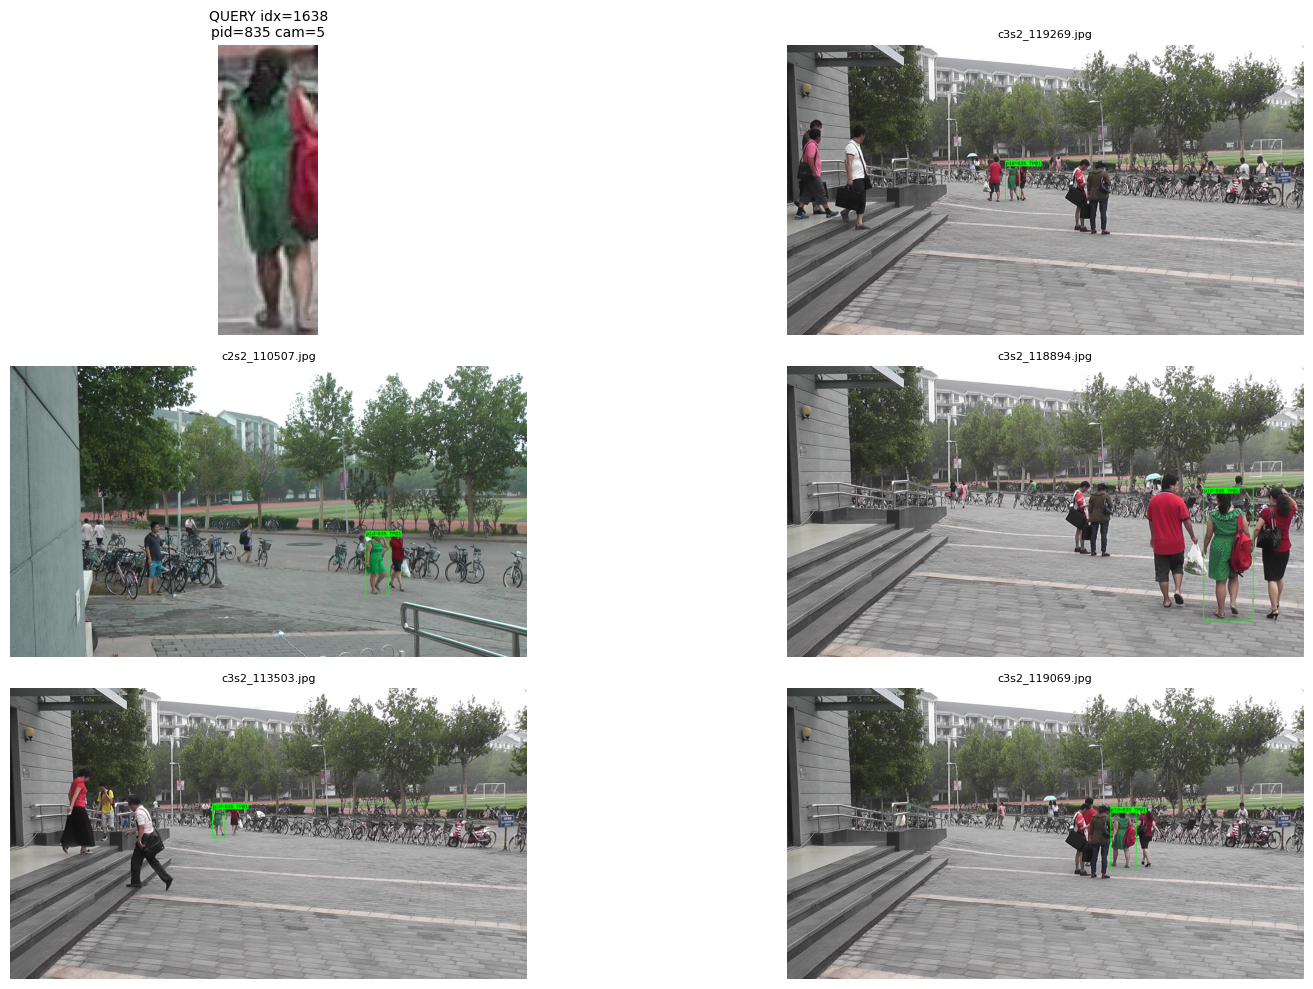

In [79]:
# choose a random query
idx = np.random.randint(len(os.listdir("/kaggle/input/prw-person-re-identification-in-the-wild/query_box")))

# query search over gallery and viz 
ranked = visualize_person_search_prw_tp_fp(
    query_idx=idx,
    gallery_eval=gallery_eval,
    query_ds=query_ds,
    gallery_dets=test_detections,
    gallery_feats=test_gallery_feats,
    query_box_feats=query_feats,
    det_thresh=0.3,
    topk_images=5,
    ignore_cam_id=True,
)

In [80]:
# instantiate model
model_reid_af = ReIDNetArcFace( 
            emb_dim=emb_dim,
            num_classes=num_classes,
            s=.30,
            m=.25,
        ).to(device)

# load weights
weights_reid_path = "/kaggle/working/ckpts/arcface_r50_m25_final_epoch20.pth"
ckpt_reid = torch.load(weights_reid_path, map_location="cpu")

# load weights into model
model_reid_af.load_state_dict(ckpt_reid["model"], strict=True)
model_reid_af.to(device)
model_reid_af.eval()   # inference mode 

# compute feature embeddings
query_feats = compute_query_box_feats_from_querybox(
        reid_model=model_reid_af,
        query_info_path="/kaggle/input/prw-person-re-identification-in-the-wild/query_info.txt",
        query_box_dir="/kaggle/input/prw-person-re-identification-in-the-wild/query_box",
        transform=test_reid_tf,
        device=device,
    )
test_gallery_feats = build_gallery_feats_from_dets_prw_dataset(
    reid_model=model_reid_af,
    prw_dataset=test_ds,
    detections=test_detections,
    transform=test_reid_tf,
    device=device,
)

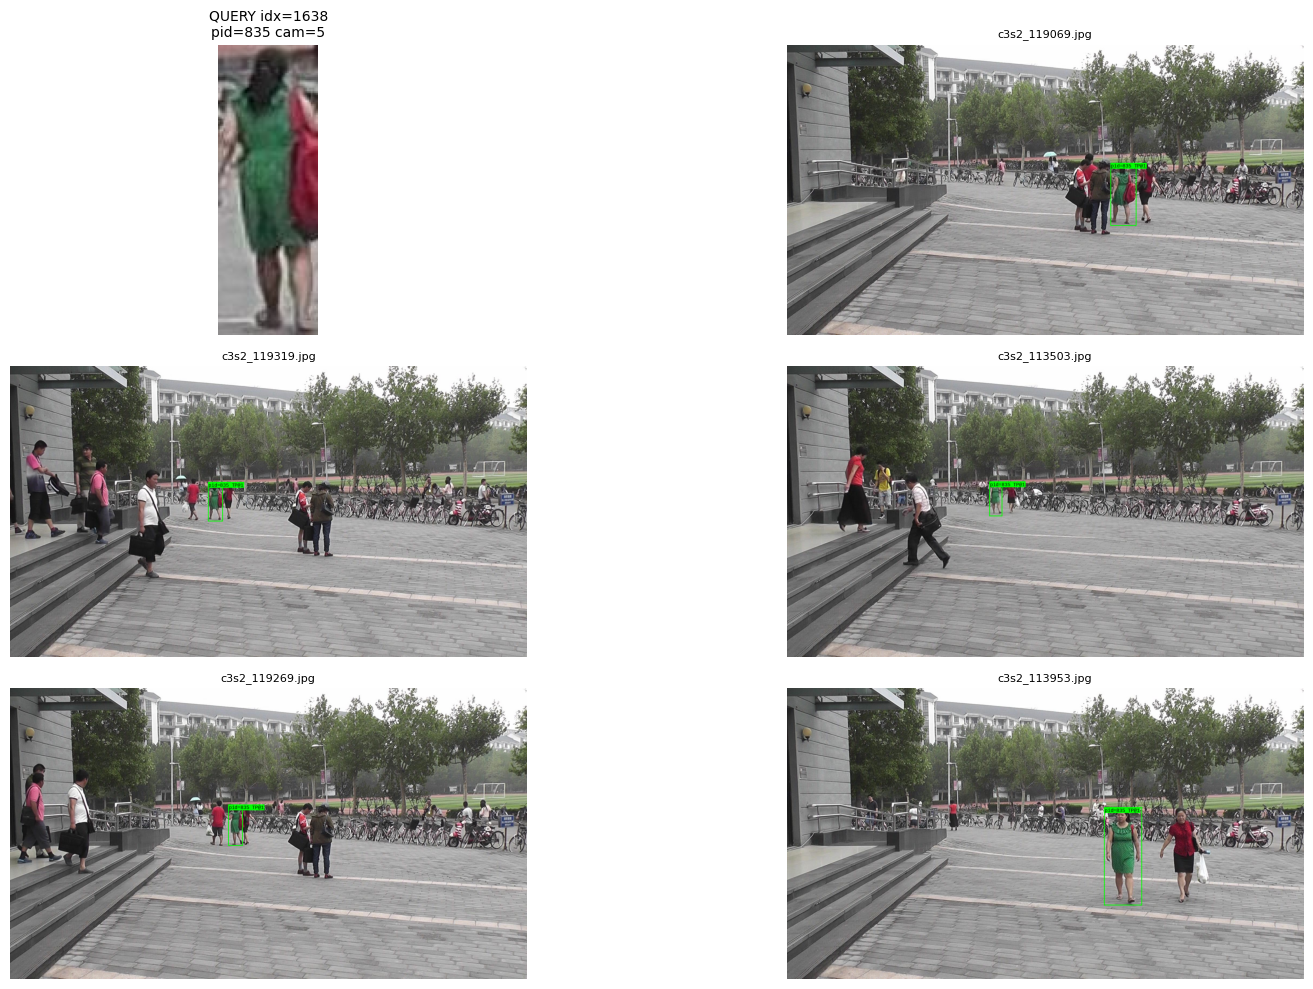

In [83]:
# choose a random query
idx = np.random.randint(len(os.listdir("/kaggle/input/prw-person-re-identification-in-the-wild/query_box")))

# query search over gallery and viz 
ranked = visualize_person_search_prw_tp_fp(
    query_idx=1638,
    gallery_eval=gallery_eval,
    query_ds=query_ds,
    gallery_dets=test_detections,
    gallery_feats=test_gallery_feats,
    query_box_feats=query_feats,
    det_thresh=0.3,
    topk_images=5,
    ignore_cam_id=True,
)